In [1]:
import os

import numpy as np

import tensorflow as tf
from tensorflow import keras



from RoadDataset import RoadDataset

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
val_datasets_path = "../notebooks/datasets/validation/"
sub_dirs = os.listdir(val_datasets_path)
val_dataset_paths = [[val_datasets_path + sub_dir + "/" + sub_dir + ".csv", val_datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
val_dataset_paths

[['../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv',
  '../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/frames/'],
 ['../notebooks/datasets/validation/Nacht-Schneechaos/Nacht-Schneechaos.csv',
  '../notebooks/datasets/validation/Nacht-Schneechaos/frames/']]

In [4]:
dataset_index = 0
column_names = ['filename','steering_wheel_angle','speed', 'blink_l', 'blink_r']
val_set = RoadDataset(val_dataset_paths[dataset_index][0], val_dataset_paths[dataset_index][1], column_names, batch_size=16)
#val_set.clean()

Reading csv file: ../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv
Loaded dataset with 10474 samples


In [5]:
stats = val_set.get_csv().describe()
stats = stats.transpose()
stats

count       mean        std     min     25%    50%  \
steering_wheel_angle  10474.0  -3.780677  64.743614 -483.53  -6.320  -0.75   
speed                 10474.0  48.727898  18.037577    0.00  40.269  51.77   
blink_l               10474.0   0.006301   0.079134    0.00   0.000   0.00   
blink_r               10474.0   0.055662   0.229278    0.00   0.000   0.00   

                         75%      max  
steering_wheel_angle   2.690  496.490  
speed                 59.954   77.066  
blink_l                0.000    1.000  
blink_r                0.000    1.000

In [6]:
#val_set.balance()
val_set.normalize()

In [7]:
stats = val_set.get_csv().describe()
stats = stats.transpose()
stats

count       mean        std       min        25%  \
steering_wheel_angle  10474.0  -0.042008   0.719373 -5.372556  -0.070222   
speed                 10474.0  48.727898  18.037577  0.000000  40.269000   
blink_l               10474.0   0.006301   0.079134  0.000000   0.000000   
blink_r               10474.0   0.055662   0.229278  0.000000   0.000000   

                            50%        75%        max  
steering_wheel_angle  -0.008333   0.029889   5.516556  
speed                 51.770000  59.954000  77.066000  
blink_l                0.000000   0.000000   1.000000  
blink_r                0.000000   0.000000   1.000000

In [8]:
#model_name = 'diypilot_v1'
#model_name = 'diypilot_v2_epoch_10'
#model_name = 'diypilot_v3_epoch_5'
#model_name = 'openpilot_replica_epoch_59'
#model_name = 'openpilot_replica_mae_epoch_100'
#model_name = 'diypilot_v9_small_FC_epoch_3'
#model_name = 'diypilot_v11_random_shifts_epoch_3'
#model_name = 'diypilot_v11_random_shifts_full_balance_epoch_3'
#model_name = 'diypilot_v11_full_balance_epoch_163'
#model_name = 'diypilot_v12_epoch_58'
#model_name = 'diypilot_v13_sum_min5_overrepr_epoch_10'
#model_name = 'diypilot_v14_smaller_crop_epoch_3'
model_name = 'diypilot_v14_smaller_crop_wider_epoch_3'
loaded_model = keras.models.load_model('./trained_models/' + model_name + '.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 170, 848, 3)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 170, 282, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 82, 138, 16)       2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 69, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 33, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 16, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 6, 64)          5

In [9]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from Jetson.autopilot.record.AutopilotGUI import AutopilotGUI

In [10]:
gui = AutopilotGUI()

In [11]:
def show_frame(test_image_index):

    test_sample = val_set.get_frame(test_image_index)
    test_image = test_sample[0]
    test_image_cropped = val_set.get_cropped_frame(test_image_index, shift=0)[0]
    test_labels = test_sample[1]

    print("Test csv: " + str(test_labels))

    test_data = np.expand_dims(test_image_cropped, axis=0)
    predictions = loaded_model.predict(test_data)

    gui.set_frame(test_image)
    gui.set_show_overlay(True)
    gui.set_engaged(False)
    gui.set_recording(True)

    timestamp = test_labels['filename']
    gui.set_timestring(timestamp)

    velocity = test_labels['speed']
    gui.set_velocity(velocity)

    actual_swa = test_labels['steering_wheel_angle']*90
    gui.set_actual_swa(actual_swa)

    predicted_swa = predictions[0][0]*90
    print("Ground-truth: " +str(actual_swa))
    print("Prediction: " + str(predicted_swa))
    gui.set_predicted_swa(predicted_swa)

    gui.show_jupyter()

In [12]:
import ipywidgets as widgets
frame_slider = widgets.IntSlider(min=0, max=val_set.get_batch_size()*len(val_set)-1, continuous_update=False)

In [13]:
from ipywidgets import interact

interact(show_frame, test_image_index=frame_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='test_image_index', max=10463), …

In [14]:
import cv2
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(model_name + '.avi',fourcc, 15.0, (848,480))

In [15]:
framecount = val_set.get_batch_size()*len(val_set)
ground_truth = []
predictions_list = []
velocity_list = []
for i in range(framecount):
    test_sample = val_set.get_frame(i)
    test_image = test_sample[0]
    test_image_cropped = val_set.get_cropped_frame(i, shift = 0)[0]
    test_labels = test_sample[1]

    print("Test csv: " + str(test_labels))

    test_data = np.expand_dims(test_image_cropped, axis=0)
    predictions = loaded_model.predict(test_data)

    gui.set_frame(test_image)
    gui.set_show_overlay(True)
    gui.set_engaged(False)
    gui.set_recording(True)

    timestamp = test_labels['filename']
    gui.set_timestring(timestamp)

    velocity = test_labels['speed']
    velocity_list.append(velocity)
    gui.set_velocity(velocity)

    actual_swa = test_labels['steering_wheel_angle']*90
    ground_truth.append(actual_swa)
    gui.set_actual_swa(actual_swa)

    predicted_swa = predictions[0][0]*90
    predictions_list.append(predicted_swa)
    print("Ground-truth: " +str(actual_swa))
    print("Prediction: " + str(predicted_swa))
    gui.set_predicted_swa(predicted_swa)
    
    gui.render()
    frame = gui.get_rendered_gui()
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    out.write(rgb_frame.astype(np.uint8))
    
out.release()

Test csv: filename                1609088520.3121.jpg
steering_wheel_angle              -0.314444
speed                                     0
blink_l                                   0
blink_r                                   0
Name: 0, dtype: object
Ground-truth: -28.3
Prediction: -4.1583530232310295
Test csv: filename                1609088520.5036263.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 1, dtype: object
Ground-truth: -28.3
Prediction: -6.143584996461868
Test csv: filename                1609088520.5699978.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 2, dtype: object
Ground-truth: -28.3
Prediction: -5.698182061314583
Test csv: filename                1609088520.6284947.jpg


Ground-truth: -28.3
Prediction: -12.217251509428024
Test csv: filename                1609088522.2336452.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 27, dtype: object
Ground-truth: -28.3
Prediction: -9.53031711280346
Test csv: filename                1609088522.3009665.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 28, dtype: object
Ground-truth: -28.3
Prediction: -10.18355168402195
Test csv: filename                1609088522.3629313.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 29, dtype: object
Ground-truth: -28.3
Prediction: -11.7886

Ground-truth: -28.3
Prediction: -6.61131463944912
Test csv: filename                1609088524.0308423.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 54, dtype: object
Ground-truth: -28.3
Prediction: -9.38125804066658
Test csv: filename                1609088524.114239.jpg
steering_wheel_angle                -0.314444
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 55, dtype: object
Ground-truth: -28.3
Prediction: -13.563127666711807
Test csv: filename                1609088524.1599658.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 56, dtype: object
Ground-truth: -28.3
Prediction: -13.7441177666

Ground-truth: -28.3
Prediction: 4.659731984138489
Test csv: filename                1609088525.8316398.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 81, dtype: object
Ground-truth: -28.3
Prediction: 7.291887626051903
Test csv: filename                1609088525.9033237.jpg
steering_wheel_angle                 -0.313778
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 82, dtype: object
Ground-truth: -28.24
Prediction: 2.9393071308732033
Test csv: filename                1609088525.969051.jpg
steering_wheel_angle                -0.288667
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 83, dtype: object
Ground-truth: -25.98
Prediction: 2.35104069113

Ground-truth: -2.38
Prediction: -0.8625427633523941
Test csv: filename                1609088527.6406376.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 108, dtype: object
Ground-truth: -2.38
Prediction: -1.4186029136180878
Test csv: filename                1609088527.6943688.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 109, dtype: object
Ground-truth: -2.38
Prediction: -7.349745556712151
Test csv: filename                1609088527.7613766.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 110, dtype: object
Ground-truth: -2.38
Prediction: -4.

Ground-truth: -2.38
Prediction: 5.501448065042496
Test csv: filename                1609088529.4300985.jpg
steering_wheel_angle                -0.0264444
speed                                    1.643
blink_l                                      0
blink_r                                      0
Name: 135, dtype: object
Ground-truth: -2.38
Prediction: 9.679921343922615
Test csv: filename                1609088529.502181.jpg
steering_wheel_angle               -0.0264444
speed                                   1.643
blink_l                                     0
blink_r                                     0
Name: 136, dtype: object
Ground-truth: -2.38
Prediction: 7.679481580853462
Test csv: filename                1609088529.5679767.jpg
steering_wheel_angle                -0.0264444
speed                                    1.643
blink_l                                      0
blink_r                                      0
Name: 137, dtype: object
Ground-truth: -2.38
Prediction: 2.90278114378

Ground-truth: 0.19000000000000003
Prediction: 22.697077989578247
Test csv: filename                1609088531.2424855.jpg
steering_wheel_angle                0.00211111
speed                                    2.883
blink_l                                      0
blink_r                                      0
Name: 162, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 19.00955155491829
Test csv: filename                1609088531.2989938.jpg
steering_wheel_angle                0.00211111
speed                                    2.883
blink_l                                      0
blink_r                                      0
Name: 163, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 26.894944310188293
Test csv: filename                1609088531.3745387.jpg
steering_wheel_angle                0.00211111
speed                                    2.945
blink_l                                      0
blink_r                                      0
Name: 164, dtype: obj

Ground-truth: 146.5
Prediction: 10.290247946977615
Test csv: filename                1609088533.03148.jpg
steering_wheel_angle                 1.62778
speed                                  4.867
blink_l                                    0
blink_r                                    0
Name: 189, dtype: object
Ground-truth: 146.5
Prediction: -15.299420803785324
Test csv: filename                1609088533.0992544.jpg
steering_wheel_angle                   1.94711
speed                                    4.867
blink_l                                      0
blink_r                                      0
Name: 190, dtype: object
Ground-truth: 175.24
Prediction: -9.452919960021973
Test csv: filename                1609088533.1665542.jpg
steering_wheel_angle                   2.27544
speed                                    5.084
blink_l                                      0
blink_r                                      0
Name: 191, dtype: object
Ground-truth: 204.78999999999996
Prediction: 

Ground-truth: 495.05
Prediction: 32.580814361572266
Test csv: filename                1609088534.8345017.jpg
steering_wheel_angle                   5.50056
speed                                    4.464
blink_l                                      0
blink_r                                      0
Name: 216, dtype: object
Ground-truth: 495.05
Prediction: 38.05173218250275
Test csv: filename                1609088534.8982887.jpg
steering_wheel_angle                   5.49844
speed                                    4.464
blink_l                                      0
blink_r                                      0
Name: 217, dtype: object
Ground-truth: 494.86
Prediction: 35.45180261135101
Test csv: filename                1609088534.976021.jpg
steering_wheel_angle                  5.50189
speed                                   4.185
blink_l                                     0
blink_r                                     0
Name: 218, dtype: object
Ground-truth: 495.17
Prediction: 27.80875

Ground-truth: 282.18
Prediction: -3.4706859290599823
Test csv: filename                1609088536.6455321.jpg
steering_wheel_angle                   3.13533
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 243, dtype: object
Ground-truth: 282.18
Prediction: -3.8087069615721703
Test csv: filename                1609088536.705284.jpg
steering_wheel_angle                  2.55933
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 244, dtype: object
Ground-truth: 230.34
Prediction: -1.6516456380486488
Test csv: filename                1609088536.7645428.jpg
steering_wheel_angle                   1.87267
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 245, dtype: object
Ground-truth: 168.54
Prediction: -0.

Ground-truth: -433.13000000000005
Prediction: -42.371923327445984
Test csv: filename                1609088538.4366364.jpg
steering_wheel_angle                  -4.81256
speed                                    2.666
blink_l                                      0
blink_r                                      0
Name: 270, dtype: object
Ground-truth: -433.13000000000005
Prediction: -41.38775646686554
Test csv: filename                1609088538.5073047.jpg
steering_wheel_angle                  -4.95578
speed                                    2.666
blink_l                                      0
blink_r                                      0
Name: 271, dtype: object
Ground-truth: -446.02
Prediction: -31.54374897480011
Test csv: filename                1609088538.5770764.jpg
steering_wheel_angle                  -5.05878
speed                                    3.193
blink_l                                      0
blink_r                                      0
Name: 272, dtype: object
Ground

Ground-truth: -442.64
Prediction: -4.957969151437283
Test csv: filename                1609088540.321152.jpg
steering_wheel_angle                 -4.71722
speed                                   7.161
blink_l                                     0
blink_r                                     0
Name: 298, dtype: object
Ground-truth: -424.55
Prediction: -26.591253876686096
Test csv: filename                1609088540.3987072.jpg
steering_wheel_angle                  -4.51822
speed                                    7.409
blink_l                                      0
blink_r                                      0
Name: 299, dtype: object
Ground-truth: -406.63999999999993
Prediction: -12.990221232175827
Test csv: filename                1609088540.4713151.jpg
steering_wheel_angle                  -4.29144
speed                                    7.409
blink_l                                      0
blink_r                                      0
Name: 300, dtype: object
Ground-truth: -386.230

Ground-truth: -15.779999999999998
Prediction: 20.833778232336044
Test csv: filename                1609088542.272737.jpg
steering_wheel_angle                -0.175333
speed                                  11.687
blink_l                                     0
blink_r                                     0
Name: 326, dtype: object
Ground-truth: -15.779999999999998
Prediction: 19.80012997984886
Test csv: filename                1609088542.318543.jpg
steering_wheel_angle               -0.0674444
speed                                  11.687
blink_l                                     0
blink_r                                     0
Name: 327, dtype: object
Ground-truth: -6.07
Prediction: 24.37162935733795
Test csv: filename                1609088542.3979936.jpg
steering_wheel_angle                -0.0396667
speed                                   12.338
blink_l                                      0
blink_r                                      0
Name: 328, dtype: object
Ground-truth: -3.57
P

Test csv: filename                1609088544.253886.jpg
steering_wheel_angle               -0.0132222
speed                                   13.33
blink_l                                     0
blink_r                                     0
Name: 354, dtype: object
Ground-truth: -1.19
Prediction: 4.073888249695301
Test csv: filename                1609088544.319607.jpg
steering_wheel_angle              -0.00344444
speed                                   13.33
blink_l                                     0
blink_r                                     0
Name: 355, dtype: object
Ground-truth: -0.31
Prediction: -2.6053791493177414
Test csv: filename                1609088544.3680687.jpg
steering_wheel_angle                0.00766667
speed                                   13.206
blink_l                                      0
blink_r                                      0
Name: 356, dtype: object
Ground-truth: 0.69
Prediction: -18.538455069065094
Test csv: filename                1609088544.46

Ground-truth: 23.92
Prediction: -19.636151790618896
Test csv: filename                1609088546.26071.jpg
steering_wheel_angle                0.290778
speed                                  7.688
blink_l                                    0
blink_r                                    0
Name: 382, dtype: object
Ground-truth: 26.17
Prediction: -4.90553867071867
Test csv: filename                1609088546.3281446.jpg
steering_wheel_angle                  0.290778
speed                                    7.688
blink_l                                      0
blink_r                                      0
Name: 383, dtype: object
Ground-truth: 26.17
Prediction: 5.230021253228188
Test csv: filename                1609088546.4003718.jpg
steering_wheel_angle                  0.300556
speed                                    6.572
blink_l                                      0
blink_r                                      0
Name: 384, dtype: object
Ground-truth: 27.05
Prediction: -4.7166246548295

Test csv: filename                1609088548.1338036.jpg
steering_wheel_angle                  0.306111
speed                                    2.604
blink_l                                      0
blink_r                                      0
Name: 410, dtype: object
Ground-truth: 27.55
Prediction: -38.29880118370056
Test csv: filename                1609088548.2213666.jpg
steering_wheel_angle                  0.302556
speed                                    2.604
blink_l                                      0
blink_r                                      0
Name: 411, dtype: object
Ground-truth: 27.23
Prediction: -6.872150748968124
Test csv: filename                1609088548.3541143.jpg
steering_wheel_angle                  0.301889
speed                                     2.48
blink_l                                      0
blink_r                                      0
Name: 412, dtype: object
Ground-truth: 27.170000000000005
Prediction: -0.7238235231488943
Test csv: filename     

Ground-truth: 3.94
Prediction: -1.3562035001814365
Test csv: filename                1609088550.5811625.jpg
steering_wheel_angle                     0.041
speed                                    5.332
blink_l                                      0
blink_r                                      0
Name: 439, dtype: object
Ground-truth: 3.69
Prediction: -3.6643990874290466
Test csv: filename                1609088550.6654758.jpg
steering_wheel_angle                 0.0396667
speed                                    5.332
blink_l                                      0
blink_r                                      0
Name: 440, dtype: object
Ground-truth: 3.57
Prediction: -4.693001434206963
Test csv: filename                1609088550.7281432.jpg
steering_wheel_angle                 0.0396667
speed                                    5.332
blink_l                                      0
blink_r                                      0
Name: 441, dtype: object
Ground-truth: 3.57
Prediction: -20.254

Test csv: filename                1609088552.388051.jpg
steering_wheel_angle                 0.239333
speed                                   9.269
blink_l                                     0
blink_r                                     0
Name: 466, dtype: object
Ground-truth: 21.54
Prediction: -27.357539534568787
Test csv: filename                1609088552.4470913.jpg
steering_wheel_angle                  0.244222
speed                                    9.269
blink_l                                      0
blink_r                                      0
Name: 467, dtype: object
Ground-truth: 21.98
Prediction: -27.379040122032166
Test csv: filename                1609088552.5202377.jpg
steering_wheel_angle                  0.244222
speed                                    9.269
blink_l                                      0
blink_r                                      0
Name: 468, dtype: object
Ground-truth: 21.98
Prediction: -27.89326786994934
Test csv: filename                160908

Test csv: filename                1609088554.2185981.jpg
steering_wheel_angle                  0.256667
speed                                   16.616
blink_l                                      0
blink_r                                      0
Name: 493, dtype: object
Ground-truth: 23.100000000000005
Prediction: -23.71770679950714
Test csv: filename                1609088554.2685611.jpg
steering_wheel_angle                  0.260222
speed                                   16.616
blink_l                                      0
blink_r                                      0
Name: 494, dtype: object
Ground-truth: 23.42
Prediction: -26.92328453063965
Test csv: filename                1609088554.3400545.jpg
steering_wheel_angle                  0.260222
speed                                   16.616
blink_l                                      0
blink_r                                      0
Name: 495, dtype: object
Ground-truth: 23.42
Prediction: -27.66480267047882
Test csv: filename      

Ground-truth: -42.2
Prediction: -32.019256353378296
Test csv: filename                1609088556.0735407.jpg
steering_wheel_angle                 -0.474444
speed                                   19.623
blink_l                                      0
blink_r                                      0
Name: 521, dtype: object
Ground-truth: -42.7
Prediction: -31.972838044166565
Test csv: filename                1609088556.1425078.jpg
steering_wheel_angle                 -0.477889
speed                                   20.646
blink_l                                      0
blink_r                                      0
Name: 522, dtype: object
Ground-truth: -43.01
Prediction: -37.33632802963257
Test csv: filename                1609088556.2260523.jpg
steering_wheel_angle                 -0.477889
speed                                   20.646
blink_l                                      0
blink_r                                      0
Name: 523, dtype: object
Ground-truth: -43.01
Prediction: -

Test csv: filename                1609088557.8760161.jpg
steering_wheel_angle                 0.0194444
speed                                    25.11
blink_l                                      0
blink_r                                      0
Name: 548, dtype: object
Ground-truth: 1.75
Prediction: -18.036796152591705
Test csv: filename                1609088557.9447713.jpg
steering_wheel_angle                 0.0194444
speed                                    25.11
blink_l                                      0
blink_r                                      0
Name: 549, dtype: object
Ground-truth: 1.75
Prediction: -17.643393874168396
Test csv: filename                1609088558.0184517.jpg
steering_wheel_angle                 0.0354444
speed                                   25.079
blink_l                                      0
blink_r                                      0
Name: 550, dtype: object
Ground-truth: 3.19
Prediction: -14.168250113725662
Test csv: filename                160

Ground-truth: 4.7
Prediction: -33.78476679325104
Test csv: filename                1609088559.7282462.jpg
steering_wheel_angle                 0.0522222
speed                                   25.668
blink_l                                      0
blink_r                                      0
Name: 576, dtype: object
Ground-truth: 4.7
Prediction: -16.687547117471695
Test csv: filename                1609088559.8014045.jpg
steering_wheel_angle                 0.0486667
speed                                   25.358
blink_l                                      0
blink_r                                      0
Name: 577, dtype: object
Ground-truth: 4.38
Prediction: -21.111204475164413
Test csv: filename                1609088559.8817353.jpg
steering_wheel_angle                 0.0473333
speed                                   25.358
blink_l                                      0
blink_r                                      0
Name: 578, dtype: object
Ground-truth: 4.26
Prediction: -22.83249

Test csv: filename                1609088561.5247946.jpg
steering_wheel_angle                 0.0153333
speed                                   21.886
blink_l                                      0
blink_r                                      0
Name: 603, dtype: object
Ground-truth: 1.38
Prediction: -26.75969660282135
Test csv: filename                1609088561.6007166.jpg
steering_wheel_angle                 0.0111111
speed                                   20.274
blink_l                                      0
blink_r                                      0
Name: 604, dtype: object
Ground-truth: 1.0
Prediction: -37.77129113674164
Test csv: filename                1609088561.6960506.jpg
steering_wheel_angle                0.00622222
speed                                   20.274
blink_l                                      0
blink_r                                      0
Name: 605, dtype: object
Ground-truth: 0.56
Prediction: -40.89417636394501
Test csv: filename                1609088

Ground-truth: -8.7
Prediction: -13.80429983139038
Test csv: filename                1609088563.3990529.jpg
steering_wheel_angle                 -0.118222
speed                                    8.463
blink_l                                      0
blink_r                                      1
Name: 631, dtype: object
Ground-truth: -10.64
Prediction: 6.445126980543137
Test csv: filename                1609088563.4581149.jpg
steering_wheel_angle                 -0.135667
speed                                    8.463
blink_l                                      0
blink_r                                      1
Name: 632, dtype: object
Ground-truth: -12.21
Prediction: 19.061314165592194
Test csv: filename                1609088563.527624.jpg
steering_wheel_angle                -0.135667
speed                                   8.463
blink_l                                     0
blink_r                                     1
Name: 633, dtype: object
Ground-truth: -12.21
Prediction: 28.593024

Ground-truth: -142.06
Prediction: 0.28015807271003723
Test csv: filename                1609088565.2017431.jpg
steering_wheel_angle                  -1.87411
speed                                    4.867
blink_l                                      0
blink_r                                      1
Name: 658, dtype: object
Ground-truth: -168.67
Prediction: -10.310068130493164
Test csv: filename                1609088565.2696395.jpg
steering_wheel_angle                  -2.17744
speed                                    4.867
blink_l                                      0
blink_r                                      1
Name: 659, dtype: object
Ground-truth: -195.97
Prediction: -10.412394404411316
Test csv: filename                1609088565.3336253.jpg
steering_wheel_angle                  -2.17744
speed                                    4.867
blink_l                                      0
blink_r                                      1
Name: 660, dtype: object
Ground-truth: -195.97
Predic

Test csv: filename                1609088567.0185058.jpg
steering_wheel_angle                  -3.69878
speed                                   10.354
blink_l                                      0
blink_r                                      1
Name: 685, dtype: object
Ground-truth: -332.89
Prediction: -20.118594020605087
Test csv: filename                1609088567.0760064.jpg
steering_wheel_angle                  -3.64589
speed                                   10.354
blink_l                                      0
blink_r                                      1
Name: 686, dtype: object
Ground-truth: -328.13
Prediction: -17.002211809158325
Test csv: filename                1609088567.1555345.jpg
steering_wheel_angle                  -3.56522
speed                                   11.563
blink_l                                      0
blink_r                                      1
Name: 687, dtype: object
Ground-truth: -320.87
Prediction: -22.898871302604675
Test csv: filename          

Test csv: filename                1609088568.7919755.jpg
steering_wheel_angle                  -1.05044
speed                                   15.593
blink_l                                      0
blink_r                                      0
Name: 712, dtype: object
Ground-truth: -94.54
Prediction: -42.288528084754944
Test csv: filename                1609088568.866125.jpg
steering_wheel_angle                   -0.809
speed                                  15.593
blink_l                                     0
blink_r                                     0
Name: 713, dtype: object
Ground-truth: -72.81
Prediction: -43.73989284038544
Test csv: filename                1609088568.9216564.jpg
steering_wheel_angle                    -0.809
speed                                   15.593
blink_l                                      0
blink_r                                      0
Name: 714, dtype: object
Ground-truth: -72.81
Prediction: -41.68745577335358
Test csv: filename                1609

Ground-truth: -11.14
Prediction: -36.838520765304565
Test csv: filename                1609088570.5876257.jpg
steering_wheel_angle                 -0.123778
speed                                   23.498
blink_l                                      0
blink_r                                      0
Name: 739, dtype: object
Ground-truth: -11.14
Prediction: -28.372498154640198
Test csv: filename                1609088570.6611435.jpg
steering_wheel_angle                 -0.123778
speed                                   23.498
blink_l                                      0
blink_r                                      0
Name: 740, dtype: object
Ground-truth: -11.14
Prediction: -28.198315501213074
Test csv: filename                1609088570.724888.jpg
steering_wheel_angle                -0.123778
speed                                  23.498
blink_l                                     0
blink_r                                     0
Name: 741, dtype: object
Ground-truth: -11.14
Prediction: -22

Ground-truth: -17.03
Prediction: -25.97171187400818
Test csv: filename                1609088572.3957758.jpg
steering_wheel_angle                 -0.194111
speed                                   26.846
blink_l                                      0
blink_r                                      0
Name: 765, dtype: object
Ground-truth: -17.47
Prediction: -38.02422344684601
Test csv: filename                1609088572.4557276.jpg
steering_wheel_angle                 -0.194111
speed                                   26.846
blink_l                                      0
blink_r                                      0
Name: 766, dtype: object
Ground-truth: -17.47
Prediction: -32.62019991874695
Test csv: filename                1609088572.5060184.jpg
steering_wheel_angle                 -0.202444
speed                                   26.846
blink_l                                      0
blink_r                                      0
Name: 767, dtype: object
Ground-truth: -18.22
Prediction: -

Ground-truth: -20.79
Prediction: -23.119032382965088
Test csv: filename                1609088574.1979563.jpg
steering_wheel_angle                    -0.224
speed                                   27.156
blink_l                                      0
blink_r                                      0
Name: 793, dtype: object
Ground-truth: -20.16
Prediction: -20.1719431579113
Test csv: filename                1609088574.2654238.jpg
steering_wheel_angle                    -0.208
speed                                   27.156
blink_l                                      0
blink_r                                      0
Name: 794, dtype: object
Ground-truth: -18.72
Prediction: -25.71875274181366
Test csv: filename                1609088574.3341262.jpg
steering_wheel_angle                    -0.208
speed                                   27.156
blink_l                                      0
blink_r                                      0
Name: 795, dtype: object
Ground-truth: -18.72
Prediction: -

Ground-truth: -4.07
Prediction: -22.27443963289261
Test csv: filename                1609088576.0637496.jpg
steering_wheel_angle                -0.0445556
speed                                   35.619
blink_l                                      0
blink_r                                      0
Name: 821, dtype: object
Ground-truth: -4.01
Prediction: -23.223981857299805
Test csv: filename                1609088576.1392558.jpg
steering_wheel_angle                -0.0445556
speed                                   35.619
blink_l                                      0
blink_r                                      0
Name: 822, dtype: object
Ground-truth: -4.01
Prediction: -22.293935269117355
Test csv: filename                1609088576.198907.jpg
steering_wheel_angle               -0.0445556
speed                                  36.611
blink_l                                     0
blink_r                                     0
Name: 823, dtype: object
Ground-truth: -4.01
Prediction: -18.5287

Test csv: filename                1609088577.7991846.jpg
steering_wheel_angle                -0.0507778
speed                                   39.711
blink_l                                      0
blink_r                                      0
Name: 847, dtype: object
Ground-truth: -4.57
Prediction: 1.6206372901797295
Test csv: filename                1609088577.878493.jpg
steering_wheel_angle               -0.0465556
speed                                  39.711
blink_l                                     0
blink_r                                     0
Name: 848, dtype: object
Ground-truth: -4.19
Prediction: 3.160518631339073
Test csv: filename                1609088577.9305396.jpg
steering_wheel_angle                -0.0465556
speed                                   39.711
blink_l                                      0
blink_r                                      0
Name: 849, dtype: object
Ground-truth: -4.19
Prediction: 2.3993616923689842
Test csv: filename                160908857

Test csv: filename                1609088579.5333595.jpg
steering_wheel_angle                 0.0292222
speed                                   39.773
blink_l                                      0
blink_r                                      0
Name: 873, dtype: object
Ground-truth: 2.63
Prediction: -5.112698078155518
Test csv: filename                1609088579.6102426.jpg
steering_wheel_angle                 0.0292222
speed                                   39.587
blink_l                                      0
blink_r                                      0
Name: 874, dtype: object
Ground-truth: 2.63
Prediction: -9.05009239912033
Test csv: filename                1609088579.6645188.jpg
steering_wheel_angle                 0.0326667
speed                                   39.587
blink_l                                      0
blink_r                                      0
Name: 875, dtype: object
Ground-truth: 2.9399999999999995
Prediction: -7.411300241947174
Test csv: filename         

Ground-truth: 0.94
Prediction: -9.286572709679604
Test csv: filename                1609088581.4055643.jpg
steering_wheel_angle                 0.0104444
speed                                   39.029
blink_l                                      0
blink_r                                      0
Name: 901, dtype: object
Ground-truth: 0.94
Prediction: -12.09970235824585
Test csv: filename                1609088581.4661531.jpg
steering_wheel_angle                     0.009
speed                                   39.029
blink_l                                      0
blink_r                                      0
Name: 902, dtype: object
Ground-truth: 0.81
Prediction: -17.17587411403656
Test csv: filename                1609088581.5366082.jpg
steering_wheel_angle                     0.009
speed                                   39.029
blink_l                                      0
blink_r                                      0
Name: 903, dtype: object
Ground-truth: 0.81
Prediction: -19.70765

Ground-truth: -2.69
Prediction: 0.9013999253511429
Test csv: filename                1609088583.2036357.jpg
steering_wheel_angle                -0.0298889
speed                                   40.176
blink_l                                      0
blink_r                                      0
Name: 928, dtype: object
Ground-truth: -2.69
Prediction: 2.3015955090522766
Test csv: filename                1609088583.2678878.jpg
steering_wheel_angle                -0.0298889
speed                                   40.176
blink_l                                      0
blink_r                                      0
Name: 929, dtype: object
Ground-truth: -2.69
Prediction: 5.866004526615143
Test csv: filename                1609088583.3461504.jpg
steering_wheel_angle                -0.0298889
speed                                   40.176
blink_l                                      0
blink_r                                      0
Name: 930, dtype: object
Ground-truth: -2.69
Prediction: 8.8647

Test csv: filename                1609088584.939005.jpg
steering_wheel_angle               -0.0166667
speed                                  41.044
blink_l                                     0
blink_r                                     0
Name: 954, dtype: object
Ground-truth: -1.5
Prediction: -13.911373615264893
Test csv: filename                1609088585.0063605.jpg
steering_wheel_angle                -0.0166667
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 955, dtype: object
Ground-truth: -1.5
Prediction: -11.331686675548553
Test csv: filename                1609088585.0737154.jpg
steering_wheel_angle                -0.0166667
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 956, dtype: object
Ground-truth: -1.5
Prediction: -10.798047110438347
Test csv: filename                16090885

Test csv: filename                1609088586.7476144.jpg
steering_wheel_angle                 0.0202222
speed                                   41.354
blink_l                                      0
blink_r                                      0
Name: 981, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -3.3914662152528763
Test csv: filename                1609088586.8124812.jpg
steering_wheel_angle                 0.0202222
speed                                   41.354
blink_l                                      0
blink_r                                      0
Name: 982, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -9.035576954483986
Test csv: filename                1609088586.871236.jpg
steering_wheel_angle                0.0202222
speed                                  41.354
blink_l                                     0
blink_r                                     0
Name: 983, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -3.6558133363723755
T

Test csv: filename                1609088588.5369668.jpg
steering_wheel_angle               -0.00977778
speed                                   41.881
blink_l                                      0
blink_r                                      0
Name: 1008, dtype: object
Ground-truth: -0.88
Prediction: -9.954739138484001
Test csv: filename                1609088588.6070116.jpg
steering_wheel_angle               -0.00977778
speed                                   42.284
blink_l                                      0
blink_r                                      0
Name: 1009, dtype: object
Ground-truth: -0.88
Prediction: -15.420816242694855
Test csv: filename                1609088588.6735332.jpg
steering_wheel_angle               -0.00344444
speed                                   42.284
blink_l                                      0
blink_r                                      0
Name: 1010, dtype: object
Ground-truth: -0.31
Prediction: -15.904131531715393
Test csv: filename              

Ground-truth: 21.91
Prediction: 37.60054171085358
Test csv: filename                1609088590.410021.jpg
steering_wheel_angle                 0.243444
speed                                   43.09
blink_l                                     0
blink_r                                     0
Name: 1036, dtype: object
Ground-truth: 21.91
Prediction: 36.50799214839935
Test csv: filename                1609088590.4749384.jpg
steering_wheel_angle                  0.243444
speed                                    43.09
blink_l                                      0
blink_r                                      0
Name: 1037, dtype: object
Ground-truth: 21.91
Prediction: 36.03613793849945
Test csv: filename                1609088590.5500185.jpg
steering_wheel_angle                  0.243444
speed                                    43.09
blink_l                                      0
blink_r                                      0
Name: 1038, dtype: object
Ground-truth: 21.91
Prediction: 36.3167452

Test csv: filename                1609088592.2090504.jpg
steering_wheel_angle                  0.252556
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 1063, dtype: object
Ground-truth: 22.729999999999997
Prediction: 37.090444564819336
Test csv: filename                1609088592.2808838.jpg
steering_wheel_angle                  0.252556
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 1064, dtype: object
Ground-truth: 22.729999999999997
Prediction: 37.78768479824066
Test csv: filename                1609088592.3395078.jpg
steering_wheel_angle                  0.252556
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 1065, dtype: object
Ground-truth: 22.729999999999997
Prediction: 35.996167659759

Ground-truth: 20.66
Prediction: 38.003838658332825
Test csv: filename                1609088594.0773687.jpg
steering_wheel_angle                  0.229556
speed                                   45.942
blink_l                                      0
blink_r                                      0
Name: 1091, dtype: object
Ground-truth: 20.66
Prediction: 39.76721942424774
Test csv: filename                1609088594.143496.jpg
steering_wheel_angle                 0.229556
speed                                  45.942
blink_l                                     0
blink_r                                     0
Name: 1092, dtype: object
Ground-truth: 20.66
Prediction: 39.41752374172211
Test csv: filename                1609088594.2193236.jpg
steering_wheel_angle                  0.229556
speed                                   46.128
blink_l                                      0
blink_r                                      0
Name: 1093, dtype: object
Ground-truth: 20.66
Prediction: 37.794808

Ground-truth: 22.41
Prediction: 32.290427684783936
Test csv: filename                1609088595.8814602.jpg
steering_wheel_angle                     0.249
speed                                   48.701
blink_l                                      0
blink_r                                      0
Name: 1118, dtype: object
Ground-truth: 22.41
Prediction: 31.684516668319702
Test csv: filename                1609088595.9416592.jpg
steering_wheel_angle                     0.249
speed                                   48.701
blink_l                                      0
blink_r                                      0
Name: 1119, dtype: object
Ground-truth: 22.41
Prediction: 29.44235622882843
Test csv: filename                1609088596.0109758.jpg
steering_wheel_angle                     0.249
speed                                   48.918
blink_l                                      0
blink_r                                      0
Name: 1120, dtype: object
Ground-truth: 22.41
Prediction: 29.

Ground-truth: -6.2
Prediction: -19.31560903787613
Test csv: filename                1609088597.686719.jpg
steering_wheel_angle               -0.0695556
speed                                  51.336
blink_l                                     0
blink_r                                     0
Name: 1145, dtype: object
Ground-truth: -6.26
Prediction: -19.529617130756378
Test csv: filename                1609088597.754281.jpg
steering_wheel_angle               -0.0695556
speed                                  51.336
blink_l                                     0
blink_r                                     0
Name: 1146, dtype: object
Ground-truth: -6.26
Prediction: -19.744282364845276
Test csv: filename                1609088597.8192158.jpg
steering_wheel_angle                    -0.073
speed                                   51.522
blink_l                                      0
blink_r                                      0
Name: 1147, dtype: object
Ground-truth: -6.570000000000001
Prediction

Test csv: filename                1609088599.411434.jpg
steering_wheel_angle                -0.138444
speed                                  53.754
blink_l                                     0
blink_r                                     0
Name: 1171, dtype: object
Ground-truth: -12.46
Prediction: -25.540691614151
Test csv: filename                1609088599.4839196.jpg
steering_wheel_angle                 -0.141889
speed                                   53.754
blink_l                                      0
blink_r                                      0
Name: 1172, dtype: object
Ground-truth: -12.770000000000001
Prediction: -24.674418568611145
Test csv: filename                1609088599.5516574.jpg
steering_wheel_angle                 -0.141889
speed                                   53.754
blink_l                                      0
blink_r                                      0
Name: 1173, dtype: object
Ground-truth: -12.770000000000001
Prediction: -24.86127197742462
Test csv: f

Ground-truth: -17.66
Prediction: -32.928128242492676
Test csv: filename                1609088601.2963216.jpg
steering_wheel_angle                 -0.201778
speed                                   56.637
blink_l                                      0
blink_r                                      0
Name: 1199, dtype: object
Ground-truth: -18.16
Prediction: -33.094468116760254
Test csv: filename                1609088601.3470263.jpg
steering_wheel_angle                 -0.202444
speed                                   56.637
blink_l                                      0
blink_r                                      0
Name: 1200, dtype: object
Ground-truth: -18.22
Prediction: -33.029789328575134
Test csv: filename                1609088601.4114423.jpg
steering_wheel_angle                 -0.202444
speed                                   56.668
blink_l                                      0
blink_r                                      0
Name: 1201, dtype: object
Ground-truth: -18.22
Predict

Ground-truth: -18.28
Prediction: -31.67080521583557
Test csv: filename                1609088603.0883145.jpg
steering_wheel_angle                 -0.203111
speed                                   56.792
blink_l                                      0
blink_r                                      0
Name: 1226, dtype: object
Ground-truth: -18.28
Prediction: -30.69503366947174
Test csv: filename                1609088603.1564877.jpg
steering_wheel_angle                 -0.203111
speed                                   56.792
blink_l                                      0
blink_r                                      0
Name: 1227, dtype: object
Ground-truth: -18.28
Prediction: -32.56018280982971
Test csv: filename                1609088603.2199345.jpg
steering_wheel_angle                 -0.203111
speed                                   56.792
blink_l                                      0
blink_r                                      0
Name: 1228, dtype: object
Ground-truth: -18.28
Prediction

Ground-truth: -16.65
Prediction: -30.014723539352417
Test csv: filename                1609088604.8908246.jpg
steering_wheel_angle                    -0.185
speed                                   54.777
blink_l                                      0
blink_r                                      0
Name: 1253, dtype: object
Ground-truth: -16.65
Prediction: -28.39016854763031
Test csv: filename                1609088604.9543092.jpg
steering_wheel_angle                    -0.185
speed                                   54.777
blink_l                                      0
blink_r                                      0
Name: 1254, dtype: object
Ground-truth: -16.65
Prediction: -27.06634819507599
Test csv: filename                1609088605.0196867.jpg
steering_wheel_angle                    -0.185
speed                                    54.56
blink_l                                      0
blink_r                                      0
Name: 1255, dtype: object
Ground-truth: -16.65
Predictio

Test csv: filename                1609088606.6872103.jpg
steering_wheel_angle                 -0.272667
speed                                   41.323
blink_l                                      0
blink_r                                      0
Name: 1280, dtype: object
Ground-truth: -24.54
Prediction: -41.8372517824173
Test csv: filename                1609088606.7547748.jpg
steering_wheel_angle                 -0.281778
speed                                   41.323
blink_l                                      0
blink_r                                      0
Name: 1281, dtype: object
Ground-truth: -25.360000000000003
Prediction: -42.50416696071625
Test csv: filename                1609088606.8245203.jpg
steering_wheel_angle                 -0.281778
speed                                    39.06
blink_l                                      0
blink_r                                      0
Name: 1282, dtype: object
Ground-truth: -25.360000000000003
Prediction: -41.76161348819733
Test c

Test csv: filename                1609088608.4942129.jpg
steering_wheel_angle                 -0.530111
speed                                   25.482
blink_l                                      0
blink_r                                      0
Name: 1307, dtype: object
Ground-truth: -47.71
Prediction: -41.6417670249939
Test csv: filename                1609088608.5735312.jpg
steering_wheel_angle                 -0.570444
speed                                   25.482
blink_l                                      0
blink_r                                      0
Name: 1308, dtype: object
Ground-truth: -51.34000000000001
Prediction: -56.955973505973816
Test csv: filename                1609088608.6276436.jpg
steering_wheel_angle                 -0.570444
speed                                   24.552
blink_l                                      0
blink_r                                      0
Name: 1309, dtype: object
Ground-truth: -51.34000000000001
Prediction: -35.425865650177
Test csv:

Ground-truth: -123.84
Prediction: -16.63956508040428
Test csv: filename                1609088610.3560307.jpg
steering_wheel_angle                  -1.43444
speed                                   22.103
blink_l                                      0
blink_r                                      1
Name: 1335, dtype: object
Ground-truth: -129.1
Prediction: -2.1776730939745903
Test csv: filename                1609088610.425379.jpg
steering_wheel_angle                 -1.43444
speed                                  22.103
blink_l                                     0
blink_r                                     1
Name: 1336, dtype: object
Ground-truth: -129.1
Prediction: -8.580897599458694
Test csv: filename                1609088610.4880672.jpg
steering_wheel_angle                  -1.48378
speed                                   22.103
blink_l                                      0
blink_r                                      1
Name: 1337, dtype: object
Ground-truth: -133.54
Prediction: 

Ground-truth: -143.69
Prediction: -23.758511245250702
Test csv: filename                1609088612.1639314.jpg
steering_wheel_angle                  -1.56733
speed                                   25.699
blink_l                                      0
blink_r                                      1
Name: 1362, dtype: object
Ground-truth: -141.06
Prediction: -35.11757254600525
Test csv: filename                1609088612.2321982.jpg
steering_wheel_angle                  -1.56733
speed                                   26.598
blink_l                                      0
blink_r                                      0
Name: 1363, dtype: object
Ground-truth: -141.06
Prediction: -44.377164244651794
Test csv: filename                1609088612.2857876.jpg
steering_wheel_angle                  -1.50889
speed                                   26.598
blink_l                                      0
blink_r                                      0
Name: 1364, dtype: object
Ground-truth: -135.8
Predi

Ground-truth: -23.35
Prediction: -23.376977741718292
Test csv: filename                1609088613.9544506.jpg
steering_wheel_angle                    -0.231
speed                                   35.526
blink_l                                      0
blink_r                                      0
Name: 1389, dtype: object
Ground-truth: -20.79
Prediction: -21.217894703149796
Test csv: filename                1609088614.0214024.jpg
steering_wheel_angle                    -0.231
speed                                   35.371
blink_l                                      0
blink_r                                      0
Name: 1390, dtype: object
Ground-truth: -20.79
Prediction: -19.798122346401215
Test csv: filename                1609088614.100799.jpg
steering_wheel_angle                -0.188556
speed                                  35.371
blink_l                                     0
blink_r                                     0
Name: 1391, dtype: object
Ground-truth: -16.97
Prediction: 

Test csv: filename                1609088615.760092.jpg
steering_wheel_angle                   -0.071
speed                                   38.44
blink_l                                     0
blink_r                                     0
Name: 1416, dtype: object
Ground-truth: -6.39
Prediction: -7.2156089544296265
Test csv: filename                1609088615.83376.jpg
steering_wheel_angle                  -0.071
speed                                 39.432
blink_l                                    0
blink_r                                    0
Name: 1417, dtype: object
Ground-truth: -6.39
Prediction: -8.503782749176025
Test csv: filename                1609088615.8909776.jpg
steering_wheel_angle                -0.0563333
speed                                   39.432
blink_l                                      0
blink_r                                      0
Name: 1418, dtype: object
Ground-truth: -5.07
Prediction: -8.002375960350037
Test csv: filename                1609088615.962

Ground-truth: 0.06
Prediction: -5.153501853346825
Test csv: filename                1609088617.6349802.jpg
steering_wheel_angle               0.000666667
speed                                   48.236
blink_l                                      0
blink_r                                      0
Name: 1444, dtype: object
Ground-truth: 0.06
Prediction: -3.494579717516899
Test csv: filename                1609088617.6922905.jpg
steering_wheel_angle               0.000666667
speed                                   48.236
blink_l                                      0
blink_r                                      0
Name: 1445, dtype: object
Ground-truth: 0.06
Prediction: -5.7850635051727295
Test csv: filename                1609088617.7620037.jpg
steering_wheel_angle               0.000666667
speed                                   48.236
blink_l                                      0
blink_r                                      0
Name: 1446, dtype: object
Ground-truth: 0.06
Prediction: -5.78

Ground-truth: -0.25
Prediction: -4.595998004078865
Test csv: filename                1609088619.4241674.jpg
steering_wheel_angle               -0.00277778
speed                                   51.863
blink_l                                      0
blink_r                                      0
Name: 1471, dtype: object
Ground-truth: -0.25
Prediction: -2.4503880366683006
Test csv: filename                1609088619.4930727.jpg
steering_wheel_angle                 0.0111111
speed                                   51.863
blink_l                                      0
blink_r                                      0
Name: 1472, dtype: object
Ground-truth: 1.0
Prediction: -3.6838538199663162
Test csv: filename                1609088619.5607326.jpg
steering_wheel_angle                 0.0181111
speed                                   51.863
blink_l                                      0
blink_r                                      0
Name: 1473, dtype: object
Ground-truth: 1.63
Prediction: -5.

Ground-truth: 1.8199999999999998
Prediction: -1.5020362101495266
Test csv: filename                1609088621.2301922.jpg
steering_wheel_angle                 0.0202222
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 1498, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -1.0851932689547539
Test csv: filename                1609088621.2996142.jpg
steering_wheel_angle                 0.0202222
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 1499, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -1.4344634860754013
Test csv: filename                1609088621.3628755.jpg
steering_wheel_angle                 0.0215556
speed                                   55.614
blink_l                                      0
blink_r                                      0
Name: 1500, dtype:

Ground-truth: 1.8199999999999998
Prediction: -5.4648905619978905
Test csv: filename                1609088623.0316148.jpg
steering_wheel_angle                 0.0202222
speed                                   57.443
blink_l                                      0
blink_r                                      0
Name: 1525, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -5.613412857055664
Test csv: filename                1609088623.0975018.jpg
steering_wheel_angle                 0.0202222
speed                                   57.443
blink_l                                      0
blink_r                                      0
Name: 1526, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 2.375470921397209
Test csv: filename                1609088623.1642387.jpg
steering_wheel_angle                 0.0202222
speed                                   57.722
blink_l                                      0
blink_r                                      0
Name: 1527, dtype: ob

Ground-truth: 2.38
Prediction: 2.239798419177532
Test csv: filename                1609088624.838234.jpg
steering_wheel_angle                0.0257778
speed                                   58.28
blink_l                                     0
blink_r                                     0
Name: 1552, dtype: object
Ground-truth: 2.32
Prediction: 2.289903089404106
Test csv: filename                1609088624.9108315.jpg
steering_wheel_angle                 0.0257778
speed                                    58.28
blink_l                                      0
blink_r                                      0
Name: 1553, dtype: object
Ground-truth: 2.32
Prediction: 1.8632031977176666
Test csv: filename                1609088624.9626825.jpg
steering_wheel_angle                 0.0264444
speed                                    58.28
blink_l                                      0
blink_r                                      0
Name: 1554, dtype: object
Ground-truth: 2.38
Prediction: -0.4258533194

Ground-truth: -0.81
Prediction: 6.079479530453682
Test csv: filename                1609088626.6344664.jpg
steering_wheel_angle                    -0.009
speed                                   57.877
blink_l                                      0
blink_r                                      0
Name: 1579, dtype: object
Ground-truth: -0.81
Prediction: 4.942808300256729
Test csv: filename                1609088626.7078195.jpg
steering_wheel_angle                    -0.009
speed                                   57.877
blink_l                                      0
blink_r                                      0
Name: 1580, dtype: object
Ground-truth: -0.81
Prediction: 5.044370144605637
Test csv: filename                1609088626.7666976.jpg
steering_wheel_angle                -0.0125556
speed                                   57.877
blink_l                                      0
blink_r                                      0
Name: 1581, dtype: object
Ground-truth: -1.13
Prediction: 1.191

Ground-truth: -7.759999999999999
Prediction: -14.483449906110764
Test csv: filename                1609088628.4323833.jpg
steering_wheel_angle                -0.0862222
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 1606, dtype: object
Ground-truth: -7.759999999999999
Prediction: -12.824719548225403
Test csv: filename                1609088628.5066257.jpg
steering_wheel_angle                -0.0862222
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 1607, dtype: object
Ground-truth: -7.759999999999999
Prediction: -16.375997811555862
Test csv: filename                1609088628.5687914.jpg
steering_wheel_angle                -0.0862222
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 1608, dtype:

Ground-truth: -11.460000000000003
Prediction: -21.925603598356247
Test csv: filename                1609088630.107132.jpg
steering_wheel_angle                -0.127333
speed                                  53.506
blink_l                                     0
blink_r                                     0
Name: 1631, dtype: object
Ground-truth: -11.460000000000003
Prediction: -21.368157416582108
Test csv: filename                1609088630.1741953.jpg
steering_wheel_angle                 -0.127333
speed                                   53.289
blink_l                                      0
blink_r                                      0
Name: 1632, dtype: object
Ground-truth: -11.460000000000003
Prediction: -19.58156481385231
Test csv: filename                1609088630.2419949.jpg
steering_wheel_angle                 -0.127333
speed                                   53.289
blink_l                                      0
blink_r                                      0
Name: 1633, dtype: ob

Name: 1658, dtype: object
Ground-truth: -11.39
Prediction: -21.600829660892487
Test csv: filename                1609088631.9679286.jpg
steering_wheel_angle                 -0.126556
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 1659, dtype: object
Ground-truth: -11.39
Prediction: -20.426038205623627
Test csv: filename                1609088632.0363133.jpg
steering_wheel_angle                 -0.126556
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 1660, dtype: object
Ground-truth: -11.39
Prediction: -19.972359985113144
Test csv: filename                1609088632.1007733.jpg
steering_wheel_angle                 -0.126556
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 1661, dtype: object
Gr

Ground-truth: -16.65
Prediction: -47.81499981880188
Test csv: filename                1609088633.7666638.jpg
steering_wheel_angle                 -0.185778
speed                                   50.561
blink_l                                      0
blink_r                                      0
Name: 1686, dtype: object
Ground-truth: -16.72
Prediction: -40.37672996520996
Test csv: filename                1609088633.8424838.jpg
steering_wheel_angle                 -0.189222
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 1687, dtype: object
Ground-truth: -17.03
Prediction: -42.24571466445923
Test csv: filename                1609088633.9071283.jpg
steering_wheel_angle                 -0.189222
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 1688, dtype: object
Ground-truth: -17.03
Prediction

Ground-truth: -17.53
Prediction: -29.679458141326904
Test csv: filename                1609088635.5795512.jpg
steering_wheel_angle                 -0.193444
speed                                    51.46
blink_l                                      0
blink_r                                      0
Name: 1713, dtype: object
Ground-truth: -17.41
Prediction: -26.545388102531433
Test csv: filename                1609088635.642912.jpg
steering_wheel_angle                -0.191333
speed                                   51.46
blink_l                                     0
blink_r                                     0
Name: 1714, dtype: object
Ground-truth: -17.22
Prediction: -28.43560516834259
Test csv: filename                1609088635.7078042.jpg
steering_wheel_angle                 -0.191333
speed                                    51.46
blink_l                                      0
blink_r                                      0
Name: 1715, dtype: object
Ground-truth: -17.22
Prediction: -

Ground-truth: -15.029999999999998
Prediction: -31.517951488494873
Test csv: filename                1609088637.4437845.jpg
steering_wheel_angle                 -0.169778
speed                                   51.181
blink_l                                      0
blink_r                                      0
Name: 1741, dtype: object
Ground-truth: -15.28
Prediction: -32.83313512802124
Test csv: filename                1609088637.5070565.jpg
steering_wheel_angle                 -0.169778
speed                                   51.181
blink_l                                      0
blink_r                                      0
Name: 1742, dtype: object
Ground-truth: -15.28
Prediction: -33.89873921871185
Test csv: filename                1609088637.5852432.jpg
steering_wheel_angle                 -0.173889
speed                                   51.181
blink_l                                      0
blink_r                                      0
Name: 1743, dtype: object
Ground-truth: -15

Test csv: filename                1609088639.177814.jpg
steering_wheel_angle                -0.219778
speed                                   50.22
blink_l                                     0
blink_r                                     0
Name: 1767, dtype: object
Ground-truth: -19.78
Prediction: -35.882715582847595
Test csv: filename                1609088639.2409189.jpg
steering_wheel_angle                 -0.220556
speed                                    50.22
blink_l                                      0
blink_r                                      0
Name: 1768, dtype: object
Ground-truth: -19.85
Prediction: -37.35544145107269
Test csv: filename                1609088639.318991.jpg
steering_wheel_angle                -0.220556
speed                                   50.22
blink_l                                     0
blink_r                                     0
Name: 1769, dtype: object
Ground-truth: -19.85
Prediction: -38.370341062545776
Test csv: filename                16090

Test csv: filename                1609088640.9201443.jpg
steering_wheel_angle                 -0.216333
speed                                   48.546
blink_l                                      0
blink_r                                      0
Name: 1793, dtype: object
Ground-truth: -19.47
Prediction: -15.775970220565796
Test csv: filename                1609088640.977994.jpg
steering_wheel_angle                -0.203778
speed                                   48.36
blink_l                                     0
blink_r                                     0
Name: 1794, dtype: object
Ground-truth: -18.34
Prediction: -17.02870935201645
Test csv: filename                1609088641.0590978.jpg
steering_wheel_angle                 -0.187778
speed                                    48.36
blink_l                                      0
blink_r                                      0
Name: 1795, dtype: object
Ground-truth: -16.9
Prediction: -19.642424136400223
Test csv: filename                1

Ground-truth: -5.89
Prediction: -1.5426044538617134
Test csv: filename                1609088642.6510315.jpg
steering_wheel_angle                -0.0654444
speed                                   48.856
blink_l                                      0
blink_r                                      0
Name: 1819, dtype: object
Ground-truth: -5.89
Prediction: -1.928592436015606
Test csv: filename                1609088642.714112.jpg
steering_wheel_angle               -0.0654444
speed                                  48.856
blink_l                                     0
blink_r                                     0
Name: 1820, dtype: object
Ground-truth: -5.89
Prediction: -2.503434084355831
Test csv: filename                1609088642.78356.jpg
steering_wheel_angle              -0.0654444
speed                                 49.104
blink_l                                    0
blink_r                                    0
Name: 1821, dtype: object
Ground-truth: -5.89
Prediction: 1.33926518261432

Test csv: filename                1609088644.382727.jpg
steering_wheel_angle               -0.0187778
speed                                  49.755
blink_l                                     0
blink_r                                     0
Name: 1845, dtype: object
Ground-truth: -1.6900000000000002
Prediction: 13.790938407182693
Test csv: filename                1609088644.4470234.jpg
steering_wheel_angle                -0.0174444
speed                                   49.755
blink_l                                      0
blink_r                                      0
Name: 1846, dtype: object
Ground-truth: -1.5700000000000003
Prediction: 13.201693296432495
Test csv: filename                1609088644.5110219.jpg
steering_wheel_angle                -0.0174444
speed                                   49.755
blink_l                                      0
blink_r                                      0
Name: 1847, dtype: object
Ground-truth: -1.5700000000000003
Prediction: 12.0664872229099

Ground-truth: 3.69
Prediction: 14.407264441251755
Test csv: filename                1609088646.2484598.jpg
steering_wheel_angle                     0.041
speed                                   49.135
blink_l                                      0
blink_r                                      0
Name: 1873, dtype: object
Ground-truth: 3.69
Prediction: 12.710277736186981
Test csv: filename                1609088646.314592.jpg
steering_wheel_angle                0.0486667
speed                                  49.135
blink_l                                     0
blink_r                                     0
Name: 1874, dtype: object
Ground-truth: 4.38
Prediction: 14.890814423561096
Test csv: filename                1609088646.3833067.jpg
steering_wheel_angle                 0.0528889
speed                                    48.98
blink_l                                      0
blink_r                                      0
Name: 1875, dtype: object
Ground-truth: 4.76
Prediction: 14.72832620

Ground-truth: 11.33
Prediction: 24.98714804649353
Test csv: filename                1609088648.0489545.jpg
steering_wheel_angle                  0.129444
speed                                   48.081
blink_l                                      0
blink_r                                      0
Name: 1900, dtype: object
Ground-truth: 11.65
Prediction: 30.020018219947815
Test csv: filename                1609088648.1156561.jpg
steering_wheel_angle                  0.129444
speed                                   48.081
blink_l                                      0
blink_r                                      0
Name: 1901, dtype: object
Ground-truth: 11.65
Prediction: 30.146082043647766
Test csv: filename                1609088648.1851463.jpg
steering_wheel_angle                  0.132222
speed                                   47.864
blink_l                                      0
blink_r                                      0
Name: 1902, dtype: object
Ground-truth: 11.899999999999999
Pr

Test csv: filename                1609088649.782886.jpg
steering_wheel_angle                 0.212889
speed                                  46.531
blink_l                                     0
blink_r                                     0
Name: 1926, dtype: object
Ground-truth: 19.16
Prediction: 34.77967321872711
Test csv: filename                1609088649.8488848.jpg
steering_wheel_angle                  0.212889
speed                                   46.531
blink_l                                      0
blink_r                                      0
Name: 1927, dtype: object
Ground-truth: 19.16
Prediction: 39.40567374229431
Test csv: filename                1609088649.919401.jpg
steering_wheel_angle                 0.212889
speed                                  46.531
blink_l                                     0
blink_r                                     0
Name: 1928, dtype: object
Ground-truth: 19.16
Prediction: 38.549678921699524
Test csv: filename                1609088649.9

Ground-truth: 15.399999999999999
Prediction: 28.7988942861557
Test csv: filename                1609088651.5862658.jpg
steering_wheel_angle                  0.169778
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1953, dtype: object
Ground-truth: 15.28
Prediction: 16.45686239004135
Test csv: filename                1609088651.6625037.jpg
steering_wheel_angle                  0.167667
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1954, dtype: object
Ground-truth: 15.09
Prediction: 14.950261563062668
Test csv: filename                1609088651.7155893.jpg
steering_wheel_angle                  0.167667
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1955, dtype: object
Ground-truth: 15.09
Pred

Test csv: filename                1609088653.3911562.jpg
steering_wheel_angle                 0.0667778
speed                                   38.223
blink_l                                      0
blink_r                                      0
Name: 1980, dtype: object
Ground-truth: 6.009999999999999
Prediction: -17.04032599925995
Test csv: filename                1609088653.451523.jpg
steering_wheel_angle                0.0605556
speed                                  38.223
blink_l                                     0
blink_r                                     0
Name: 1981, dtype: object
Ground-truth: 5.45
Prediction: -18.980516642332077
Test csv: filename                1609088653.526139.jpg
steering_wheel_angle                0.0605556
speed                                  38.223
blink_l                                     0
blink_r                                     0
Name: 1982, dtype: object
Ground-truth: 5.45
Prediction: -19.998507499694824
Test csv: filename              

Ground-truth: -32.99
Prediction: -28.396568298339844
Test csv: filename                1609088655.2008824.jpg
steering_wheel_angle                 -0.448667
speed                                   27.652
blink_l                                      0
blink_r                                      0
Name: 2007, dtype: object
Ground-truth: -40.38
Prediction: -18.529833108186722
Test csv: filename                1609088655.248941.jpg
steering_wheel_angle                -0.526556
speed                                  27.652
blink_l                                     0
blink_r                                     0
Name: 2008, dtype: object
Ground-truth: -47.39
Prediction: -31.485748887062073
Test csv: filename                1609088655.3152149.jpg
steering_wheel_angle                 -0.526556
speed                                   27.652
blink_l                                      0
blink_r                                      0
Name: 2009, dtype: object
Ground-truth: -47.39
Prediction: 

Ground-truth: -126.03000000000002
Prediction: 14.774973839521408
Test csv: filename                1609088656.925815.jpg
steering_wheel_angle                 -1.40033
speed                                  22.599
blink_l                                     0
blink_r                                     0
Name: 2033, dtype: object
Ground-truth: -126.03000000000002
Prediction: -20.710823088884354
Test csv: filename                1609088656.9956343.jpg
steering_wheel_angle                  -1.30089
speed                                   22.661
blink_l                                      0
blink_r                                      0
Name: 2034, dtype: object
Ground-truth: -117.07999999999998
Prediction: -32.94172167778015
Test csv: filename                1609088657.059617.jpg
steering_wheel_angle                 -1.13811
speed                                  22.661
blink_l                                     0
blink_r                                     0
Name: 2035, dtype: object
G

Test csv: filename                1609088658.653639.jpg
steering_wheel_angle                  1.19856
speed                                  25.358
blink_l                                     0
blink_r                                     0
Name: 2059, dtype: object
Ground-truth: 107.87
Prediction: 34.12822902202606
Test csv: filename                1609088658.7244227.jpg
steering_wheel_angle                   1.19856
speed                                   25.358
blink_l                                      0
blink_r                                      0
Name: 2060, dtype: object
Ground-truth: 107.87
Prediction: 34.95494484901428
Test csv: filename                1609088658.7922556.jpg
steering_wheel_angle                   1.24378
speed                                    25.42
blink_l                                      0
blink_r                                      0
Name: 2061, dtype: object
Ground-truth: 111.93999999999998
Prediction: 32.932618260383606
Test csv: filename        

Ground-truth: 148.07
Prediction: 2.8508274257183075
Test csv: filename                1609088660.457587.jpg
steering_wheel_angle                  1.65222
speed                                  24.831
blink_l                                     0
blink_r                                     0
Name: 2086, dtype: object
Ground-truth: 148.7
Prediction: 7.981259599328041
Test csv: filename                1609088660.5284138.jpg
steering_wheel_angle                   1.65222
speed                                   24.831
blink_l                                      0
blink_r                                      0
Name: 2087, dtype: object
Ground-truth: 148.7
Prediction: 17.375822067260742
Test csv: filename                1609088660.5949142.jpg
steering_wheel_angle                   1.65844
speed                                   25.017
blink_l                                      0
blink_r                                      0
Name: 2088, dtype: object
Ground-truth: 149.26
Prediction: 20.227

Ground-truth: 146.82
Prediction: -17.41850271821022
Test csv: filename                1609088662.190799.jpg
steering_wheel_angle                    1.575
speed                                  26.753
blink_l                                     0
blink_r                                     1
Name: 2112, dtype: object
Ground-truth: 141.75
Prediction: -16.263644099235535
Test csv: filename                1609088662.2585392.jpg
steering_wheel_angle                   1.47411
speed                                   26.753
blink_l                                      0
blink_r                                      1
Name: 2113, dtype: object
Ground-truth: 132.67
Prediction: -26.0832542181015
Test csv: filename                1609088662.3294969.jpg
steering_wheel_angle                   1.47411
speed                                   26.753
blink_l                                      0
blink_r                                      1
Name: 2114, dtype: object
Ground-truth: 132.67
Prediction: 37.

Ground-truth: -46.52
Prediction: -47.51633048057556
Test csv: filename                1609088663.9989922.jpg
steering_wheel_angle                 -0.580222
speed                                    29.14
blink_l                                      0
blink_r                                      1
Name: 2139, dtype: object
Ground-truth: -52.22
Prediction: -52.15852618217468
Test csv: filename                1609088664.0633988.jpg
steering_wheel_angle                    -0.633
speed                                    29.14
blink_l                                      0
blink_r                                      1
Name: 2140, dtype: object
Ground-truth: -56.97
Prediction: -48.7712287902832
Test csv: filename                1609088664.1302283.jpg
steering_wheel_angle                    -0.633
speed                                    29.14
blink_l                                      0
blink_r                                      1
Name: 2141, dtype: object
Ground-truth: -56.97
Prediction:

Ground-truth: -95.17
Prediction: -41.72686815261841
Test csv: filename                1609088665.7894933.jpg
steering_wheel_angle                  -1.05744
speed                                   29.636
blink_l                                      0
blink_r                                      1
Name: 2166, dtype: object
Ground-truth: -95.17
Prediction: -45.671265721321106
Test csv: filename                1609088665.8574996.jpg
steering_wheel_angle                  -1.05811
speed                                   29.636
blink_l                                      0
blink_r                                      1
Name: 2167, dtype: object
Ground-truth: -95.23
Prediction: -43.14262926578522
Test csv: filename                1609088665.9388628.jpg
steering_wheel_angle                  -1.05811
speed                                   29.636
blink_l                                      0
blink_r                                      1
Name: 2168, dtype: object
Ground-truth: -95.23
Predictio

Test csv: filename                1609088667.5305636.jpg
steering_wheel_angle                  -1.05111
speed                                   28.706
blink_l                                      0
blink_r                                      1
Name: 2192, dtype: object
Ground-truth: -94.6
Prediction: -45.109734535217285
Test csv: filename                1609088667.5982988.jpg
steering_wheel_angle                    -1.008
speed                                   28.458
blink_l                                      0
blink_r                                      1
Name: 2193, dtype: object
Ground-truth: -90.72
Prediction: -52.75915324687958
Test csv: filename                1609088667.6634996.jpg
steering_wheel_angle                 -0.953778
speed                                   28.458
blink_l                                      0
blink_r                                      1
Name: 2194, dtype: object
Ground-truth: -85.84
Prediction: -47.792624831199646
Test csv: filename            

Test csv: filename                1609088669.2620015.jpg
steering_wheel_angle                 -0.109889
speed                                    30.38
blink_l                                      0
blink_r                                      0
Name: 2218, dtype: object
Ground-truth: -9.89
Prediction: -23.790496587753296
Test csv: filename                1609088669.330583.jpg
steering_wheel_angle                -0.109889
speed                                   30.38
blink_l                                     0
blink_r                                     0
Name: 2219, dtype: object
Ground-truth: -9.89
Prediction: -13.466891348361969
Test csv: filename                1609088669.3981166.jpg
steering_wheel_angle                -0.0994444
speed                                   30.659
blink_l                                      0
blink_r                                      0
Name: 2220, dtype: object
Ground-truth: -8.95
Prediction: -14.655327200889587
Test csv: filename                16

Ground-truth: 7.829999999999999
Prediction: -8.784701228141785
Test csv: filename                1609088670.9974208.jpg
steering_wheel_angle                  0.105778
speed                                   31.682
blink_l                                      0
blink_r                                      0
Name: 2244, dtype: object
Ground-truth: 9.52
Prediction: -8.305377066135406
Test csv: filename                1609088671.080369.jpg
steering_wheel_angle                 0.122444
speed                                  31.682
blink_l                                     0
blink_r                                     0
Name: 2245, dtype: object
Ground-truth: 11.02
Prediction: -19.14079338312149
Test csv: filename                1609088671.1356564.jpg
steering_wheel_angle                  0.122444
speed                                   31.682
blink_l                                      0
blink_r                                      0
Name: 2246, dtype: object
Ground-truth: 11.02
Predicti

Ground-truth: 27.42
Prediction: -15.627987384796143
Test csv: filename                1609088672.7306342.jpg
steering_wheel_angle                  0.304667
speed                                   30.535
blink_l                                      0
blink_r                                      0
Name: 2270, dtype: object
Ground-truth: 27.42
Prediction: -15.473400950431824
Test csv: filename                1609088672.7998328.jpg
steering_wheel_angle                  0.334556
speed                                   30.535
blink_l                                      0
blink_r                                      0
Name: 2271, dtype: object
Ground-truth: 30.11
Prediction: -33.60520362854004
Test csv: filename                1609088672.8679395.jpg
steering_wheel_angle                  0.357556
speed                                   30.442
blink_l                                      0
blink_r                                      0
Name: 2272, dtype: object
Ground-truth: 32.18
Prediction: 

Ground-truth: 64.3
Prediction: 17.812824994325638
Test csv: filename                1609088674.4752753.jpg
steering_wheel_angle                  0.714444
speed                                   31.806
blink_l                                      0
blink_r                                      0
Name: 2296, dtype: object
Ground-truth: 64.3
Prediction: 23.40166747570038
Test csv: filename                1609088674.5317476.jpg
steering_wheel_angle                  0.714444
speed                                   31.806
blink_l                                      0
blink_r                                      0
Name: 2297, dtype: object
Ground-truth: 64.3
Prediction: 37.79550611972809
Test csv: filename                1609088674.6000264.jpg
steering_wheel_angle                  0.714444
speed                                   32.116
blink_l                                      0
blink_r                                      0
Name: 2298, dtype: object
Ground-truth: 64.3
Prediction: 41.66129

Test csv: filename                1609088676.3347507.jpg
steering_wheel_angle                  0.437556
speed                                   34.813
blink_l                                      0
blink_r                                      0
Name: 2324, dtype: object
Ground-truth: 39.38
Prediction: 17.205542027950287
Test csv: filename                1609088676.3973036.jpg
steering_wheel_angle                  0.397222
speed                                   35.402
blink_l                                      0
blink_r                                      0
Name: 2325, dtype: object
Ground-truth: 35.75
Prediction: 16.487199515104294
Test csv: filename                1609088676.464961.jpg
steering_wheel_angle                 0.350556
speed                                  35.402
blink_l                                     0
blink_r                                     0
Name: 2326, dtype: object
Ground-truth: 31.55
Prediction: 16.045498698949814
Test csv: filename                16090

Test csv: filename                1609088678.1404083.jpg
steering_wheel_angle                 0.0277778
speed                                   38.781
blink_l                                      0
blink_r                                      0
Name: 2351, dtype: object
Ground-truth: 2.5
Prediction: 6.281173601746559
Test csv: filename                1609088678.2127817.jpg
steering_wheel_angle                 0.0277778
speed                                   38.998
blink_l                                      0
blink_r                                      0
Name: 2352, dtype: object
Ground-truth: 2.5
Prediction: 6.166723072528839
Test csv: filename                1609088678.265381.jpg
steering_wheel_angle                0.0277778
speed                                  38.998
blink_l                                     0
blink_r                                     0
Name: 2353, dtype: object
Ground-truth: 2.5
Prediction: 7.790911942720413
Test csv: filename                1609088678.331

Ground-truth: 6.570000000000001
Prediction: 9.757832139730453
Test csv: filename                1609088679.945985.jpg
steering_wheel_angle                    0.073
speed                                  42.036
blink_l                                     0
blink_r                                     0
Name: 2378, dtype: object
Ground-truth: 6.570000000000001
Prediction: 16.463624238967896
Test csv: filename                1609088680.0039325.jpg
steering_wheel_angle                 0.0757778
speed                                   42.222
blink_l                                      0
blink_r                                      0
Name: 2379, dtype: object
Ground-truth: 6.82
Prediction: 17.33022317290306
Test csv: filename                1609088680.0775795.jpg
steering_wheel_angle                 0.0778889
speed                                   42.222
blink_l                                      0
blink_r                                      0
Name: 2380, dtype: object
Ground-truth: 7.01

Ground-truth: 9.02
Prediction: 0.9080204553902149
Test csv: filename                1609088681.6733236.jpg
steering_wheel_angle                  0.100222
speed                                   43.338
blink_l                                      0
blink_r                                      0
Name: 2404, dtype: object
Ground-truth: 9.02
Prediction: -6.392350494861603
Test csv: filename                1609088681.7373483.jpg
steering_wheel_angle                  0.100222
speed                                   43.338
blink_l                                      0
blink_r                                      0
Name: 2405, dtype: object
Ground-truth: 9.02
Prediction: -0.19993345253169537
Test csv: filename                1609088681.8061917.jpg
steering_wheel_angle                 0.0938889
speed                                   43.307
blink_l                                      0
blink_r                                      0
Name: 2406, dtype: object
Ground-truth: 8.45
Prediction: 2.04

Ground-truth: 3.3800000000000003
Prediction: -4.707302302122116
Test csv: filename                1609088683.4804068.jpg
steering_wheel_angle                 0.0347778
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 2431, dtype: object
Ground-truth: 3.13
Prediction: -1.9271613098680973
Test csv: filename                1609088683.5422819.jpg
steering_wheel_angle                 0.0347778
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 2432, dtype: object
Ground-truth: 3.13
Prediction: -6.970902979373932
Test csv: filename                1609088683.6079092.jpg
steering_wheel_angle                 0.0341111
speed                                   42.811
blink_l                                      0
blink_r                                      0
Name: 2433, dtype: object
Ground-truth: 3.069999

Ground-truth: -5.07
Prediction: 3.6462515965104103
Test csv: filename                1609088685.2769296.jpg
steering_wheel_angle                -0.0834444
speed                                   41.757
blink_l                                      0
blink_r                                      0
Name: 2458, dtype: object
Ground-truth: -7.51
Prediction: 11.64749264717102
Test csv: filename                1609088685.3411553.jpg
steering_wheel_angle                 -0.118222
speed                                   41.757
blink_l                                      0
blink_r                                      0
Name: 2459, dtype: object
Ground-truth: -10.64
Prediction: 5.814038068056107
Test csv: filename                1609088685.4092793.jpg
steering_wheel_angle                 -0.118222
speed                                   41.509
blink_l                                      0
blink_r                                      0
Name: 2460, dtype: object
Ground-truth: -10.64
Prediction: -4

Test csv: filename                1609088687.0151153.jpg
steering_wheel_angle                 -0.947444
speed                                   35.464
blink_l                                      0
blink_r                                      0
Name: 2484, dtype: object
Ground-truth: -85.27
Prediction: -54.12040114402771
Test csv: filename                1609088687.0795724.jpg
steering_wheel_angle                 -0.957222
speed                                   35.464
blink_l                                      0
blink_r                                      0
Name: 2485, dtype: object
Ground-truth: -86.15
Prediction: -51.06051027774811
Test csv: filename                1609088687.147928.jpg
steering_wheel_angle                -0.957222
speed                                  35.464
blink_l                                     0
blink_r                                     0
Name: 2486, dtype: object
Ground-truth: -86.15
Prediction: -55.72097182273865
Test csv: filename                16

Ground-truth: -114.63999999999999
Prediction: -55.40497004985809
Test csv: filename                1609088688.8831728.jpg
steering_wheel_angle                  -1.28622
speed                                   33.914
blink_l                                      0
blink_r                                      0
Name: 2512, dtype: object
Ground-truth: -115.76000000000002
Prediction: -52.33480632305145
Test csv: filename                1609088688.9492495.jpg
steering_wheel_angle                  -1.30711
speed                                   33.914
blink_l                                      0
blink_r                                      0
Name: 2513, dtype: object
Ground-truth: -117.64
Prediction: -54.65989530086517
Test csv: filename                1609088689.0075462.jpg
steering_wheel_angle                  -1.30711
speed                                   34.038
blink_l                                      0
blink_r                                      0
Name: 2514, dtype: object
Grou

Ground-truth: -18.66
Prediction: 6.819513067603111
Test csv: filename                1609088690.6759043.jpg
steering_wheel_angle                 -0.161444
speed                                   40.362
blink_l                                      0
blink_r                                      0
Name: 2539, dtype: object
Ground-truth: -14.53
Prediction: 0.36268092691898346
Test csv: filename                1609088690.750419.jpg
steering_wheel_angle                -0.116222
speed                                  40.362
blink_l                                     0
blink_r                                     0
Name: 2540, dtype: object
Ground-truth: -10.46
Prediction: 5.498080551624298
Test csv: filename                1609088690.8163877.jpg
steering_wheel_angle                 -0.116222
speed                                   41.323
blink_l                                      0
blink_r                                      0
Name: 2541, dtype: object
Ground-truth: -10.46
Prediction: 13.4

Ground-truth: -3.94
Prediction: 3.658573664724827
Test csv: filename                1609088692.5438256.jpg
steering_wheel_angle                -0.0375556
speed                                   46.655
blink_l                                      0
blink_r                                      0
Name: 2567, dtype: object
Ground-truth: -3.3800000000000003
Prediction: 5.938617289066315
Test csv: filename                1609088692.608406.jpg
steering_wheel_angle               -0.0375556
speed                                   47.12
blink_l                                     0
blink_r                                     0
Name: 2568, dtype: object
Ground-truth: -3.3800000000000003
Prediction: 6.665377914905548
Test csv: filename                1609088692.6847827.jpg
steering_wheel_angle                -0.0271111
speed                                    47.12
blink_l                                      1
blink_r                                      0
Name: 2569, dtype: object
Ground-truth: 

Ground-truth: 9.2
Prediction: -17.141346037387848
Test csv: filename                1609088694.279361.jpg
steering_wheel_angle                    0.096
speed                                  50.127
blink_l                                     1
blink_r                                     0
Name: 2593, dtype: object
Ground-truth: 8.64
Prediction: -10.826137214899063
Test csv: filename                1609088694.3619819.jpg
steering_wheel_angle                     0.089
speed                                   50.499
blink_l                                      1
blink_r                                      0
Name: 2594, dtype: object
Ground-truth: 8.01
Prediction: -12.55314588546753
Test csv: filename                1609088694.4184186.jpg
steering_wheel_angle                     0.089
speed                                   50.499
blink_l                                      1
blink_r                                      0
Name: 2595, dtype: object
Ground-truth: 8.01
Prediction: -16.482071

Ground-truth: -8.2
Prediction: -11.82666689157486
Test csv: filename                1609088696.152898.jpg
steering_wheel_angle               -0.0981111
speed                                  54.808
blink_l                                     1
blink_r                                     0
Name: 2621, dtype: object
Ground-truth: -8.83
Prediction: -10.658978596329689
Test csv: filename                1609088696.221301.jpg
steering_wheel_angle               -0.0981111
speed                                  54.808
blink_l                                     1
blink_r                                     0
Name: 2622, dtype: object
Ground-truth: -8.83
Prediction: -14.361354410648346
Test csv: filename                1609088696.2866557.jpg
steering_wheel_angle                 -0.104333
speed                                   54.808
blink_l                                      1
blink_r                                      0
Name: 2623, dtype: object
Ground-truth: -9.39
Prediction: -15.0227804

Test csv: filename                1609088697.8987114.jpg
steering_wheel_angle                -0.0577778
speed                                    59.83
blink_l                                      0
blink_r                                      0
Name: 2647, dtype: object
Ground-truth: -5.2
Prediction: 2.175259105861187
Test csv: filename                1609088697.944749.jpg
steering_wheel_angle               -0.0473333
speed                                  60.047
blink_l                                     0
blink_r                                     0
Name: 2648, dtype: object
Ground-truth: -4.26
Prediction: 1.4029636234045029
Test csv: filename                1609088698.014717.jpg
steering_wheel_angle               -0.0473333
speed                                  60.047
blink_l                                     0
blink_r                                     0
Name: 2649, dtype: object
Ground-truth: -4.26
Prediction: 6.74311637878418
Test csv: filename                1609088698.079

Test csv: filename                1609088699.7524462.jpg
steering_wheel_angle                     0.009
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 2675, dtype: object
Ground-truth: 0.81
Prediction: -0.15449389815330505
Test csv: filename                1609088699.8201175.jpg
steering_wheel_angle                     0.009
speed                                   60.047
blink_l                                      0
blink_r                                      0
Name: 2676, dtype: object
Ground-truth: 0.81
Prediction: -0.5291303526610136
Test csv: filename                1609088699.887889.jpg
steering_wheel_angle                0.0104444
speed                                  60.047
blink_l                                     0
blink_r                                     0
Name: 2677, dtype: object
Ground-truth: 0.94
Prediction: 0.8899643272161484
Test csv: filename                16090

Ground-truth: -1.5
Prediction: -1.2622269429266453
Test csv: filename                1609088701.6201296.jpg
steering_wheel_angle                -0.0166667
speed                                   61.132
blink_l                                      0
blink_r                                      0
Name: 2703, dtype: object
Ground-truth: -1.5
Prediction: -2.0367665961384773
Test csv: filename                1609088701.6898882.jpg
steering_wheel_angle                -0.0166667
speed                                   61.132
blink_l                                      0
blink_r                                      0
Name: 2704, dtype: object
Ground-truth: -1.5
Prediction: -0.5961400642991066
Test csv: filename                1609088701.756944.jpg
steering_wheel_angle               -0.0132222
speed                                  61.132
blink_l                                     0
blink_r                                     0
Name: 2705, dtype: object
Ground-truth: -1.19
Prediction: 0.80479

Test csv: filename                1609088703.3577878.jpg
steering_wheel_angle                -0.0236667
speed                                   62.279
blink_l                                      0
blink_r                                      0
Name: 2729, dtype: object
Ground-truth: -2.13
Prediction: -3.1519965827465057
Test csv: filename                1609088703.4257746.jpg
steering_wheel_angle                -0.0236667
speed                                   62.279
blink_l                                      0
blink_r                                      0
Name: 2730, dtype: object
Ground-truth: -2.13
Prediction: -3.525506593286991
Test csv: filename                1609088703.4958034.jpg
steering_wheel_angle                -0.0236667
speed                                   62.279
blink_l                                      0
blink_r                                      0
Name: 2731, dtype: object
Ground-truth: -2.13
Prediction: -3.3640728145837784
Test csv: filename              

Ground-truth: -1.0
Prediction: -1.0001139342784882
Test csv: filename                1609088705.158798.jpg
steering_wheel_angle                   -0.009
speed                                  63.395
blink_l                                     0
blink_r                                     0
Name: 2756, dtype: object
Ground-truth: -0.81
Prediction: -1.277176570147276
Test csv: filename                1609088705.2221472.jpg
steering_wheel_angle                    -0.009
speed                                   63.395
blink_l                                      0
blink_r                                      0
Name: 2757, dtype: object
Ground-truth: -0.81
Prediction: 1.0983964428305626
Test csv: filename                1609088705.294917.jpg
steering_wheel_angle              -0.00766667
speed                                  63.395
blink_l                                     0
blink_r                                     0
Name: 2758, dtype: object
Ground-truth: -0.69
Prediction: 1.7228810861

Ground-truth: -0.06
Prediction: 1.1994553729891777
Test csv: filename                1609088706.8873599.jpg
steering_wheel_angle              -0.000666667
speed                                   63.922
blink_l                                      0
blink_r                                      0
Name: 2782, dtype: object
Ground-truth: -0.06
Prediction: 1.4328387379646301
Test csv: filename                1609088706.9664404.jpg
steering_wheel_angle              -0.000666667
speed                                   63.984
blink_l                                      0
blink_r                                      0
Name: 2783, dtype: object
Ground-truth: -0.06
Prediction: 1.3662029430270195
Test csv: filename                1609088707.022903.jpg
steering_wheel_angle             -0.000666667
speed                                  63.984
blink_l                                     0
blink_r                                     0
Name: 2784, dtype: object
Ground-truth: -0.06
Prediction: 3.10391

Ground-truth: -0.13
Prediction: 3.807637095451355
Test csv: filename                1609088708.6271954.jpg
steering_wheel_angle               -0.00144444
speed                                   64.263
blink_l                                      0
blink_r                                      0
Name: 2808, dtype: object
Ground-truth: -0.13
Prediction: 5.600296854972839
Test csv: filename                1609088708.6926355.jpg
steering_wheel_angle               -0.00211111
speed                                   64.263
blink_l                                      0
blink_r                                      0
Name: 2809, dtype: object
Ground-truth: -0.19000000000000003
Prediction: 4.441729411482811
Test csv: filename                1609088708.7719243.jpg
steering_wheel_angle               -0.00488889
speed                                   64.263
blink_l                                      0
blink_r                                      0
Name: 2810, dtype: object
Ground-truth: -0.44
Pr

Ground-truth: -0.44
Prediction: 4.957457855343819
Test csv: filename                1609088710.4256103.jpg
steering_wheel_angle               -0.00488889
speed                                   64.852
blink_l                                      0
blink_r                                      0
Name: 2835, dtype: object
Ground-truth: -0.44
Prediction: 5.468973889946938
Test csv: filename                1609088710.499373.jpg
steering_wheel_angle              -0.00488889
speed                                  64.852
blink_l                                     0
blink_r                                     0
Name: 2836, dtype: object
Ground-truth: -0.44
Prediction: 3.034253977239132
Test csv: filename                1609088710.562658.jpg
steering_wheel_angle              -0.00344444
speed                                  65.069
blink_l                                     0
blink_r                                     0
Name: 2837, dtype: object
Ground-truth: -0.31
Prediction: 5.9844139963388

Ground-truth: 0.25
Prediction: 4.590836763381958
Test csv: filename                1609088712.1636477.jpg
steering_wheel_angle                0.00277778
speed                                   63.767
blink_l                                      0
blink_r                                      0
Name: 2861, dtype: object
Ground-truth: 0.25
Prediction: 8.205417841672897
Test csv: filename                1609088712.2306087.jpg
steering_wheel_angle                0.00277778
speed                                   63.767
blink_l                                      0
blink_r                                      0
Name: 2862, dtype: object
Ground-truth: 0.25
Prediction: 2.840854972600937
Test csv: filename                1609088712.2909434.jpg
steering_wheel_angle                0.00277778
speed                                   63.767
blink_l                                      0
blink_r                                      0
Name: 2863, dtype: object
Ground-truth: 0.25
Prediction: 5.2170494

Test csv: filename                1609088713.8922424.jpg
steering_wheel_angle               -0.00622222
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 2887, dtype: object
Ground-truth: -0.56
Prediction: 7.78672568500042
Test csv: filename                1609088713.9596837.jpg
steering_wheel_angle               -0.00488889
speed                                   61.008
blink_l                                      0
blink_r                                      0
Name: 2888, dtype: object
Ground-truth: -0.44
Prediction: 10.177984088659286
Test csv: filename                1609088714.0326498.jpg
steering_wheel_angle               -0.00488889
speed                                   61.008
blink_l                                      0
blink_r                                      0
Name: 2889, dtype: object
Ground-truth: -0.44
Prediction: 10.149708241224289
Test csv: filename                16

Ground-truth: -10.64
Prediction: -0.3760519903153181
Test csv: filename                1609088715.6965945.jpg
steering_wheel_angle                 -0.124556
speed                                   58.156
blink_l                                      0
blink_r                                      1
Name: 2914, dtype: object
Ground-truth: -11.21
Prediction: 0.21645326167345047
Test csv: filename                1609088715.7664127.jpg
steering_wheel_angle                 -0.128667
speed                                   58.156
blink_l                                      0
blink_r                                      1
Name: 2915, dtype: object
Ground-truth: -11.580000000000002
Prediction: -0.35016607493162155
Test csv: filename                1609088715.833599.jpg
steering_wheel_angle                -0.128667
speed                                  57.815
blink_l                                     0
blink_r                                     1
Name: 2916, dtype: object
Ground-truth: -11.5

Ground-truth: -2.44
Prediction: -12.41324320435524
Test csv: filename                1609088717.4243023.jpg
steering_wheel_angle                -0.0271111
speed                                   55.273
blink_l                                      0
blink_r                                      1
Name: 2940, dtype: object
Ground-truth: -2.44
Prediction: -11.010551154613495
Test csv: filename                1609088717.491433.jpg
steering_wheel_angle                   -0.025
speed                                  55.273
blink_l                                     0
blink_r                                     1
Name: 2941, dtype: object
Ground-truth: -2.25
Prediction: -12.581597417593002
Test csv: filename                1609088717.5615628.jpg
steering_wheel_angle                -0.0236667
speed                                   55.273
blink_l                                      0
blink_r                                      1
Name: 2942, dtype: object
Ground-truth: -2.13
Prediction: -10.8

Ground-truth: -2.25
Prediction: 0.8930798806250095
Test csv: filename                1609088719.2355404.jpg
steering_wheel_angle                    -0.025
speed                                   51.026
blink_l                                      0
blink_r                                      1
Name: 2967, dtype: object
Ground-truth: -2.25
Prediction: 8.019603118300438
Test csv: filename                1609088719.304773.jpg
steering_wheel_angle               -0.0305556
speed                                  51.026
blink_l                                     0
blink_r                                     1
Name: 2968, dtype: object
Ground-truth: -2.75
Prediction: 13.665708750486374
Test csv: filename                1609088719.3615432.jpg
steering_wheel_angle                -0.0403333
speed                                   49.848
blink_l                                      0
blink_r                                      1
Name: 2969, dtype: object
Ground-truth: -3.63
Prediction: 18.25757

Ground-truth: -62.92
Prediction: -29.39346492290497
Test csv: filename                1609088721.0282626.jpg
steering_wheel_angle                 -0.699111
speed                                   41.385
blink_l                                      0
blink_r                                      1
Name: 2994, dtype: object
Ground-truth: -62.92
Prediction: -31.41091525554657
Test csv: filename                1609088721.0953376.jpg
steering_wheel_angle                 -0.715778
speed                                   41.385
blink_l                                      0
blink_r                                      1
Name: 2995, dtype: object
Ground-truth: -64.42
Prediction: -25.551597476005554
Test csv: filename                1609088721.1672328.jpg
steering_wheel_angle                 -0.724889
speed                                   40.486
blink_l                                      0
blink_r                                      1
Name: 2996, dtype: object
Ground-truth: -65.24
Predictio

Ground-truth: -74.5
Prediction: -44.38328504562378
Test csv: filename                1609088722.9066823.jpg
steering_wheel_angle                 -0.842444
speed                                   36.673
blink_l                                      0
blink_r                                      1
Name: 3020, dtype: object
Ground-truth: -75.82
Prediction: -37.55329191684723
Test csv: filename                1609088722.9706135.jpg
steering_wheel_angle                 -0.866778
speed                                   36.332
blink_l                                      0
blink_r                                      1
Name: 3021, dtype: object
Ground-truth: -78.01
Prediction: -39.73002254962921
Test csv: filename                1609088723.0325975.jpg
steering_wheel_angle                 -0.866778
speed                                   36.332
blink_l                                      0
blink_r                                      1
Name: 3022, dtype: object
Ground-truth: -78.01
Prediction:

Ground-truth: -78.64
Prediction: -48.735995292663574
Test csv: filename                1609088724.70255.jpg
steering_wheel_angle               -0.868222
speed                                  35.65
blink_l                                    0
blink_r                                    1
Name: 3047, dtype: object
Ground-truth: -78.14
Prediction: -51.73736572265625
Test csv: filename                1609088724.7686245.jpg
steering_wheel_angle                 -0.848667
speed                                    35.65
blink_l                                      0
blink_r                                      1
Name: 3048, dtype: object
Ground-truth: -76.38
Prediction: -52.82099962234497
Test csv: filename                1609088724.834825.jpg
steering_wheel_angle                -0.848667
speed                                  35.929
blink_l                                     0
blink_r                                     1
Name: 3049, dtype: object
Ground-truth: -76.38
Prediction: -50.64898431

Ground-truth: -44.77
Prediction: -47.13611662387848
Test csv: filename                1609088726.5771244.jpg
steering_wheel_angle                 -0.501556
speed                                    38.44
blink_l                                      0
blink_r                                      0
Name: 3075, dtype: object
Ground-truth: -45.14
Prediction: -46.34455382823944
Test csv: filename                1609088726.641272.jpg
steering_wheel_angle                -0.501556
speed                                   38.44
blink_l                                     0
blink_r                                     0
Name: 3076, dtype: object
Ground-truth: -45.14
Prediction: -45.77387094497681
Test csv: filename                1609088726.703367.jpg
steering_wheel_angle                -0.501556
speed                                   38.44
blink_l                                     0
blink_r                                     0
Name: 3077, dtype: object
Ground-truth: -45.14
Prediction: -45.4019

Test csv: filename                1609088728.3076692.jpg
steering_wheel_angle                 -0.708889
speed                                   37.417
blink_l                                      0
blink_r                                      0
Name: 3101, dtype: object
Ground-truth: -63.800000000000004
Prediction: -52.88160681724548
Test csv: filename                1609088728.3667848.jpg
steering_wheel_angle                 -0.704667
speed                                   37.324
blink_l                                      0
blink_r                                      0
Name: 3102, dtype: object
Ground-truth: -63.42
Prediction: -48.64015460014343
Test csv: filename                1609088728.4406097.jpg
steering_wheel_angle                 -0.704667
speed                                   37.324
blink_l                                      0
blink_r                                      0
Name: 3103, dtype: object
Ground-truth: -63.42
Prediction: -51.318018436431885
Test csv: filenam

Ground-truth: -61.61
Prediction: -60.03130316734314
Test csv: filename                1609088730.1023085.jpg
steering_wheel_angle                 -0.684556
speed                                   37.231
blink_l                                      0
blink_r                                      0
Name: 3128, dtype: object
Ground-truth: -61.61
Prediction: -64.02607262134552
Test csv: filename                1609088730.1681614.jpg
steering_wheel_angle                 -0.684556
speed                                   37.169
blink_l                                      0
blink_r                                      0
Name: 3129, dtype: object
Ground-truth: -61.61
Prediction: -65.36496162414551
Test csv: filename                1609088730.2320898.jpg
steering_wheel_angle                 -0.684556
speed                                   37.169
blink_l                                      0
blink_r                                      0
Name: 3130, dtype: object
Ground-truth: -61.61
Prediction

Ground-truth: -38.44
Prediction: -29.291444420814514
Test csv: filename                1609088731.9773238.jpg
steering_wheel_angle                 -0.405556
speed                                   36.921
blink_l                                      0
blink_r                                      0
Name: 3156, dtype: object
Ground-truth: -36.5
Prediction: -31.08833134174347
Test csv: filename                1609088732.048554.jpg
steering_wheel_angle                -0.379111
speed                                  36.921
blink_l                                     0
blink_r                                     0
Name: 3157, dtype: object
Ground-truth: -34.12
Prediction: -32.021364569664
Test csv: filename                1609088732.1057816.jpg
steering_wheel_angle                 -0.379111
speed                                   36.921
blink_l                                      0
blink_r                                      0
Name: 3158, dtype: object
Ground-truth: -34.12
Prediction: -29.6

Ground-truth: -20.1
Prediction: -50.8716344833374
Test csv: filename                1609088733.8466356.jpg
steering_wheel_angle                 -0.229556
speed                                   33.015
blink_l                                      0
blink_r                                      1
Name: 3184, dtype: object
Ground-truth: -20.66
Prediction: -45.1173198223114
Test csv: filename                1609088733.9128764.jpg
steering_wheel_angle                 -0.229556
speed                                   33.015
blink_l                                      0
blink_r                                      1
Name: 3185, dtype: object
Ground-truth: -20.66
Prediction: -47.17281997203827
Test csv: filename                1609088733.9767752.jpg
steering_wheel_angle                 -0.229556
speed                                   31.868
blink_l                                      0
blink_r                                      1
Name: 3186, dtype: object
Ground-truth: -20.66
Prediction: -

Ground-truth: -66.99
Prediction: -16.421702653169632
Test csv: filename                1609088735.7122684.jpg
steering_wheel_angle                 -0.744333
speed                                   19.871
blink_l                                      0
blink_r                                      1
Name: 3212, dtype: object
Ground-truth: -66.99
Prediction: -34.18387949466705
Test csv: filename                1609088735.7803288.jpg
steering_wheel_angle                 -0.843778
speed                                   19.871
blink_l                                      0
blink_r                                      1
Name: 3213, dtype: object
Ground-truth: -75.94
Prediction: -24.620227217674255
Test csv: filename                1609088735.839066.jpg
steering_wheel_angle                -0.931444
speed                                  19.034
blink_l                                     0
blink_r                                     1
Name: 3214, dtype: object
Ground-truth: -83.83
Prediction: -

Test csv: filename                1609088737.447016.jpg
steering_wheel_angle                   -1.879
speed                                  21.266
blink_l                                     0
blink_r                                     1
Name: 3238, dtype: object
Ground-truth: -169.11
Prediction: 10.005652159452438
Test csv: filename                1609088737.506241.jpg
steering_wheel_angle                   -1.879
speed                                  21.266
blink_l                                     0
blink_r                                     1
Name: 3239, dtype: object
Ground-truth: -169.11
Prediction: 2.101980820298195
Test csv: filename                1609088737.577263.jpg
steering_wheel_angle                 -1.91722
speed                                  22.258
blink_l                                     0
blink_r                                     1
Name: 3240, dtype: object
Ground-truth: -172.55
Prediction: -7.048598527908325
Test csv: filename                1609088737

Ground-truth: -77.51
Prediction: -45.25950908660889
Test csv: filename                1609088739.183735.jpg
steering_wheel_angle                -0.701889
speed                                  33.511
blink_l                                     0
blink_r                                     1
Name: 3264, dtype: object
Ground-truth: -63.17
Prediction: -43.1323778629303
Test csv: filename                1609088739.2480624.jpg
steering_wheel_angle                 -0.587111
speed                                   33.511
blink_l                                      0
blink_r                                      1
Name: 3265, dtype: object
Ground-truth: -52.84
Prediction: -40.5549681186676
Test csv: filename                1609088739.3161752.jpg
steering_wheel_angle                 -0.587111
speed                                   33.511
blink_l                                      0
blink_r                                      1
Name: 3266, dtype: object
Ground-truth: -52.84
Prediction: -35.1

Test csv: filename                1609088740.914895.jpg
steering_wheel_angle               -0.0236667
speed                                  45.632
blink_l                                     0
blink_r                                     0
Name: 3290, dtype: object
Ground-truth: -2.13
Prediction: 0.3873487003147602
Test csv: filename                1609088740.9789715.jpg
steering_wheel_angle                    -0.032
speed                                   45.012
blink_l                                      0
blink_r                                      0
Name: 3291, dtype: object
Ground-truth: -2.88
Prediction: -3.3571574091911316
Test csv: filename                1609088741.0504377.jpg
steering_wheel_angle                -0.0347778
speed                                   45.012
blink_l                                      0
blink_r                                      0
Name: 3292, dtype: object
Ground-truth: -3.13
Prediction: -4.850172847509384
Test csv: filename                1609

Ground-truth: -0.19000000000000003
Prediction: 3.17966490983963
Test csv: filename                1609088742.7804067.jpg
steering_wheel_angle               -0.00211111
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 3318, dtype: object
Ground-truth: -0.19000000000000003
Prediction: 3.4267453104257584
Test csv: filename                1609088742.8550527.jpg
steering_wheel_angle               -0.00211111
speed                                   52.917
blink_l                                      0
blink_r                                      0
Name: 3319, dtype: object
Ground-truth: -0.19000000000000003
Prediction: 4.253415539860725
Test csv: filename                1609088742.92006.jpg
steering_wheel_angle             -0.00211111
speed                                 52.917
blink_l                                    0
blink_r                                    0
Name: 3320, dtype: object
Gr

Ground-truth: -1.5
Prediction: -0.48613051883876324
Test csv: filename                1609088744.5812085.jpg
steering_wheel_angle                -0.0145556
speed                                   52.824
blink_l                                      0
blink_r                                      0
Name: 3345, dtype: object
Ground-truth: -1.31
Prediction: 1.087972205132246
Test csv: filename                1609088744.6534636.jpg
steering_wheel_angle                -0.0125556
speed                                   52.824
blink_l                                      0
blink_r                                      0
Name: 3346, dtype: object
Ground-truth: -1.13
Prediction: -0.560738006606698
Test csv: filename                1609088744.7188222.jpg
steering_wheel_angle                -0.0125556
speed                                   52.824
blink_l                                      0
blink_r                                      0
Name: 3347, dtype: object
Ground-truth: -1.13
Prediction: 2.

Ground-truth: 1.13
Prediction: 0.8961808495223522
Test csv: filename                1609088746.3276083.jpg
steering_wheel_angle                 0.0125556
speed                                   51.522
blink_l                                      0
blink_r                                      0
Name: 3371, dtype: object
Ground-truth: 1.13
Prediction: -1.3439171388745308
Test csv: filename                1609088746.397142.jpg
steering_wheel_angle                0.0125556
speed                                   51.15
blink_l                                     0
blink_r                                     0
Name: 3372, dtype: object
Ground-truth: 1.13
Prediction: 0.9695919044315815
Test csv: filename                1609088746.4551344.jpg
steering_wheel_angle                 0.0125556
speed                                    51.15
blink_l                                      0
blink_r                                      0
Name: 3373, dtype: object
Ground-truth: 1.13
Prediction: 3.00725318

Ground-truth: 1.13
Prediction: -10.028741285204887
Test csv: filename                1609088748.185704.jpg
steering_wheel_angle                0.0125556
speed                                  47.895
blink_l                                     0
blink_r                                     0
Name: 3399, dtype: object
Ground-truth: 1.13
Prediction: -11.676945984363556
Test csv: filename                1609088748.2620842.jpg
steering_wheel_angle                 0.0125556
speed                                   47.895
blink_l                                      0
blink_r                                      0
Name: 3400, dtype: object
Ground-truth: 1.13
Prediction: -10.926685854792595
Test csv: filename                1609088748.313784.jpg
steering_wheel_angle                0.0125556
speed                                  47.895
blink_l                                     0
blink_r                                     0
Name: 3401, dtype: object
Ground-truth: 1.13
Prediction: -10.228642299

Ground-truth: -1.9399999999999997
Prediction: 6.8652065098285675
Test csv: filename                1609088749.985643.jpg
steering_wheel_angle               -0.0215556
speed                                  47.833
blink_l                                     0
blink_r                                     0
Name: 3426, dtype: object
Ground-truth: -1.9399999999999997
Prediction: 3.6320124194025993
Test csv: filename                1609088750.0520568.jpg
steering_wheel_angle                -0.0215556
speed                                   47.833
blink_l                                      0
blink_r                                      0
Name: 3427, dtype: object
Ground-truth: -1.9399999999999997
Prediction: 3.4094054996967316
Test csv: filename                1609088750.1205356.jpg
steering_wheel_angle                -0.0215556
speed                                   47.833
blink_l                                      0
blink_r                                      0
Name: 3428, dtype: obje

Ground-truth: -0.63
Prediction: 4.551770389080048
Test csv: filename                1609088751.7836437.jpg
steering_wheel_angle                    -0.007
speed                                   49.445
blink_l                                      0
blink_r                                      0
Name: 3453, dtype: object
Ground-truth: -0.63
Prediction: 5.192622542381287
Test csv: filename                1609088751.8529344.jpg
steering_wheel_angle                    -0.007
speed                                   49.848
blink_l                                      0
blink_r                                      0
Name: 3454, dtype: object
Ground-truth: -0.63
Prediction: 5.600104406476021
Test csv: filename                1609088751.9235544.jpg
steering_wheel_angle                    -0.007
speed                                   49.848
blink_l                                      0
blink_r                                      0
Name: 3455, dtype: object
Ground-truth: -0.63
Prediction: 6.635

Ground-truth: -0.44
Prediction: 6.972542479634285
Test csv: filename                1609088753.5981045.jpg
steering_wheel_angle               -0.00488889
speed                                    55.18
blink_l                                      0
blink_r                                      0
Name: 3480, dtype: object
Ground-truth: -0.44
Prediction: 4.230632185935974
Test csv: filename                1609088753.6508577.jpg
steering_wheel_angle               -0.00488889
speed                                    55.18
blink_l                                      0
blink_r                                      0
Name: 3481, dtype: object
Ground-truth: -0.44
Prediction: 0.20353037863969803
Test csv: filename                1609088753.7212403.jpg
steering_wheel_angle               -0.00488889
speed                                    55.18
blink_l                                      0
blink_r                                      0
Name: 3482, dtype: object
Ground-truth: -0.44
Prediction: -2.

Ground-truth: 1.38
Prediction: -13.241300135850906
Test csv: filename                1609088755.3921325.jpg
steering_wheel_angle                 0.0132222
speed                                    58.28
blink_l                                      0
blink_r                                      0
Name: 3507, dtype: object
Ground-truth: 1.19
Prediction: -16.4093779027462
Test csv: filename                1609088755.4597428.jpg
steering_wheel_angle                 0.0104444
speed                                    58.28
blink_l                                      0
blink_r                                      0
Name: 3508, dtype: object
Ground-truth: 0.94
Prediction: -8.883773982524872
Test csv: filename                1609088755.5259202.jpg
steering_wheel_angle                 0.0104444
speed                                    58.28
blink_l                                      0
blink_r                                      0
Name: 3509, dtype: object
Ground-truth: 0.94
Prediction: -9.279

Ground-truth: -1.88
Prediction: -4.014798849821091
Test csv: filename                1609088757.1977541.jpg
steering_wheel_angle                -0.0264444
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 3534, dtype: object
Ground-truth: -2.38
Prediction: -2.143912296742201
Test csv: filename                1609088757.2562308.jpg
steering_wheel_angle                    -0.032
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 3535, dtype: object
Ground-truth: -2.88
Prediction: -0.8500056155025959
Test csv: filename                1609088757.3309755.jpg
steering_wheel_angle                    -0.032
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 3536, dtype: object
Ground-truth: -2.88
Prediction: -

Ground-truth: -4.76
Prediction: -11.056950688362122
Test csv: filename                1609088758.991609.jpg
steering_wheel_angle               -0.0528889
speed                                  55.924
blink_l                                     0
blink_r                                     0
Name: 3561, dtype: object
Ground-truth: -4.76
Prediction: -16.44967809319496
Test csv: filename                1609088759.0576832.jpg
steering_wheel_angle                -0.0542222
speed                                   55.924
blink_l                                      0
blink_r                                      0
Name: 3562, dtype: object
Ground-truth: -4.88
Prediction: -16.423293203115463
Test csv: filename                1609088759.1342766.jpg
steering_wheel_angle                -0.0542222
speed                                   55.924
blink_l                                      0
blink_r                                      0
Name: 3563, dtype: object
Ground-truth: -4.88
Prediction: -17.2

Ground-truth: -3.3800000000000003
Prediction: -7.614573463797569
Test csv: filename                1609088760.8032417.jpg
steering_wheel_angle                -0.0375556
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 3588, dtype: object
Ground-truth: -3.3800000000000003
Prediction: -11.009899377822876
Test csv: filename                1609088760.8596306.jpg
steering_wheel_angle                -0.0375556
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 3589, dtype: object
Ground-truth: -3.3800000000000003
Prediction: -14.599356204271317
Test csv: filename                1609088760.924974.jpg
steering_wheel_angle               -0.0375556
speed                                  56.296
blink_l                                     0
blink_r                                     0
Name: 3590, dtype: ob

Ground-truth: -2.63
Prediction: -17.366230487823486
Test csv: filename                1609088762.5914896.jpg
steering_wheel_angle                -0.0292222
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3615, dtype: object
Ground-truth: -2.63
Prediction: -14.913775473833084
Test csv: filename                1609088762.6582322.jpg
steering_wheel_angle                -0.0277778
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3616, dtype: object
Ground-truth: -2.5
Prediction: -17.914423048496246
Test csv: filename                1609088762.7245574.jpg
steering_wheel_angle                -0.0277778
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3617, dtype: object
Ground-truth: -2.5
Prediction: -

Test csv: filename                1609088764.3925972.jpg
steering_wheel_angle                -0.0277778
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 3642, dtype: object
Ground-truth: -2.5
Prediction: -1.1730359494686127
Test csv: filename                1609088764.4697328.jpg
steering_wheel_angle                -0.0264444
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 3643, dtype: object
Ground-truth: -2.38
Prediction: -4.577196724712849
Test csv: filename                1609088764.5259423.jpg
steering_wheel_angle                -0.0264444
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 3644, dtype: object
Ground-truth: -2.38
Prediction: -0.9314561728388071
Test csv: filename               

Ground-truth: -0.44
Prediction: -3.291512355208397
Test csv: filename                1609088766.267566.jpg
steering_wheel_angle                   -0.007
speed                                  56.234
blink_l                                     0
blink_r                                     0
Name: 3670, dtype: object
Ground-truth: -0.63
Prediction: -3.18954985588789
Test csv: filename                1609088766.333657.jpg
steering_wheel_angle                   -0.007
speed                                  56.234
blink_l                                     0
blink_r                                     0
Name: 3671, dtype: object
Ground-truth: -0.63
Prediction: -3.6633868888020515
Test csv: filename                1609088766.408317.jpg
steering_wheel_angle               -0.0104444
speed                                  56.327
blink_l                                     0
blink_r                                     0
Name: 3672, dtype: object
Ground-truth: -0.94
Prediction: -3.59166026115417

Ground-truth: 0.63
Prediction: -2.1425029635429382
Test csv: filename                1609088768.0640469.jpg
steering_wheel_angle                     0.007
speed                                   56.389
blink_l                                      0
blink_r                                      0
Name: 3697, dtype: object
Ground-truth: 0.63
Prediction: -2.9739056155085564
Test csv: filename                1609088768.1329262.jpg
steering_wheel_angle                     0.007
speed                                   56.234
blink_l                                      0
blink_r                                      0
Name: 3698, dtype: object
Ground-truth: 0.63
Prediction: 0.1843820884823799
Test csv: filename                1609088768.214395.jpg
steering_wheel_angle                    0.007
speed                                  56.234
blink_l                                     0
blink_r                                     0
Name: 3699, dtype: object
Ground-truth: 0.63
Prediction: -2.048191

Ground-truth: -0.63
Prediction: -2.3427318781614304
Test csv: filename                1609088769.8678923.jpg
steering_wheel_angle                -0.0125556
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3724, dtype: object
Ground-truth: -1.13
Prediction: -3.7138831615448
Test csv: filename                1609088769.9384398.jpg
steering_wheel_angle                -0.0132222
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3725, dtype: object
Ground-truth: -1.19
Prediction: -0.5034575052559376
Test csv: filename                1609088770.008301.jpg
steering_wheel_angle               -0.0132222
speed                                  56.017
blink_l                                     0
blink_r                                     0
Name: 3726, dtype: object
Ground-truth: -1.19
Prediction: 3.65050

Ground-truth: -0.19000000000000003
Prediction: -8.428105562925339
Test csv: filename                1609088771.7334723.jpg
steering_wheel_angle               -0.00211111
speed                                   56.823
blink_l                                      0
blink_r                                      0
Name: 3752, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -5.819238871335983
Test csv: filename                1609088771.8060722.jpg
steering_wheel_angle               -0.00211111
speed                                   56.885
blink_l                                      0
blink_r                                      0
Name: 3753, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -5.681917145848274
Test csv: filename                1609088771.86957.jpg
steering_wheel_angle             -0.00211111
speed                                 56.885
blink_l                                    0
blink_r                                    0
Name: 3754, dtype: object

Test csv: filename                1609088773.5485635.jpg
steering_wheel_angle               -0.00488889
speed                                   57.784
blink_l                                      0
blink_r                                      0
Name: 3779, dtype: object
Ground-truth: -0.44
Prediction: -4.743908420205116
Test csv: filename                1609088773.614023.jpg
steering_wheel_angle              -0.00488889
speed                                  57.908
blink_l                                     0
blink_r                                     0
Name: 3780, dtype: object
Ground-truth: -0.44
Prediction: -3.2112036645412445
Test csv: filename                1609088773.6718743.jpg
steering_wheel_angle               -0.00488889
speed                                   57.908
blink_l                                      0
blink_r                                      0
Name: 3781, dtype: object
Ground-truth: -0.44
Prediction: -3.093215972185135
Test csv: filename                1609

Test csv: filename                1609088775.403097.jpg
steering_wheel_angle               -0.0145556
speed                                  58.311
blink_l                                     0
blink_r                                     0
Name: 3807, dtype: object
Ground-truth: -1.31
Prediction: 1.037218440324068
Test csv: filename                1609088775.4715323.jpg
steering_wheel_angle                -0.0145556
speed                                   58.311
blink_l                                      0
blink_r                                      0
Name: 3808, dtype: object
Ground-truth: -1.31
Prediction: 0.29876187443733215
Test csv: filename                1609088775.5439694.jpg
steering_wheel_angle                -0.0145556
speed                                   58.311
blink_l                                      0
blink_r                                      0
Name: 3809, dtype: object
Ground-truth: -1.31
Prediction: -1.6692833416163921
Test csv: filename                1609

Test csv: filename                1609088777.2061265.jpg
steering_wheel_angle                 0.0181111
speed                                   58.683
blink_l                                      0
blink_r                                      0
Name: 3834, dtype: object
Ground-truth: 1.63
Prediction: 3.790227212011814
Test csv: filename                1609088777.2688754.jpg
steering_wheel_angle                 0.0174444
speed                                   58.683
blink_l                                      0
blink_r                                      0
Name: 3835, dtype: object
Ground-truth: 1.5700000000000003
Prediction: 3.4699080884456635
Test csv: filename                1609088777.341432.jpg
steering_wheel_angle                0.0138889
speed                                  58.683
blink_l                                     0
blink_r                                     0
Name: 3836, dtype: object
Ground-truth: 1.25
Prediction: 2.5994544848799706
Test csv: filename           

Test csv: filename                1609088779.0093136.jpg
steering_wheel_angle              -0.000666667
speed                                   58.931
blink_l                                      0
blink_r                                      0
Name: 3861, dtype: object
Ground-truth: -0.06
Prediction: 0.08705411106348038
Test csv: filename                1609088779.0770473.jpg
steering_wheel_angle               -0.00211111
speed                                   58.931
blink_l                                      0
blink_r                                      0
Name: 3862, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -0.21147851832211018
Test csv: filename                1609088779.1388998.jpg
steering_wheel_angle               -0.00622222
speed                                   58.931
blink_l                                      0
blink_r                                      0
Name: 3863, dtype: object
Ground-truth: -0.56
Prediction: 0.5410964414477348
Test csv: filena

Ground-truth: -0.94
Prediction: 2.3751839250326157
Test csv: filename                1609088780.867659.jpg
steering_wheel_angle              -0.00833333
speed                                  59.241
blink_l                                     0
blink_r                                     0
Name: 3889, dtype: object
Ground-truth: -0.75
Prediction: 0.9967497736215591
Test csv: filename                1609088780.940235.jpg
steering_wheel_angle                   -0.007
speed                                  59.086
blink_l                                     0
blink_r                                     0
Name: 3890, dtype: object
Ground-truth: -0.63
Prediction: -0.05259459838271141
Test csv: filename                1609088781.008003.jpg
steering_wheel_angle                   -0.007
speed                                  59.086
blink_l                                     0
blink_r                                     0
Name: 3891, dtype: object
Ground-truth: -0.63
Prediction: 0.1887354813516

Test csv: filename                1609088782.6777062.jpg
steering_wheel_angle               -0.00833333
speed                                   59.954
blink_l                                      0
blink_r                                      0
Name: 3916, dtype: object
Ground-truth: -0.75
Prediction: 4.903823062777519
Test csv: filename                1609088782.7437305.jpg
steering_wheel_angle               -0.00833333
speed                                   59.954
blink_l                                      0
blink_r                                      0
Name: 3917, dtype: object
Ground-truth: -0.75
Prediction: 5.101534724235535
Test csv: filename                1609088782.8130598.jpg
steering_wheel_angle               -0.00833333
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 3918, dtype: object
Ground-truth: -0.75
Prediction: 3.122931495308876
Test csv: filename                160

Test csv: filename                1609088784.5438662.jpg
steering_wheel_angle                -0.0208889
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 3944, dtype: object
Ground-truth: -1.88
Prediction: -2.6864427141845226
Test csv: filename                1609088784.6125505.jpg
steering_wheel_angle                -0.0208889
speed                                   60.078
blink_l                                      0
blink_r                                      0
Name: 3945, dtype: object
Ground-truth: -1.88
Prediction: -7.405576407909393
Test csv: filename                1609088784.6785538.jpg
steering_wheel_angle                -0.0194444
speed                                   60.078
blink_l                                      0
blink_r                                      0
Name: 3946, dtype: object
Ground-truth: -1.75
Prediction: -9.02021661400795
Test csv: filename                

Test csv: filename                1609088786.2791064.jpg
steering_wheel_angle                -0.0194444
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 3970, dtype: object
Ground-truth: -1.75
Prediction: -5.085038468241692
Test csv: filename                1609088786.3467202.jpg
steering_wheel_angle                -0.0194444
speed                                   60.202
blink_l                                      0
blink_r                                      0
Name: 3971, dtype: object
Ground-truth: -1.75
Prediction: -3.545908145606518
Test csv: filename                1609088786.4176924.jpg
steering_wheel_angle                -0.0194444
speed                                   60.202
blink_l                                      0
blink_r                                      0
Name: 3972, dtype: object
Ground-truth: -1.75
Prediction: -9.029273092746735
Test csv: filename                

Ground-truth: -3.69
Prediction: -10.486378446221352
Test csv: filename                1609088788.1514883.jpg
steering_wheel_angle                    -0.041
speed                                   60.264
blink_l                                      0
blink_r                                      0
Name: 3998, dtype: object
Ground-truth: -3.69
Prediction: -10.131149366497993
Test csv: filename                1609088788.2106278.jpg
steering_wheel_angle                    -0.041
speed                                   60.264
blink_l                                      0
blink_r                                      0
Name: 3999, dtype: object
Ground-truth: -3.69
Prediction: -10.096155256032944
Test csv: filename                1609088788.2906103.jpg
steering_wheel_angle                -0.0424444
speed                                   60.264
blink_l                                      0
blink_r                                      0
Name: 4000, dtype: object
Ground-truth: -3.82
Prediction:

Test csv: filename                1609088789.950492.jpg
steering_wheel_angle               -0.0646667
speed                                  59.427
blink_l                                     0
blink_r                                     0
Name: 4025, dtype: object
Ground-truth: -5.819999999999999
Prediction: -5.436693839728832
Test csv: filename                1609088790.0229168.jpg
steering_wheel_angle                -0.0646667
speed                                   59.427
blink_l                                      0
blink_r                                      0
Name: 4026, dtype: object
Ground-truth: -5.819999999999999
Prediction: -6.562871262431145
Test csv: filename                1609088790.0823987.jpg
steering_wheel_angle                -0.0625556
speed                                   59.427
blink_l                                      0
blink_r                                      0
Name: 4027, dtype: object
Ground-truth: -5.63
Prediction: -7.905750721693039
Test csv: fil

Ground-truth: -0.94
Prediction: 7.7105046808719635
Test csv: filename                1609088791.888366.jpg
steering_wheel_angle               -0.0104444
speed                                   59.83
blink_l                                     0
blink_r                                     0
Name: 4054, dtype: object
Ground-truth: -0.94
Prediction: 10.720973163843155
Test csv: filename                1609088791.9533694.jpg
steering_wheel_angle                -0.0104444
speed                                    59.83
blink_l                                      0
blink_r                                      0
Name: 4055, dtype: object
Ground-truth: -0.94
Prediction: 6.460913792252541
Test csv: filename                1609088792.0106082.jpg
steering_wheel_angle                -0.0104444
speed                                    59.83
blink_l                                      0
blink_r                                      0
Name: 4056, dtype: object
Ground-truth: -0.94
Prediction: 5.846038

Test csv: filename                1609088793.6838942.jpg
steering_wheel_angle                 0.0772222
speed                                   59.985
blink_l                                      0
blink_r                                      0
Name: 4081, dtype: object
Ground-truth: 6.95
Prediction: 22.254198342561722
Test csv: filename                1609088793.7582583.jpg
steering_wheel_angle                 0.0772222
speed                                   59.985
blink_l                                      0
blink_r                                      0
Name: 4082, dtype: object
Ground-truth: 6.95
Prediction: 18.882616013288498
Test csv: filename                1609088793.8127272.jpg
steering_wheel_angle                 0.0772222
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 4083, dtype: object
Ground-truth: 6.95
Prediction: 19.823564440011978
Test csv: filename                160

Test csv: filename                1609088795.4864004.jpg
steering_wheel_angle                 0.0437778
speed                                   59.799
blink_l                                      0
blink_r                                      0
Name: 4108, dtype: object
Ground-truth: 3.94
Prediction: 7.663195878267288
Test csv: filename                1609088795.5542016.jpg
steering_wheel_angle                 0.0424444
speed                                   59.799
blink_l                                      0
blink_r                                      0
Name: 4109, dtype: object
Ground-truth: 3.82
Prediction: 6.722089871764183
Test csv: filename                1609088795.6199334.jpg
steering_wheel_angle                 0.0424444
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 4110, dtype: object
Ground-truth: 3.82
Prediction: 6.525325030088425
Test csv: filename                160908

Test csv: filename                1609088797.2861145.jpg
steering_wheel_angle                 0.0834444
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4135, dtype: object
Ground-truth: 7.51
Prediction: 24.443163871765137
Test csv: filename                1609088797.3504806.jpg
steering_wheel_angle                 0.0834444
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4136, dtype: object
Ground-truth: 7.51
Prediction: 20.447868704795837
Test csv: filename                1609088797.4197872.jpg
steering_wheel_angle                 0.0834444
speed                                   59.737
blink_l                                      0
blink_r                                      0
Name: 4137, dtype: object
Ground-truth: 7.51
Prediction: 10.891796350479126
Test csv: filename                160

Test csv: filename                1609088799.0929031.jpg
steering_wheel_angle                -0.0563333
speed                                   59.303
blink_l                                      0
blink_r                                      0
Name: 4162, dtype: object
Ground-truth: -5.07
Prediction: -17.287742346525192
Test csv: filename                1609088799.1586204.jpg
steering_wheel_angle                    -0.073
speed                                    59.21
blink_l                                      0
blink_r                                      0
Name: 4163, dtype: object
Ground-truth: -6.570000000000001
Prediction: -17.883859276771545
Test csv: filename                1609088799.2287705.jpg
steering_wheel_angle                    -0.073
speed                                    59.21
blink_l                                      0
blink_r                                      0
Name: 4164, dtype: object
Ground-truth: -6.570000000000001
Prediction: -20.69700837135315
Test c

Test csv: filename                1609088800.895756.jpg
steering_wheel_angle               -0.0445556
speed                                  59.024
blink_l                                     0
blink_r                                     0
Name: 4189, dtype: object
Ground-truth: -4.01
Prediction: -6.210416257381439
Test csv: filename                1609088800.9603114.jpg
steering_wheel_angle                -0.0445556
speed                                   59.055
blink_l                                      0
blink_r                                      0
Name: 4190, dtype: object
Ground-truth: -4.01
Prediction: -5.742918625473976
Test csv: filename                1609088801.0242007.jpg
steering_wheel_angle                -0.0445556
speed                                   59.055
blink_l                                      0
blink_r                                      0
Name: 4191, dtype: object
Ground-truth: -4.01
Prediction: -9.278691709041595
Test csv: filename                16090

Test csv: filename                1609088802.6861098.jpg
steering_wheel_angle                -0.0208889
speed                                   59.024
blink_l                                      0
blink_r                                      0
Name: 4216, dtype: object
Ground-truth: -1.88
Prediction: -0.5771579872816801
Test csv: filename                1609088802.7565851.jpg
steering_wheel_angle                -0.0145556
speed                                   59.024
blink_l                                      0
blink_r                                      0
Name: 4217, dtype: object
Ground-truth: -1.31
Prediction: 3.3121713995933533
Test csv: filename                1609088802.821582.jpg
steering_wheel_angle               -0.0145556
speed                                  58.962
blink_l                                     0
blink_r                                     0
Name: 4218, dtype: object
Ground-truth: -1.31
Prediction: 3.950137495994568
Test csv: filename                16090

Ground-truth: -4.45
Prediction: -15.03224328160286
Test csv: filename                1609088804.5589774.jpg
steering_wheel_angle                -0.0507778
speed                                    59.21
blink_l                                      0
blink_r                                      0
Name: 4244, dtype: object
Ground-truth: -4.57
Prediction: -14.108974635601044
Test csv: filename                1609088804.622855.jpg
steering_wheel_angle               -0.0507778
speed                                  59.272
blink_l                                     0
blink_r                                     0
Name: 4245, dtype: object
Ground-truth: -4.57
Prediction: -14.397396594285965
Test csv: filename                1609088804.6925418.jpg
steering_wheel_angle                -0.0563333
speed                                   59.272
blink_l                                      0
blink_r                                      0
Name: 4246, dtype: object
Ground-truth: -5.07
Prediction: -13.0

Ground-truth: -6.570000000000001
Prediction: -14.866659790277481
Test csv: filename                1609088806.3633735.jpg
steering_wheel_angle                -0.0757778
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4271, dtype: object
Ground-truth: -6.82
Prediction: -15.780660063028336
Test csv: filename                1609088806.4394536.jpg
steering_wheel_angle                -0.0772222
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4272, dtype: object
Ground-truth: -6.95
Prediction: -17.680958211421967
Test csv: filename                1609088806.5035238.jpg
steering_wheel_angle                -0.0772222
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4273, dtype: object
Ground-truth: -6.9

Ground-truth: -5.63
Prediction: -19.654925912618637
Test csv: filename                1609088808.1622086.jpg
steering_wheel_angle                -0.0612222
speed                                   59.551
blink_l                                      0
blink_r                                      0
Name: 4298, dtype: object
Ground-truth: -5.51
Prediction: -6.162302792072296
Test csv: filename                1609088808.2273743.jpg
steering_wheel_angle                -0.0612222
speed                                   59.551
blink_l                                      0
blink_r                                      0
Name: 4299, dtype: object
Ground-truth: -5.51
Prediction: -11.030724719166756
Test csv: filename                1609088808.2975729.jpg
steering_wheel_angle                -0.0556667
speed                                   59.551
blink_l                                      0
blink_r                                      0
Name: 4300, dtype: object
Ground-truth: -5.01
Prediction: 

Ground-truth: -3.94
Prediction: -0.5585858691483736
Test csv: filename                1609088809.96722.jpg
steering_wheel_angle              -0.0347778
speed                                 59.458
blink_l                                    0
blink_r                                    0
Name: 4325, dtype: object
Ground-truth: -3.13
Prediction: -1.434189397841692
Test csv: filename                1609088810.0269809.jpg
steering_wheel_angle                -0.0347778
speed                                   59.458
blink_l                                      0
blink_r                                      0
Name: 4326, dtype: object
Ground-truth: -3.13
Prediction: -4.833758398890495
Test csv: filename                1609088810.103592.jpg
steering_wheel_angle                   -0.032
speed                                  59.458
blink_l                                     0
blink_r                                     0
Name: 4327, dtype: object
Ground-truth: -2.88
Prediction: 4.06568907201290

Test csv: filename                1609088811.6926157.jpg
steering_wheel_angle                -0.0166667
speed                                   59.582
blink_l                                      0
blink_r                                      0
Name: 4351, dtype: object
Ground-truth: -1.5
Prediction: -5.451926440000534
Test csv: filename                1609088811.7690897.jpg
steering_wheel_angle                -0.0166667
speed                                   59.582
blink_l                                      0
blink_r                                      0
Name: 4352, dtype: object
Ground-truth: -1.5
Prediction: -1.222438719123602
Test csv: filename                1609088811.827997.jpg
steering_wheel_angle               -0.0166667
speed                                  59.613
blink_l                                     0
blink_r                                     0
Name: 4353, dtype: object
Ground-truth: -1.5
Prediction: 1.8629463762044907
Test csv: filename                16090888

Test csv: filename                1609088813.4961472.jpg
steering_wheel_angle               0.000666667
speed                                     58.9
blink_l                                      0
blink_r                                      0
Name: 4378, dtype: object
Ground-truth: 0.06
Prediction: -5.568211264908314
Test csv: filename                1609088813.5704038.jpg
steering_wheel_angle                0.00211111
speed                                   58.776
blink_l                                      0
blink_r                                      0
Name: 4379, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -4.34238575398922
Test csv: filename                1609088813.6383917.jpg
steering_wheel_angle                0.00211111
speed                                   58.776
blink_l                                      0
blink_r                                      0
Name: 4380, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -6.919936314225197
Test csv

Test csv: filename                1609088815.305166.jpg
steering_wheel_angle                0.0375556
speed                                  57.195
blink_l                                     0
blink_r                                     0
Name: 4405, dtype: object
Ground-truth: 3.3800000000000003
Prediction: 1.818515583872795
Test csv: filename                1609088815.369048.jpg
steering_wheel_angle                0.0403333
speed                                  57.009
blink_l                                     0
blink_r                                     0
Name: 4406, dtype: object
Ground-truth: 3.63
Prediction: 2.5735604390501976
Test csv: filename                1609088815.4400556.jpg
steering_wheel_angle                 0.0473333
speed                                   57.009
blink_l                                      0
blink_r                                      0
Name: 4407, dtype: object
Ground-truth: 4.26
Prediction: 3.4101689234375954
Test csv: filename                

Test csv: filename                1609088817.1004112.jpg
steering_wheel_angle                 0.0187778
speed                                    56.42
blink_l                                      0
blink_r                                      0
Name: 4432, dtype: object
Ground-truth: 1.6900000000000002
Prediction: 21.199693232774734
Test csv: filename                1609088817.168333.jpg
steering_wheel_angle                0.0187778
speed                                  56.296
blink_l                                     0
blink_r                                     0
Name: 4433, dtype: object
Ground-truth: 1.6900000000000002
Prediction: 22.99835443496704
Test csv: filename                1609088817.2270787.jpg
steering_wheel_angle                 0.0187778
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 4434, dtype: object
Ground-truth: 1.6900000000000002
Prediction: 23.518794178962708
T

Test csv: filename                1609088818.9048886.jpg
steering_wheel_angle                 0.0243333
speed                                   56.513
blink_l                                      0
blink_r                                      0
Name: 4459, dtype: object
Ground-truth: 2.19
Prediction: 11.937955766916275
Test csv: filename                1609088818.9720898.jpg
steering_wheel_angle                 0.0243333
speed                                   56.482
blink_l                                      0
blink_r                                      0
Name: 4460, dtype: object
Ground-truth: 2.19
Prediction: 15.729746371507645
Test csv: filename                1609088819.0408485.jpg
steering_wheel_angle                 0.0243333
speed                                   56.482
blink_l                                      0
blink_r                                      0
Name: 4461, dtype: object
Ground-truth: 2.19
Prediction: 15.084487348794937
Test csv: filename                160

Test csv: filename                1609088820.7068093.jpg
steering_wheel_angle                0.00344444
speed                                   56.823
blink_l                                      0
blink_r                                      0
Name: 4486, dtype: object
Ground-truth: 0.31
Prediction: 15.044559985399246
Test csv: filename                1609088820.7723567.jpg
steering_wheel_angle                0.00344444
speed                                    57.04
blink_l                                      0
blink_r                                      0
Name: 4487, dtype: object
Ground-truth: 0.31
Prediction: 17.198935747146606
Test csv: filename                1609088820.8387954.jpg
steering_wheel_angle                0.00344444
speed                                    57.04
blink_l                                      0
blink_r                                      0
Name: 4488, dtype: object
Ground-truth: 0.31
Prediction: 15.411011427640915
Test csv: filename                160

Ground-truth: -1.19
Prediction: 12.381615936756134
Test csv: filename                1609088822.43665.jpg
steering_wheel_angle             -0.00833333
speed                                 56.606
blink_l                                    0
blink_r                                    0
Name: 4512, dtype: object
Ground-truth: -0.75
Prediction: 8.77469927072525
Test csv: filename                1609088822.5059474.jpg
steering_wheel_angle               -0.00833333
speed                                   56.606
blink_l                                      0
blink_r                                      0
Name: 4513, dtype: object
Ground-truth: -0.75
Prediction: 9.924716502428055
Test csv: filename                1609088822.5711951.jpg
steering_wheel_angle               -0.00555556
speed                                   56.637
blink_l                                      0
blink_r                                      0
Name: 4514, dtype: object
Ground-truth: -0.5
Prediction: 8.65662910044193

Test csv: filename                1609088824.244048.jpg
steering_wheel_angle              -0.00422222
speed                                   56.11
blink_l                                     0
blink_r                                     0
Name: 4539, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 25.909441709518433
Test csv: filename                1609088824.3145027.jpg
steering_wheel_angle               -0.00422222
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 4540, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 22.04846754670143
Test csv: filename                1609088824.3730583.jpg
steering_wheel_angle               -0.00422222
speed                                   55.955
blink_l                                      0
blink_r                                      0
Name: 4541, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 19.70690846443

Test csv: filename                1609088826.039075.jpg
steering_wheel_angle              -0.00488889
speed                                  55.366
blink_l                                     0
blink_r                                     0
Name: 4566, dtype: object
Ground-truth: -0.44
Prediction: -4.509965814650059
Test csv: filename                1609088826.1002429.jpg
steering_wheel_angle               -0.00488889
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 4567, dtype: object
Ground-truth: -0.44
Prediction: -2.5880983471870422
Test csv: filename                1609088826.1675496.jpg
steering_wheel_angle               -0.00488889
speed                                   55.397
blink_l                                      0
blink_r                                      0
Name: 4568, dtype: object
Ground-truth: -0.44
Prediction: -0.7531367149204016
Test csv: filename                160

Test csv: filename                1609088827.8489692.jpg
steering_wheel_angle                -0.0341111
speed                                   54.808
blink_l                                      0
blink_r                                      0
Name: 4593, dtype: object
Ground-truth: -3.0699999999999994
Prediction: -0.1103784330189228
Test csv: filename                1609088827.9033475.jpg
steering_wheel_angle                -0.0341111
speed                                   54.808
blink_l                                      0
blink_r                                      0
Name: 4594, dtype: object
Ground-truth: -3.0699999999999994
Prediction: -0.30284369364380836
Test csv: filename                1609088827.9760923.jpg
steering_wheel_angle                -0.0375556
speed                                   55.056
blink_l                                      0
blink_r                                      0
Name: 4595, dtype: object
Ground-truth: -3.3800000000000003
Prediction: 0.457618

Test csv: filename                1609088829.6588917.jpg
steering_wheel_angle                -0.0772222
speed                                   54.963
blink_l                                      0
blink_r                                      0
Name: 4620, dtype: object
Ground-truth: -6.95
Prediction: -19.908603876829147
Test csv: filename                1609088829.7061143.jpg
steering_wheel_angle                -0.0772222
speed                                   54.963
blink_l                                      0
blink_r                                      0
Name: 4621, dtype: object
Ground-truth: -6.95
Prediction: -20.074522644281387
Test csv: filename                1609088829.7747858.jpg
steering_wheel_angle                     -0.08
speed                                   54.839
blink_l                                      0
blink_r                                      0
Name: 4622, dtype: object
Ground-truth: -7.2
Prediction: -17.809779345989227
Test csv: filename              

Ground-truth: -9.39
Prediction: -16.108248978853226
Test csv: filename                1609088831.5036929.jpg
steering_wheel_angle                 -0.104333
speed                                   54.839
blink_l                                      0
blink_r                                      0
Name: 4648, dtype: object
Ground-truth: -9.39
Prediction: -17.22691521048546
Test csv: filename                1609088831.5717638.jpg
steering_wheel_angle                 -0.104333
speed                                   55.087
blink_l                                      0
blink_r                                      0
Name: 4649, dtype: object
Ground-truth: -9.39
Prediction: -18.054930567741394
Test csv: filename                1609088831.6430888.jpg
steering_wheel_angle                 -0.104333
speed                                   55.087
blink_l                                      0
blink_r                                      0
Name: 4650, dtype: object
Ground-truth: -9.39
Prediction: 

Ground-truth: -16.03
Prediction: -22.574061155319214
Test csv: filename                1609088833.3185406.jpg
steering_wheel_angle                 -0.178111
speed                                   55.242
blink_l                                      0
blink_r                                      0
Name: 4675, dtype: object
Ground-truth: -16.03
Prediction: -24.180098176002502
Test csv: filename                1609088833.3736377.jpg
steering_wheel_angle                    -0.185
speed                                   55.118
blink_l                                      0
blink_r                                      0
Name: 4676, dtype: object
Ground-truth: -16.65
Prediction: -24.925677180290222
Test csv: filename                1609088833.4510758.jpg
steering_wheel_angle                 -0.191333
speed                                   55.118
blink_l                                      0
blink_r                                      0
Name: 4677, dtype: object
Ground-truth: -17.22
Predict

Ground-truth: -18.91
Prediction: -20.614896565675735
Test csv: filename                1609088835.180137.jpg
steering_wheel_angle                -0.210111
speed                                  55.335
blink_l                                     0
blink_r                                     0
Name: 4703, dtype: object
Ground-truth: -18.91
Prediction: -24.812675714492798
Test csv: filename                1609088835.244665.jpg
steering_wheel_angle                -0.210111
speed                                  55.335
blink_l                                     0
blink_r                                     0
Name: 4704, dtype: object
Ground-truth: -18.91
Prediction: -23.749104738235474
Test csv: filename                1609088835.323555.jpg
steering_wheel_angle                -0.210111
speed                                  55.335
blink_l                                     0
blink_r                                     0
Name: 4705, dtype: object
Ground-truth: -18.91
Prediction: -21.840510

Ground-truth: -11.83
Prediction: -19.49787586927414
Test csv: filename                1609088836.981492.jpg
steering_wheel_angle                -0.116222
speed                                  55.552
blink_l                                     0
blink_r                                     0
Name: 4730, dtype: object
Ground-truth: -10.46
Prediction: -16.565678268671036
Test csv: filename                1609088837.0511556.jpg
steering_wheel_angle                -0.0974444
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4731, dtype: object
Ground-truth: -8.77
Prediction: -16.26848414540291
Test csv: filename                1609088837.1163378.jpg
steering_wheel_angle                -0.0974444
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4732, dtype: object
Ground-truth: -8.77
Prediction: -16.

Ground-truth: 1.5700000000000003
Prediction: 3.419991172850132
Test csv: filename                1609088838.7781482.jpg
steering_wheel_angle                 0.0174444
speed                                   55.056
blink_l                                      0
blink_r                                      0
Name: 4757, dtype: object
Ground-truth: 1.5700000000000003
Prediction: -0.2270122803747654
Test csv: filename                1609088838.8516514.jpg
steering_wheel_angle                 0.0174444
speed                                   54.684
blink_l                                      0
blink_r                                      0
Name: 4758, dtype: object
Ground-truth: 1.5700000000000003
Prediction: 1.41860693693161
Test csv: filename                1609088838.917874.jpg
steering_wheel_angle                0.0174444
speed                                  54.684
blink_l                                     0
blink_r                                     0
Name: 4759, dtype: object
Gr

Ground-truth: -9.83
Prediction: -18.914394825696945
Test csv: filename                1609088840.5802903.jpg
steering_wheel_angle                 -0.109889
speed                                   53.072
blink_l                                      0
blink_r                                      0
Name: 4784, dtype: object
Ground-truth: -9.89
Prediction: -19.347615838050842
Test csv: filename                1609088840.6519537.jpg
steering_wheel_angle                 -0.109889
speed                                   53.072
blink_l                                      0
blink_r                                      0
Name: 4785, dtype: object
Ground-truth: -9.89
Prediction: -19.27836522459984
Test csv: filename                1609088840.717499.jpg
steering_wheel_angle                -0.109889
speed                                  53.072
blink_l                                     0
blink_r                                     0
Name: 4786, dtype: object
Ground-truth: -9.89
Prediction: -14.3

Test csv: filename                1609088842.3864472.jpg
steering_wheel_angle                 0.0153333
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 4811, dtype: object
Ground-truth: 1.38
Prediction: 10.682735592126846
Test csv: filename                1609088842.4486222.jpg
steering_wheel_angle                 0.0222222
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 4812, dtype: object
Ground-truth: 2.0
Prediction: 14.640220999717712
Test csv: filename                1609088842.522113.jpg
steering_wheel_angle                0.0222222
speed                                  51.801
blink_l                                     0
blink_r                                     0
Name: 4813, dtype: object
Ground-truth: 2.0
Prediction: 17.063079178333282
Test csv: filename                1609088842

Ground-truth: 6.26
Prediction: 25.979093313217163
Test csv: filename                1609088844.2698135.jpg
steering_wheel_angle                     0.071
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 4839, dtype: object
Ground-truth: 6.39
Prediction: 21.0343699157238
Test csv: filename                1609088844.3308518.jpg
steering_wheel_angle                     0.071
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 4840, dtype: object
Ground-truth: 6.39
Prediction: 13.030439615249634
Test csv: filename                1609088844.3888743.jpg
steering_wheel_angle                 0.0751111
speed                                   50.747
blink_l                                      0
blink_r                                      0
Name: 4841, dtype: object
Ground-truth: 6.760000000000001
Predict

Ground-truth: 8.2
Prediction: 18.282230347394943
Test csv: filename                1609088846.0576901.jpg
steering_wheel_angle                 0.0911111
speed                                   50.096
blink_l                                      0
blink_r                                      0
Name: 4866, dtype: object
Ground-truth: 8.2
Prediction: 13.907516598701477
Test csv: filename                1609088846.1237612.jpg
steering_wheel_angle                 0.0911111
speed                                   50.096
blink_l                                      0
blink_r                                      0
Name: 4867, dtype: object
Ground-truth: 8.2
Prediction: 11.009411215782166
Test csv: filename                1609088846.1924605.jpg
steering_wheel_angle                 0.0911111
speed                                   49.941
blink_l                                      0
blink_r                                      0
Name: 4868, dtype: object
Ground-truth: 8.2
Prediction: 8.59112687

Test csv: filename                1609088847.8594096.jpg
steering_wheel_angle                 0.0208889
speed                                   48.515
blink_l                                      0
blink_r                                      0
Name: 4893, dtype: object
Ground-truth: 1.88
Prediction: -14.324030131101608
Test csv: filename                1609088847.9249895.jpg
steering_wheel_angle                 0.0208889
speed                                   48.515
blink_l                                      0
blink_r                                      0
Name: 4894, dtype: object
Ground-truth: 1.88
Prediction: -13.293604552745819
Test csv: filename                1609088847.9913719.jpg
steering_wheel_angle                 0.0181111
speed                                   48.546
blink_l                                      0
blink_r                                      0
Name: 4895, dtype: object
Ground-truth: 1.63
Prediction: -15.262760370969772
Test csv: filename                

Test csv: filename                1609088849.72044.jpg
steering_wheel_angle               0.0104444
speed                                 48.608
blink_l                                    0
blink_r                                    0
Name: 4921, dtype: object
Ground-truth: 0.94
Prediction: 13.134123086929321
Test csv: filename                1609088849.7888355.jpg
steering_wheel_angle                 0.0104444
speed                                   48.732
blink_l                                      0
blink_r                                      0
Name: 4922, dtype: object
Ground-truth: 0.94
Prediction: 13.925877660512924
Test csv: filename                1609088849.8563323.jpg
steering_wheel_angle                 0.0104444
speed                                   48.732
blink_l                                      0
blink_r                                      0
Name: 4923, dtype: object
Ground-truth: 0.94
Prediction: 13.675164878368378
Test csv: filename                1609088849.92

Ground-truth: -1.5
Prediction: -6.498337984085083
Test csv: filename                1609088851.5930283.jpg
steering_wheel_angle                -0.0166667
speed                                   49.228
blink_l                                      0
blink_r                                      0
Name: 4949, dtype: object
Ground-truth: -1.5
Prediction: -0.9569395892322063
Test csv: filename                1609088851.6597686.jpg
steering_wheel_angle                    -0.016
speed                                   49.228
blink_l                                      0
blink_r                                      0
Name: 4950, dtype: object
Ground-truth: -1.44
Prediction: -2.003459930419922
Test csv: filename                1609088851.728649.jpg
steering_wheel_angle                   -0.016
speed                                  49.228
blink_l                                     0
blink_r                                     0
Name: 4951, dtype: object
Ground-truth: -1.44
Prediction: -6.14693

Ground-truth: 1.19
Prediction: 7.727528661489487
Test csv: filename                1609088853.3989415.jpg
steering_wheel_angle                 0.0138889
speed                                   49.848
blink_l                                      0
blink_r                                      0
Name: 4976, dtype: object
Ground-truth: 1.25
Prediction: 9.593166634440422
Test csv: filename                1609088853.4662697.jpg
steering_wheel_angle                 0.0153333
speed                                   49.848
blink_l                                      0
blink_r                                      0
Name: 4977, dtype: object
Ground-truth: 1.38
Prediction: 5.679678842425346
Test csv: filename                1609088853.530758.jpg
steering_wheel_angle                0.0153333
speed                                  49.848
blink_l                                     0
blink_r                                     0
Name: 4978, dtype: object
Ground-truth: 1.38
Prediction: 4.951167404651

Ground-truth: 2.5
Prediction: 1.1946756765246391
Test csv: filename                1609088855.1929486.jpg
steering_wheel_angle                 0.0277778
speed                                   50.747
blink_l                                      0
blink_r                                      0
Name: 5003, dtype: object
Ground-truth: 2.5
Prediction: -2.5119853019714355
Test csv: filename                1609088855.2645862.jpg
steering_wheel_angle                 0.0264444
speed                                   50.747
blink_l                                      0
blink_r                                      0
Name: 5004, dtype: object
Ground-truth: 2.38
Prediction: 1.2382127903401852
Test csv: filename                1609088855.3282807.jpg
steering_wheel_angle                 0.0264444
speed                                   50.747
blink_l                                      0
blink_r                                      0
Name: 5005, dtype: object
Ground-truth: 2.38
Prediction: -1.0754

Ground-truth: 2.63
Prediction: 4.015317186713219
Test csv: filename                1609088857.0656466.jpg
steering_wheel_angle                 0.0341111
speed                                   51.615
blink_l                                      0
blink_r                                      0
Name: 5031, dtype: object
Ground-truth: 3.0699999999999994
Prediction: 4.589590206742287
Test csv: filename                1609088857.137982.jpg
steering_wheel_angle                0.0362222
speed                                  51.615
blink_l                                     0
blink_r                                     0
Name: 5032, dtype: object
Ground-truth: 3.26
Prediction: 8.866094872355461
Test csv: filename                1609088857.2045267.jpg
steering_wheel_angle                 0.0362222
speed                                   51.708
blink_l                                      0
blink_r                                      0
Name: 5033, dtype: object
Ground-truth: 3.26
Prediction: 

Ground-truth: 0.81
Prediction: -4.995291084051132
Test csv: filename                1609088858.7953863.jpg
steering_wheel_angle                0.00488889
speed                                   52.173
blink_l                                      0
blink_r                                      0
Name: 5057, dtype: object
Ground-truth: 0.44
Prediction: -5.347431264817715
Test csv: filename                1609088858.873682.jpg
steering_wheel_angle              -0.00422222
speed                                  52.173
blink_l                                     0
blink_r                                     0
Name: 5058, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -6.146904900670052
Test csv: filename                1609088858.924128.jpg
steering_wheel_angle              -0.00422222
speed                                  52.173
blink_l                                     0
blink_r                                     0
Name: 5059, dtype: object
Ground-truth: -0.38000000000000

Test csv: filename                1609088860.6037025.jpg
steering_wheel_angle               -0.00833333
speed                                   52.855
blink_l                                      0
blink_r                                      0
Name: 5084, dtype: object
Ground-truth: -0.75
Prediction: 0.1561962626874447
Test csv: filename                1609088860.6725287.jpg
steering_wheel_angle               -0.00833333
speed                                   52.855
blink_l                                      0
blink_r                                      0
Name: 5085, dtype: object
Ground-truth: -0.75
Prediction: -0.17856622114777565
Test csv: filename                1609088860.7380402.jpg
steering_wheel_angle               -0.00833333
speed                                   52.855
blink_l                                      0
blink_r                                      0
Name: 5086, dtype: object
Ground-truth: -0.75
Prediction: 0.2685873582959175
Test csv: filename              

Test csv: filename                1609088862.4641333.jpg
steering_wheel_angle               -0.00422222
speed                                   53.847
blink_l                                      0
blink_r                                      0
Name: 5112, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -2.816605791449547
Test csv: filename                1609088862.5297725.jpg
steering_wheel_angle               -0.00422222
speed                                   53.847
blink_l                                      0
blink_r                                      0
Name: 5113, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -3.6174175143241882
Test csv: filename                1609088862.597903.jpg
steering_wheel_angle              -0.00422222
speed                                  53.692
blink_l                                     0
blink_r                                     0
Name: 5114, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -5.310416445

Ground-truth: 0.5
Prediction: 6.053657233715057
Test csv: filename                1609088864.327583.jpg
steering_wheel_angle                    0.007
speed                                  54.839
blink_l                                     0
blink_r                                     0
Name: 5140, dtype: object
Ground-truth: 0.63
Prediction: 7.071483135223389
Test csv: filename                1609088864.4087484.jpg
steering_wheel_angle                     0.007
speed                                   54.839
blink_l                                      0
blink_r                                      0
Name: 5141, dtype: object
Ground-truth: 0.63
Prediction: 6.757818907499313
Test csv: filename                1609088864.4640331.jpg
steering_wheel_angle                0.00766667
speed                                   54.839
blink_l                                      0
blink_r                                      0
Name: 5142, dtype: object
Ground-truth: 0.69
Prediction: 6.2139091640710

Ground-truth: 0.06
Prediction: -5.232021175324917
Test csv: filename                1609088866.1365647.jpg
steering_wheel_angle               0.000666667
speed                                   55.304
blink_l                                      0
blink_r                                      0
Name: 5167, dtype: object
Ground-truth: 0.06
Prediction: 1.6895422339439392
Test csv: filename                1609088866.2019248.jpg
steering_wheel_angle               0.000666667
speed                                   55.428
blink_l                                      0
blink_r                                      0
Name: 5168, dtype: object
Ground-truth: 0.06
Prediction: -2.176324278116226
Test csv: filename                1609088866.2676418.jpg
steering_wheel_angle               0.000666667
speed                                   55.428
blink_l                                      0
blink_r                                      0
Name: 5169, dtype: object
Ground-truth: 0.06
Prediction: 3.1550

Ground-truth: -2.07
Prediction: -7.984352856874466
Test csv: filename                1609088868.0061445.jpg
steering_wheel_angle                    -0.023
speed                                   55.893
blink_l                                      0
blink_r                                      0
Name: 5195, dtype: object
Ground-truth: -2.07
Prediction: -6.806273013353348
Test csv: filename                1609088868.0683753.jpg
steering_wheel_angle                -0.0208889
speed                                   55.893
blink_l                                      0
blink_r                                      0
Name: 5196, dtype: object
Ground-truth: -1.88
Prediction: -4.63642593473196
Test csv: filename                1609088868.1415148.jpg
steering_wheel_angle                -0.0208889
speed                                   55.831
blink_l                                      0
blink_r                                      0
Name: 5197, dtype: object
Ground-truth: -1.88
Prediction: -3.

Ground-truth: -2.38
Prediction: -5.740530788898468
Test csv: filename                1609088869.932385.jpg
steering_wheel_angle               -0.0264444
speed                                  57.164
blink_l                                     0
blink_r                                     0
Name: 5224, dtype: object
Ground-truth: -2.38
Prediction: -2.3402106016874313
Test csv: filename                1609088869.9989786.jpg
steering_wheel_angle                    -0.023
speed                                   56.451
blink_l                                      0
blink_r                                      0
Name: 5225, dtype: object
Ground-truth: -2.07
Prediction: -3.0914530903100967
Test csv: filename                1609088870.0683765.jpg
steering_wheel_angle                -0.0187778
speed                                   56.451
blink_l                                      0
blink_r                                      0
Name: 5226, dtype: object
Ground-truth: -1.6900000000000002
Pre

Ground-truth: -0.13
Prediction: 4.988997280597687
Test csv: filename                1609088871.8052037.jpg
steering_wheel_angle               -0.00144444
speed                                   57.071
blink_l                                      0
blink_r                                      0
Name: 5252, dtype: object
Ground-truth: -0.13
Prediction: 6.234484389424324
Test csv: filename                1609088871.8686886.jpg
steering_wheel_angle               -0.00144444
speed                                   57.071
blink_l                                      0
blink_r                                      0
Name: 5253, dtype: object
Ground-truth: -0.13
Prediction: 1.632777638733387
Test csv: filename                1609088871.9566283.jpg
steering_wheel_angle               -0.00144444
speed                                   57.071
blink_l                                      0
blink_r                                      0
Name: 5254, dtype: object
Ground-truth: -0.13
Prediction: 6.759

Ground-truth: 0.19000000000000003
Prediction: -1.5746022015810013
Test csv: filename                1609088873.67899.jpg
steering_wheel_angle              0.00211111
speed                                 57.474
blink_l                                    0
blink_r                                    0
Name: 5280, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -4.580060988664627
Test csv: filename                1609088873.7441578.jpg
steering_wheel_angle                0.00211111
speed                                   57.474
blink_l                                      0
blink_r                                      0
Name: 5281, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -3.031945936381817
Test csv: filename                1609088873.8123596.jpg
steering_wheel_angle                0.00211111
speed                                   57.846
blink_l                                      0
blink_r                                      0
Name: 5282, dtype: object
G

Ground-truth: -0.63
Prediction: 0.6492328830063343
Test csv: filename                1609088875.4100683.jpg
steering_wheel_angle                    -0.007
speed                                   58.373
blink_l                                      0
blink_r                                      0
Name: 5306, dtype: object
Ground-truth: -0.63
Prediction: -0.9500277042388916
Test csv: filename                1609088875.4917696.jpg
steering_wheel_angle               -0.00766667
speed                                   58.373
blink_l                                      0
blink_r                                      0
Name: 5307, dtype: object
Ground-truth: -0.69
Prediction: -2.7208799310028553
Test csv: filename                1609088875.5469093.jpg
steering_wheel_angle               -0.00766667
speed                                   58.373
blink_l                                      0
blink_r                                      0
Name: 5308, dtype: object
Ground-truth: -0.69
Prediction: 

Test csv: filename                1609088877.2081957.jpg
steering_wheel_angle                -0.0104444
speed                                    61.38
blink_l                                      0
blink_r                                      0
Name: 5333, dtype: object
Ground-truth: -0.94
Prediction: -0.22070154547691345
Test csv: filename                1609088877.283329.jpg
steering_wheel_angle               -0.0104444
speed                                   61.38
blink_l                                     0
blink_r                                     0
Name: 5334, dtype: object
Ground-truth: -0.94
Prediction: -1.643446795642376
Test csv: filename                1609088877.3404734.jpg
steering_wheel_angle                -0.0111111
speed                                   62.155
blink_l                                      0
blink_r                                      0
Name: 5335, dtype: object
Ground-truth: -1.0
Prediction: 4.6761732548475266
Test csv: filename                1609

Ground-truth: -1.25
Prediction: 1.7788832634687424
Test csv: filename                1609088879.0041335.jpg
steering_wheel_angle                -0.0138889
speed                                   66.402
blink_l                                      0
blink_r                                      0
Name: 5360, dtype: object
Ground-truth: -1.25
Prediction: 1.8094654753804207
Test csv: filename                1609088879.0697672.jpg
steering_wheel_angle                -0.0138889
speed                                   66.402
blink_l                                      0
blink_r                                      0
Name: 5361, dtype: object
Ground-truth: -1.25
Prediction: 3.2398657500743866
Test csv: filename                1609088879.1450906.jpg
steering_wheel_angle                    -0.016
speed                                   66.929
blink_l                                      0
blink_r                                      0
Name: 5362, dtype: object
Ground-truth: -1.44
Prediction: 6.

Ground-truth: -0.94
Prediction: 4.483339861035347
Test csv: filename                1609088880.942718.jpg
steering_wheel_angle               -0.0104444
speed                                  72.168
blink_l                                     0
blink_r                                     0
Name: 5389, dtype: object
Ground-truth: -0.94
Prediction: 7.260763272643089
Test csv: filename                1609088881.0154042.jpg
steering_wheel_angle                -0.0104444
speed                                   72.168
blink_l                                      0
blink_r                                      0
Name: 5390, dtype: object
Ground-truth: -0.94
Prediction: 7.161537632346153
Test csv: filename                1609088881.0767658.jpg
steering_wheel_angle                -0.0104444
speed                                   72.168
blink_l                                      0
blink_r                                      0
Name: 5391, dtype: object
Ground-truth: -0.94
Prediction: 5.46616226

Ground-truth: -0.63
Prediction: 3.7505298480391502
Test csv: filename                1609088882.6826992.jpg
steering_wheel_angle               -0.00766667
speed                                   75.392
blink_l                                      0
blink_r                                      0
Name: 5415, dtype: object
Ground-truth: -0.69
Prediction: 2.204693667590618
Test csv: filename                1609088882.7497537.jpg
steering_wheel_angle                -0.0104444
speed                                   75.392
blink_l                                      0
blink_r                                      0
Name: 5416, dtype: object
Ground-truth: -0.94
Prediction: 0.17242899164557457
Test csv: filename                1609088882.8111799.jpg
steering_wheel_angle                -0.0104444
speed                                   74.989
blink_l                                      0
blink_r                                      0
Name: 5417, dtype: object
Ground-truth: -0.94
Prediction: -1

Ground-truth: -2.07
Prediction: 2.0603586360812187
Test csv: filename                1609088884.5546572.jpg
steering_wheel_angle                -0.0208889
speed                                   73.377
blink_l                                      0
blink_r                                      0
Name: 5443, dtype: object
Ground-truth: -1.88
Prediction: 0.32070720568299294
Test csv: filename                1609088884.6121309.jpg
steering_wheel_angle                -0.0208889
speed                                    73.47
blink_l                                      0
blink_r                                      0
Name: 5444, dtype: object
Ground-truth: -1.88
Prediction: 4.333904609084129
Test csv: filename                1609088884.677431.jpg
steering_wheel_angle               -0.0138889
speed                                   73.47
blink_l                                     0
blink_r                                     0
Name: 5445, dtype: object
Ground-truth: -1.25
Prediction: 2.91329

Test csv: filename                1609088886.3486884.jpg
steering_wheel_angle               -0.00766667
speed                                   72.788
blink_l                                      0
blink_r                                      0
Name: 5470, dtype: object
Ground-truth: -0.69
Prediction: 0.7649085111916065
Test csv: filename                1609088886.4293747.jpg
steering_wheel_angle               -0.00766667
speed                                   72.788
blink_l                                      0
blink_r                                      0
Name: 5471, dtype: object
Ground-truth: -0.69
Prediction: 0.2215295098721981
Test csv: filename                1609088886.4908652.jpg
steering_wheel_angle               -0.00766667
speed                                   72.788
blink_l                                      0
blink_r                                      0
Name: 5472, dtype: object
Ground-truth: -0.69
Prediction: 2.2295041009783745
Test csv: filename                

Test csv: filename                1609088888.1467228.jpg
steering_wheel_angle               -0.00422222
speed                                   70.711
blink_l                                      0
blink_r                                      0
Name: 5497, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 13.16262423992157
Test csv: filename                1609088888.2188025.jpg
steering_wheel_angle               -0.00422222
speed                                   70.711
blink_l                                      0
blink_r                                      0
Name: 5498, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 17.218938320875168
Test csv: filename                1609088888.284369.jpg
steering_wheel_angle             -0.000666667
speed                                  70.711
blink_l                                     0
blink_r                                     0
Name: 5499, dtype: object
Ground-truth: -0.06
Prediction: 11.403665095567703
Test csv: 

Test csv: filename                1609088889.9539626.jpg
steering_wheel_angle                 0.0938889
speed                                   68.355
blink_l                                      0
blink_r                                      0
Name: 5524, dtype: object
Ground-truth: 8.45
Prediction: -2.3349526338279247
Test csv: filename                1609088890.0175068.jpg
steering_wheel_angle                 0.0938889
speed                                   68.355
blink_l                                      0
blink_r                                      0
Name: 5525, dtype: object
Ground-truth: 8.45
Prediction: 2.294134609401226
Test csv: filename                1609088890.0958104.jpg
steering_wheel_angle                 0.0938889
speed                                   68.355
blink_l                                      0
blink_r                                      0
Name: 5526, dtype: object
Ground-truth: 8.45
Prediction: 2.5137971341609955
Test csv: filename                160

Test csv: filename                1609088891.7463777.jpg
steering_wheel_angle                  0.141222
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5551, dtype: object
Ground-truth: 12.709999999999999
Prediction: 31.43014132976532
Test csv: filename                1609088891.8239207.jpg
steering_wheel_angle                  0.141222
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5552, dtype: object
Ground-truth: 12.709999999999999
Prediction: 32.10555911064148
Test csv: filename                1609088891.8890834.jpg
steering_wheel_angle                  0.142556
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5553, dtype: object
Ground-truth: 12.829999999999998
Prediction: 31.3563805818557

Test csv: filename                1609088893.5514348.jpg
steering_wheel_angle                0.00555556
speed                                   67.704
blink_l                                      0
blink_r                                      0
Name: 5578, dtype: object
Ground-truth: 0.5
Prediction: 15.499100536108017
Test csv: filename                1609088893.618592.jpg
steering_wheel_angle               0.00555556
speed                                  67.983
blink_l                                     0
blink_r                                     0
Name: 5579, dtype: object
Ground-truth: 0.5
Prediction: 4.033830128610134
Test csv: filename                1609088893.6886325.jpg
steering_wheel_angle               -0.00766667
speed                                   67.983
blink_l                                      0
blink_r                                      0
Name: 5580, dtype: object
Ground-truth: -0.69
Prediction: 1.592286340892315
Test csv: filename                1609088893.

Ground-truth: -0.69
Prediction: 8.476686403155327
Test csv: filename                1609088895.3004248.jpg
steering_wheel_angle               -0.00766667
speed                                   67.983
blink_l                                      0
blink_r                                      0
Name: 5604, dtype: object
Ground-truth: -0.69
Prediction: 9.074451550841331
Test csv: filename                1609088895.354986.jpg
steering_wheel_angle              -0.00766667
speed                                  67.766
blink_l                                     0
blink_r                                     0
Name: 5605, dtype: object
Ground-truth: -0.69
Prediction: 10.238678455352783
Test csv: filename                1609088895.4228158.jpg
steering_wheel_angle               -0.00766667
speed                                   67.766
blink_l                                      0
blink_r                                      0
Name: 5606, dtype: object
Ground-truth: -0.69
Prediction: 9.0260155

Test csv: filename                1609088897.0978658.jpg
steering_wheel_angle                -0.0104444
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5631, dtype: object
Ground-truth: -0.94
Prediction: 18.96126240491867
Test csv: filename                1609088897.164789.jpg
steering_wheel_angle              -0.00833333
speed                                  67.921
blink_l                                     0
blink_r                                     0
Name: 5632, dtype: object
Ground-truth: -0.75
Prediction: 14.694801270961761
Test csv: filename                1609088897.228335.jpg
steering_wheel_angle              -0.00833333
speed                                  67.921
blink_l                                     0
blink_r                                     0
Name: 5633, dtype: object
Ground-truth: -0.75
Prediction: 15.027400553226471
Test csv: filename                1609088897.

Test csv: filename                1609088898.8979113.jpg
steering_wheel_angle                 0.0417778
speed                                    67.89
blink_l                                      0
blink_r                                      0
Name: 5658, dtype: object
Ground-truth: 3.76
Prediction: 17.752790451049805
Test csv: filename                1609088898.9533725.jpg
steering_wheel_angle                 0.0452222
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5659, dtype: object
Ground-truth: 4.07
Prediction: 23.885393142700195
Test csv: filename                1609088899.0190806.jpg
steering_wheel_angle                 0.0452222
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5660, dtype: object
Ground-truth: 4.07
Prediction: 13.3722884953022
Test csv: filename                16090

Ground-truth: 3.51
Prediction: 2.4614793062210083
Test csv: filename                1609088900.7659428.jpg
steering_wheel_angle                     0.039
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5686, dtype: object
Ground-truth: 3.51
Prediction: 3.460116684436798
Test csv: filename                1609088900.8251915.jpg
steering_wheel_angle                     0.039
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5687, dtype: object
Ground-truth: 3.51
Prediction: 4.97051015496254
Test csv: filename                1609088900.8925052.jpg
steering_wheel_angle                 0.0403333
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5688, dtype: object
Ground-truth: 3.63
Prediction: 3.5364359

Test csv: filename                1609088902.6389139.jpg
steering_wheel_angle               -0.00422222
speed                                   66.929
blink_l                                      0
blink_r                                      0
Name: 5714, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 1.160458903759718
Test csv: filename                1609088902.68911.jpg
steering_wheel_angle             -0.00422222
speed                                 66.929
blink_l                                    0
blink_r                                    0
Name: 5715, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -7.107924968004227
Test csv: filename                1609088902.7564044.jpg
steering_wheel_angle                -0.0125556
speed                                   67.642
blink_l                                      0
blink_r                                      0
Name: 5716, dtype: object
Ground-truth: -1.13
Prediction: -6.990765407681465
Test csv: filen

Ground-truth: -3.69
Prediction: -19.951515197753906
Test csv: filename                1609088904.4891782.jpg
steering_wheel_angle                    -0.041
speed                                   67.797
blink_l                                      0
blink_r                                      0
Name: 5742, dtype: object
Ground-truth: -3.69
Prediction: -19.973762780427933
Test csv: filename                1609088904.5549414.jpg
steering_wheel_angle                    -0.041
speed                                   67.797
blink_l                                      0
blink_r                                      0
Name: 5743, dtype: object
Ground-truth: -3.69
Prediction: -18.82292479276657
Test csv: filename                1609088904.6234522.jpg
steering_wheel_angle                    -0.041
speed                                   67.642
blink_l                                      0
blink_r                                      0
Name: 5744, dtype: object
Ground-truth: -3.69
Prediction: 

Ground-truth: 1.6900000000000002
Prediction: -6.4658792316913605
Test csv: filename                1609088906.3666158.jpg
steering_wheel_angle                 0.0194444
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5770, dtype: object
Ground-truth: 1.75
Prediction: -9.413180351257324
Test csv: filename                1609088906.4294014.jpg
steering_wheel_angle                 0.0194444
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5771, dtype: object
Ground-truth: 1.75
Prediction: -8.447658196091652
Test csv: filename                1609088906.5172303.jpg
steering_wheel_angle                 0.0194444
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5772, dtype: object
Ground-truth: 1.75
Pre

Test csv: filename                1609088908.1677117.jpg
steering_wheel_angle                 0.0117778
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5797, dtype: object
Ground-truth: 1.06
Prediction: -8.544788360595703
Test csv: filename                1609088908.2348619.jpg
steering_wheel_angle                 0.0117778
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5798, dtype: object
Ground-truth: 1.06
Prediction: -5.448970645666122
Test csv: filename                1609088908.299472.jpg
steering_wheel_angle                0.0132222
speed                                  67.921
blink_l                                     0
blink_r                                     0
Name: 5799, dtype: object
Ground-truth: 1.19
Prediction: -4.901920035481453
Test csv: filename                16090889

Test csv: filename                1609088910.0447714.jpg
steering_wheel_angle                0.00488889
speed                                    68.51
blink_l                                      0
blink_r                                      0
Name: 5825, dtype: object
Ground-truth: 0.44
Prediction: -12.133651077747345
Test csv: filename                1609088910.0962083.jpg
steering_wheel_angle                0.00344444
speed                                    68.51
blink_l                                      0
blink_r                                      0
Name: 5826, dtype: object
Ground-truth: 0.31
Prediction: -4.37785729765892
Test csv: filename                1609088910.1682436.jpg
steering_wheel_angle                0.00277778
speed                                   68.572
blink_l                                      0
blink_r                                      0
Name: 5827, dtype: object
Ground-truth: 0.25
Prediction: -9.930363222956657
Test csv: filename                160

Test csv: filename                1609088911.9091625.jpg
steering_wheel_angle                 0.0994444
speed                                    69.13
blink_l                                      0
blink_r                                      0
Name: 5853, dtype: object
Ground-truth: 8.95
Prediction: 16.1428065598011
Test csv: filename                1609088911.9615612.jpg
steering_wheel_angle                     0.105
speed                                   69.471
blink_l                                      0
blink_r                                      0
Name: 5854, dtype: object
Ground-truth: 9.45
Prediction: 17.247409969568253
Test csv: filename                1609088912.0394843.jpg
steering_wheel_angle                  0.116889
speed                                   69.471
blink_l                                      0
blink_r                                      0
Name: 5855, dtype: object
Ground-truth: 10.52
Prediction: 20.65239652991295
Test csv: filename                16090

Test csv: filename                1609088913.76273.jpg
steering_wheel_angle                  -0.023
speed                                 69.781
blink_l                                    0
blink_r                                    0
Name: 5881, dtype: object
Ground-truth: -2.07
Prediction: 1.4062845334410667
Test csv: filename                1609088913.8361545.jpg
steering_wheel_angle                    -0.025
speed                                   69.781
blink_l                                      0
blink_r                                      0
Name: 5882, dtype: object
Ground-truth: -2.25
Prediction: -0.3247425053268671
Test csv: filename                1609088913.900714.jpg
steering_wheel_angle                   -0.025
speed                                  69.781
blink_l                                     0
blink_r                                     0
Name: 5883, dtype: object
Ground-truth: -2.25
Prediction: 0.9559005685150623
Test csv: filename                1609088913.964

Ground-truth: -3.01
Prediction: -0.28370420448482037
Test csv: filename                1609088915.638565.jpg
steering_wheel_angle               -0.0334444
speed                                  70.525
blink_l                                     0
blink_r                                     0
Name: 5909, dtype: object
Ground-truth: -3.01
Prediction: -3.486027494072914
Test csv: filename                1609088915.701357.jpg
steering_wheel_angle               -0.0334444
speed                                  70.525
blink_l                                     0
blink_r                                     0
Name: 5910, dtype: object
Ground-truth: -3.01
Prediction: -11.233511120080948
Test csv: filename                1609088915.7659836.jpg
steering_wheel_angle                -0.0334444
speed                                   70.525
blink_l                                      0
blink_r                                      0
Name: 5911, dtype: object
Ground-truth: -3.01
Prediction: -5.908051

Ground-truth: -0.06
Prediction: 0.8855919912457466
Test csv: filename                1609088917.3758717.jpg
steering_wheel_angle                0.00622222
speed                                   71.207
blink_l                                      0
blink_r                                      0
Name: 5935, dtype: object
Ground-truth: 0.56
Prediction: 3.5184000805020332
Test csv: filename                1609088917.4390883.jpg
steering_wheel_angle                 0.0132222
speed                                   71.207
blink_l                                      0
blink_r                                      0
Name: 5936, dtype: object
Ground-truth: 1.19
Prediction: 2.6798925921320915
Test csv: filename                1609088917.5037777.jpg
steering_wheel_angle                 0.0132222
speed                                   71.207
blink_l                                      0
blink_r                                      0
Name: 5937, dtype: object
Ground-truth: 1.19
Prediction: 3.855

Test csv: filename                1609088919.1706254.jpg
steering_wheel_angle               -0.00622222
speed                                    71.61
blink_l                                      0
blink_r                                      0
Name: 5962, dtype: object
Ground-truth: -0.56
Prediction: 7.130761295557022
Test csv: filename                1609088919.2327797.jpg
steering_wheel_angle               -0.00622222
speed                                    71.61
blink_l                                      0
blink_r                                      0
Name: 5963, dtype: object
Ground-truth: -0.56
Prediction: 8.826394826173782
Test csv: filename                1609088919.2990313.jpg
steering_wheel_angle               -0.00766667
speed                                    71.61
blink_l                                      0
blink_r                                      0
Name: 5964, dtype: object
Ground-truth: -0.69
Prediction: 4.954831302165985
Test csv: filename                160

Ground-truth: 2.0
Prediction: 9.82859417796135
Test csv: filename                1609088920.9087155.jpg
steering_wheel_angle                 0.0222222
speed                                   72.075
blink_l                                      0
blink_r                                      0
Name: 5988, dtype: object
Ground-truth: 2.0
Prediction: 9.506197348237038
Test csv: filename                1609088920.9730883.jpg
steering_wheel_angle                 0.0264444
speed                                   72.137
blink_l                                      0
blink_r                                      0
Name: 5989, dtype: object
Ground-truth: 2.38
Prediction: 9.824635237455368
Test csv: filename                1609088921.0504766.jpg
steering_wheel_angle                 0.0341111
speed                                   72.137
blink_l                                      0
blink_r                                      0
Name: 5990, dtype: object
Ground-truth: 3.0699999999999994
Prediction

Ground-truth: 7.64
Prediction: 14.443431347608566
Test csv: filename                1609088922.7064333.jpg
steering_wheel_angle                 0.0848889
speed                                   72.354
blink_l                                      0
blink_r                                      0
Name: 6015, dtype: object
Ground-truth: 7.64
Prediction: 11.546848118305206
Test csv: filename                1609088922.7742028.jpg
steering_wheel_angle                 0.0702222
speed                                   72.354
blink_l                                      0
blink_r                                      0
Name: 6016, dtype: object
Ground-truth: 6.32
Prediction: 14.416303485631943
Test csv: filename                1609088922.840912.jpg
steering_wheel_angle                0.0494444
speed                                  72.199
blink_l                                     0
blink_r                                     0
Name: 6017, dtype: object
Ground-truth: 4.45
Prediction: 15.44437274

Ground-truth: -3.26
Prediction: -7.0006077736616135
Test csv: filename                1609088924.6411424.jpg
steering_wheel_angle                -0.0382222
speed                                   72.292
blink_l                                      0
blink_r                                      0
Name: 6044, dtype: object
Ground-truth: -3.44
Prediction: -8.1892628967762
Test csv: filename                1609088924.706158.jpg
steering_wheel_angle               -0.0382222
speed                                  72.292
blink_l                                     0
blink_r                                     0
Name: 6045, dtype: object
Ground-truth: -3.44
Prediction: -5.3852105140686035
Test csv: filename                1609088924.7839987.jpg
steering_wheel_angle                    -0.041
speed                                   72.292
blink_l                                      0
blink_r                                      0
Name: 6046, dtype: object
Ground-truth: -3.69
Prediction: -9.4888

Ground-truth: -9.39
Prediction: -12.509873807430267
Test csv: filename                1609088926.4475853.jpg
steering_wheel_angle                 -0.103667
speed                                    72.85
blink_l                                      0
blink_r                                      0
Name: 6071, dtype: object
Ground-truth: -9.33
Prediction: -13.01686093211174
Test csv: filename                1609088926.519835.jpg
steering_wheel_angle                -0.103667
speed                                   72.85
blink_l                                     0
blink_r                                     0
Name: 6072, dtype: object
Ground-truth: -9.33
Prediction: -12.679523527622223
Test csv: filename                1609088926.578278.jpg
steering_wheel_angle                -0.103667
speed                                  72.974
blink_l                                     0
blink_r                                     0
Name: 6073, dtype: object
Ground-truth: -9.33
Prediction: -12.692953

Test csv: filename                1609088928.310091.jpg
steering_wheel_angle                   -0.089
speed                                  73.253
blink_l                                     0
blink_r                                     0
Name: 6099, dtype: object
Ground-truth: -8.01
Prediction: -2.9553671926259995
Test csv: filename                1609088928.3776722.jpg
steering_wheel_angle                -0.0806667
speed                                   73.408
blink_l                                      0
blink_r                                      0
Name: 6100, dtype: object
Ground-truth: -7.26
Prediction: -4.932407364249229
Test csv: filename                1609088928.4402423.jpg
steering_wheel_angle                    -0.071
speed                                   73.408
blink_l                                      0
blink_r                                      0
Name: 6101, dtype: object
Ground-truth: -6.39
Prediction: -2.565719671547413
Test csv: filename                1609

Test csv: filename                1609088930.178447.jpg
steering_wheel_angle               -0.0375556
speed                                  74.152
blink_l                                     0
blink_r                                     0
Name: 6127, dtype: object
Ground-truth: -3.3800000000000003
Prediction: 1.292317472398281
Test csv: filename                1609088930.240949.jpg
steering_wheel_angle               -0.0347778
speed                                  74.152
blink_l                                     0
blink_r                                     0
Name: 6128, dtype: object
Ground-truth: -3.13
Prediction: 2.9881880432367325
Test csv: filename                1609088930.3167558.jpg
steering_wheel_angle                -0.0347778
speed                                   74.152
blink_l                                      0
blink_r                                      0
Name: 6129, dtype: object
Ground-truth: -3.13
Prediction: -0.047081317752599716
Test csv: filename          

Ground-truth: -1.44
Prediction: 1.0275472328066826
Test csv: filename                1609088931.9170046.jpg
steering_wheel_angle                -0.0138889
speed                                   73.935
blink_l                                      0
blink_r                                      0
Name: 6153, dtype: object
Ground-truth: -1.25
Prediction: 4.874062612652779
Test csv: filename                1609088931.9980063.jpg
steering_wheel_angle                -0.0138889
speed                                   74.648
blink_l                                      0
blink_r                                      0
Name: 6154, dtype: object
Ground-truth: -1.25
Prediction: 3.2365569099783897
Test csv: filename                1609088932.0410197.jpg
steering_wheel_angle               -0.00555556
speed                                   74.648
blink_l                                      0
blink_r                                      0
Name: 6155, dtype: object
Ground-truth: -0.5
Prediction: 4.70

Test csv: filename                1609088933.7124395.jpg
steering_wheel_angle                0.00833333
speed                                   74.586
blink_l                                      0
blink_r                                      0
Name: 6180, dtype: object
Ground-truth: 0.75
Prediction: 6.915015801787376
Test csv: filename                1609088933.7841787.jpg
steering_wheel_angle                0.00833333
speed                                   74.958
blink_l                                      0
blink_r                                      0
Name: 6181, dtype: object
Ground-truth: 0.75
Prediction: 5.121655315160751
Test csv: filename                1609088933.8525999.jpg
steering_wheel_angle                     0.009
speed                                   74.958
blink_l                                      0
blink_r                                      0
Name: 6182, dtype: object
Ground-truth: 0.81
Prediction: 3.497309535741806
Test csv: filename                160908

Test csv: filename                1609088935.588372.jpg
steering_wheel_angle               0.00622222
speed                                  75.423
blink_l                                     0
blink_r                                     0
Name: 6208, dtype: object
Ground-truth: 0.56
Prediction: -1.9107601046562195
Test csv: filename                1609088935.6532376.jpg
steering_wheel_angle                0.00622222
speed                                   75.423
blink_l                                      0
blink_r                                      0
Name: 6209, dtype: object
Ground-truth: 0.56
Prediction: -1.6420681402087212
Test csv: filename                1609088935.7182043.jpg
steering_wheel_angle                0.00622222
speed                                   75.423
blink_l                                      0
blink_r                                      0
Name: 6210, dtype: object
Ground-truth: 0.56
Prediction: -2.362760603427887
Test csv: filename                160908

Ground-truth: -2.82
Prediction: -4.039133191108704
Test csv: filename                1609088937.4456244.jpg
steering_wheel_angle                -0.0424444
speed                                   76.167
blink_l                                      0
blink_r                                      0
Name: 6236, dtype: object
Ground-truth: -3.82
Prediction: -3.1892072036862373
Test csv: filename                1609088937.5274706.jpg
steering_wheel_angle                -0.0424444
speed                                   76.167
blink_l                                      0
blink_r                                      0
Name: 6237, dtype: object
Ground-truth: -3.82
Prediction: -3.686552792787552
Test csv: filename                1609088937.582943.jpg
steering_wheel_angle               -0.0445556
speed                                  76.291
blink_l                                     0
blink_r                                     0
Name: 6238, dtype: object
Ground-truth: -4.01
Prediction: -6.616

Ground-truth: -17.09
Prediction: -18.649436831474304
Test csv: filename                1609088939.3321059.jpg
steering_wheel_angle                 -0.189889
speed                                   76.508
blink_l                                      0
blink_r                                      0
Name: 6264, dtype: object
Ground-truth: -17.09
Prediction: -19.615056216716766
Test csv: filename                1609088939.3814585.jpg
steering_wheel_angle                 -0.196222
speed                                   76.043
blink_l                                      0
blink_r                                      0
Name: 6265, dtype: object
Ground-truth: -17.66
Prediction: -20.70980116724968
Test csv: filename                1609088939.4452136.jpg
steering_wheel_angle                 -0.203111
speed                                   76.043
blink_l                                      0
blink_r                                      0
Name: 6266, dtype: object
Ground-truth: -18.28
Predicti

Test csv: filename                1609088941.194358.jpg
steering_wheel_angle                -0.141222
speed                                   76.88
blink_l                                     0
blink_r                                     0
Name: 6292, dtype: object
Ground-truth: -12.709999999999999
Prediction: -15.91369092464447
Test csv: filename                1609088941.2638915.jpg
steering_wheel_angle                 -0.146111
speed                                    76.88
blink_l                                      0
blink_r                                      0
Name: 6293, dtype: object
Ground-truth: -13.15
Prediction: -15.758509039878845
Test csv: filename                1609088941.325436.jpg
steering_wheel_angle                -0.146111
speed                                   76.88
blink_l                                     0
blink_r                                     0
Name: 6294, dtype: object
Ground-truth: -13.15
Prediction: -18.60641285777092
Test csv: filename         

Ground-truth: -23.979999999999997
Prediction: -27.35192835330963
Test csv: filename                1609088943.1255414.jpg
steering_wheel_angle                 -0.266444
speed                                   75.981
blink_l                                      0
blink_r                                      0
Name: 6320, dtype: object
Ground-truth: -23.979999999999997
Prediction: -24.711797833442688
Test csv: filename                1609088943.19167.jpg
steering_wheel_angle               -0.257444
speed                                 76.136
blink_l                                    0
blink_r                                    0
Name: 6321, dtype: object
Ground-truth: -23.17
Prediction: -28.873883485794067
Test csv: filename                1609088943.2564864.jpg
steering_wheel_angle                 -0.242778
speed                                   76.136
blink_l                                      0
blink_r                                      0
Name: 6322, dtype: object
Ground-truth:

Test csv: filename                1609088944.919834.jpg
steering_wheel_angle               -0.0987778
speed                                   75.95
blink_l                                     0
blink_r                                     0
Name: 6347, dtype: object
Ground-truth: -8.89
Prediction: -12.37221211194992
Test csv: filename                1609088944.9964824.jpg
steering_wheel_angle                    -0.073
speed                                   76.291
blink_l                                      0
blink_r                                      0
Name: 6348, dtype: object
Ground-truth: -6.570000000000001
Prediction: -8.820901662111282
Test csv: filename                1609088945.0526578.jpg
steering_wheel_angle                -0.0682222
speed                                   76.291
blink_l                                      0
blink_r                                      0
Name: 6349, dtype: object
Ground-truth: -6.139999999999999
Prediction: -9.667123854160309
Test csv: fil

Ground-truth: 3.13
Prediction: -0.7933421060442924
Test csv: filename                1609088946.6528823.jpg
steering_wheel_angle                 0.0298889
speed                                   75.547
blink_l                                      0
blink_r                                      0
Name: 6373, dtype: object
Ground-truth: 2.69
Prediction: 0.9593039564788342
Test csv: filename                1609088946.722484.jpg
steering_wheel_angle                0.0298889
speed                                  75.547
blink_l                                     0
blink_r                                     0
Name: 6374, dtype: object
Ground-truth: 2.69
Prediction: -0.8551756571978331
Test csv: filename                1609088946.7906303.jpg
steering_wheel_angle                 0.0271111
speed                                   75.547
blink_l                                      0
blink_r                                      0
Name: 6375, dtype: object
Ground-truth: 2.44
Prediction: -4.205249

Ground-truth: 2.07
Prediction: 10.385428816080093
Test csv: filename                1609088948.5279531.jpg
steering_wheel_angle                     0.023
speed                                   74.648
blink_l                                      0
blink_r                                      0
Name: 6401, dtype: object
Ground-truth: 2.07
Prediction: 11.648255735635757
Test csv: filename                1609088948.5944507.jpg
steering_wheel_angle                 0.0257778
speed                                   74.493
blink_l                                      0
blink_r                                      0
Name: 6402, dtype: object
Ground-truth: 2.32
Prediction: 15.931828022003174
Test csv: filename                1609088948.6641662.jpg
steering_wheel_angle                 0.0264444
speed                                   74.493
blink_l                                      0
blink_r                                      0
Name: 6403, dtype: object
Ground-truth: 2.38
Prediction: 13.673

Ground-truth: 8.83
Prediction: 23.613245487213135
Test csv: filename                1609088950.2626512.jpg
steering_wheel_angle                 0.0981111
speed                                   72.788
blink_l                                      0
blink_r                                      0
Name: 6427, dtype: object
Ground-truth: 8.83
Prediction: 21.649547964334488
Test csv: filename                1609088950.323504.jpg
steering_wheel_angle                0.0966667
speed                                  72.881
blink_l                                     0
blink_r                                     0
Name: 6428, dtype: object
Ground-truth: 8.7
Prediction: 16.75197646021843
Test csv: filename                1609088950.4063115.jpg
steering_wheel_angle                 0.0966667
speed                                   72.881
blink_l                                      0
blink_r                                      0
Name: 6429, dtype: object
Ground-truth: 8.7
Prediction: 17.06431701779

Ground-truth: 5.57
Prediction: 21.588677912950516
Test csv: filename                1609088952.0573823.jpg
steering_wheel_angle                 0.0633333
speed                                   70.773
blink_l                                      0
blink_r                                      0
Name: 6454, dtype: object
Ground-truth: 5.7
Prediction: 21.942235976457596
Test csv: filename                1609088952.1237655.jpg
steering_wheel_angle                 0.0633333
speed                                   70.773
blink_l                                      0
blink_r                                      0
Name: 6455, dtype: object
Ground-truth: 5.7
Prediction: 20.08004128932953
Test csv: filename                1609088952.1928265.jpg
steering_wheel_angle                 0.0661111
speed                                   70.556
blink_l                                      0
blink_r                                      0
Name: 6456, dtype: object
Ground-truth: 5.949999999999999
Predicti

Test csv: filename                1609088953.8573992.jpg
steering_wheel_angle                 0.0591111
speed                                   68.975
blink_l                                      0
blink_r                                      0
Name: 6481, dtype: object
Ground-truth: 5.32
Prediction: 15.952318757772446
Test csv: filename                1609088953.9437613.jpg
steering_wheel_angle                 0.0591111
speed                                   68.975
blink_l                                      0
blink_r                                      0
Name: 6482, dtype: object
Ground-truth: 5.32
Prediction: 13.832381218671799
Test csv: filename                1609088953.9906566.jpg
steering_wheel_angle                 0.0577778
speed                                   68.696
blink_l                                      0
blink_r                                      0
Name: 6483, dtype: object
Ground-truth: 5.2
Prediction: 14.046100974082947
Test csv: filename                1609

Ground-truth: 5.01
Prediction: 2.8093212470412254
Test csv: filename                1609088955.737614.jpg
steering_wheel_angle                0.0556667
speed                                  67.828
blink_l                                     0
blink_r                                     0
Name: 6509, dtype: object
Ground-truth: 5.01
Prediction: 5.427207872271538
Test csv: filename                1609088955.803604.jpg
steering_wheel_angle                0.0542222
speed                                  67.766
blink_l                                     0
blink_r                                     0
Name: 6510, dtype: object
Ground-truth: 4.88
Prediction: 4.885054305195808
Test csv: filename                1609088955.8684788.jpg
steering_wheel_angle                 0.0486667
speed                                   67.766
blink_l                                      0
blink_r                                      0
Name: 6511, dtype: object
Ground-truth: 4.38
Prediction: 6.7859626561403275

Test csv: filename                1609088957.5298865.jpg
steering_wheel_angle                 0.0326667
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 6536, dtype: object
Ground-truth: 2.9399999999999995
Prediction: 4.08148393034935
Test csv: filename                1609088957.6042306.jpg
steering_wheel_angle                 0.0326667
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 6537, dtype: object
Ground-truth: 2.9399999999999995
Prediction: -3.7124548852443695
Test csv: filename                1609088957.668648.jpg
steering_wheel_angle                0.0326667
speed                                  67.611
blink_l                                     0
blink_r                                     0
Name: 6538, dtype: object
Ground-truth: 2.9399999999999995
Prediction: 2.6171795278787613
T

Ground-truth: -1.25
Prediction: 2.8198016434907913
Test csv: filename                1609088959.3970613.jpg
steering_wheel_angle                -0.0138889
speed                                   67.425
blink_l                                      0
blink_r                                      0
Name: 6564, dtype: object
Ground-truth: -1.25
Prediction: 2.8121335431933403
Test csv: filename                1609088959.4670475.jpg
steering_wheel_angle                -0.0138889
speed                                   67.425
blink_l                                      0
blink_r                                      0
Name: 6565, dtype: object
Ground-truth: -1.25
Prediction: 0.43556995689868927
Test csv: filename                1609088959.5361328.jpg
steering_wheel_angle                -0.0104444
speed                                   67.425
blink_l                                      0
blink_r                                      0
Name: 6566, dtype: object
Ground-truth: -0.94
Prediction: 0

Ground-truth: -0.13
Prediction: -2.0570402406156063
Test csv: filename                1609088961.2730515.jpg
steering_wheel_angle               -0.00766667
speed                                   68.014
blink_l                                      0
blink_r                                      0
Name: 6592, dtype: object
Ground-truth: -0.69
Prediction: 1.6116361320018768
Test csv: filename                1609088961.3400202.jpg
steering_wheel_angle               -0.00766667
speed                                   68.014
blink_l                                      0
blink_r                                      0
Name: 6593, dtype: object
Ground-truth: -0.69
Prediction: -1.9946902804076672
Test csv: filename                1609088961.3961346.jpg
steering_wheel_angle                    -0.009
speed                                   68.324
blink_l                                      0
blink_r                                      0
Name: 6594, dtype: object
Ground-truth: -0.81
Prediction: 

Ground-truth: -0.31
Prediction: 4.319383800029755
Test csv: filename                1609088963.067223.jpg
steering_wheel_angle              -0.00144444
speed                                  68.944
blink_l                                     0
blink_r                                     0
Name: 6619, dtype: object
Ground-truth: -0.13
Prediction: 3.106096275150776
Test csv: filename                1609088963.1345468.jpg
steering_wheel_angle               -0.00144444
speed                                   68.944
blink_l                                      0
blink_r                                      0
Name: 6620, dtype: object
Ground-truth: -0.13
Prediction: 0.966472327709198
Test csv: filename                1609088963.2017405.jpg
steering_wheel_angle               -0.00144444
speed                                   69.006
blink_l                                      0
blink_r                                      0
Name: 6621, dtype: object
Ground-truth: -0.13
Prediction: 1.37948725

Ground-truth: -1.25
Prediction: -2.2747900150716305
Test csv: filename                1609088964.8740969.jpg
steering_wheel_angle                -0.0181111
speed                                   68.882
blink_l                                      0
blink_r                                      0
Name: 6646, dtype: object
Ground-truth: -1.63
Prediction: -0.551476338878274
Test csv: filename                1609088964.946557.jpg
steering_wheel_angle               -0.0215556
speed                                  68.882
blink_l                                     0
blink_r                                     0
Name: 6647, dtype: object
Ground-truth: -1.9399999999999997
Prediction: -2.0719496347010136
Test csv: filename                1609088965.0064719.jpg
steering_wheel_angle                -0.0215556
speed                                   68.696
blink_l                                      0
blink_r                                      0
Name: 6648, dtype: object
Ground-truth: -1.939999

Test csv: filename                1609088966.6676075.jpg
steering_wheel_angle                -0.0111111
speed                                   68.789
blink_l                                      0
blink_r                                      0
Name: 6673, dtype: object
Ground-truth: -1.0
Prediction: 4.736883044242859
Test csv: filename                1609088966.7349582.jpg
steering_wheel_angle                -0.0111111
speed                                   68.789
blink_l                                      0
blink_r                                      0
Name: 6674, dtype: object
Ground-truth: -1.0
Prediction: 6.1428628116846085
Test csv: filename                1609088966.8038306.jpg
steering_wheel_angle                -0.0104444
speed                                   68.696
blink_l                                      0
blink_r                                      0
Name: 6675, dtype: object
Ground-truth: -0.94
Prediction: 7.509295418858528
Test csv: filename                1609

Ground-truth: 1.06
Prediction: 5.532413497567177
Test csv: filename                1609088968.422361.jpg
steering_wheel_angle                0.0117778
speed                                  69.192
blink_l                                     0
blink_r                                     0
Name: 6699, dtype: object
Ground-truth: 1.06
Prediction: 2.752636782824993
Test csv: filename                1609088968.4747295.jpg
steering_wheel_angle                0.00833333
speed                                   69.192
blink_l                                      0
blink_r                                      0
Name: 6700, dtype: object
Ground-truth: 0.75
Prediction: 1.2187902443110943
Test csv: filename                1609088968.5431576.jpg
steering_wheel_angle                0.00344444
speed                                   69.192
blink_l                                      0
blink_r                                      0
Name: 6701, dtype: object
Ground-truth: 0.31
Prediction: -0.6848577316

Test csv: filename                1609088970.152529.jpg
steering_wheel_angle               -0.0528889
speed                                   69.44
blink_l                                     0
blink_r                                     0
Name: 6725, dtype: object
Ground-truth: -4.76
Prediction: -6.302880719304085
Test csv: filename                1609088970.2062404.jpg
steering_wheel_angle                -0.0528889
speed                                    69.44
blink_l                                      0
blink_r                                      0
Name: 6726, dtype: object
Ground-truth: -4.76
Prediction: -9.316569864749908
Test csv: filename                1609088970.2687676.jpg
steering_wheel_angle                -0.0542222
speed                                    69.44
blink_l                                      0
blink_r                                      0
Name: 6727, dtype: object
Ground-truth: -4.88
Prediction: -10.996157079935074
Test csv: filename                1609

Ground-truth: -9.7
Prediction: -15.819737166166306
Test csv: filename                1609088972.0108862.jpg
steering_wheel_angle                 -0.107778
speed                                   69.037
blink_l                                      0
blink_r                                      0
Name: 6753, dtype: object
Ground-truth: -9.7
Prediction: -15.277678817510605
Test csv: filename                1609088972.0812771.jpg
steering_wheel_angle                 -0.113444
speed                                   69.037
blink_l                                      0
blink_r                                      0
Name: 6754, dtype: object
Ground-truth: -10.21
Prediction: -9.571581557393074
Test csv: filename                1609088972.1453226.jpg
steering_wheel_angle                    -0.119
speed                                   68.882
blink_l                                      0
blink_r                                      0
Name: 6755, dtype: object
Ground-truth: -10.71
Prediction: 

Test csv: filename                1609088973.8064575.jpg
steering_wheel_angle                -0.0667778
speed                                   68.665
blink_l                                      0
blink_r                                      0
Name: 6780, dtype: object
Ground-truth: -6.009999999999999
Prediction: -13.807684779167175
Test csv: filename                1609088973.875863.jpg
steering_wheel_angle               -0.0674444
speed                                  68.665
blink_l                                     0
blink_r                                     0
Name: 6781, dtype: object
Ground-truth: -6.07
Prediction: -12.02283427119255
Test csv: filename                1609088973.9475527.jpg
steering_wheel_angle                -0.0667778
speed                                   68.913
blink_l                                      0
blink_r                                      0
Name: 6782, dtype: object
Ground-truth: -6.009999999999999
Prediction: -10.835538357496262
Test csv: f

Ground-truth: -1.25
Prediction: 5.6777650862932205
Test csv: filename                1609088975.6080804.jpg
steering_wheel_angle                -0.0138889
speed                                   67.456
blink_l                                      0
blink_r                                      0
Name: 6807, dtype: object
Ground-truth: -1.25
Prediction: 4.412850737571716
Test csv: filename                1609088975.6771271.jpg
steering_wheel_angle               -0.00977778
speed                                   67.456
blink_l                                      0
blink_r                                      0
Name: 6808, dtype: object
Ground-truth: -0.88
Prediction: 4.873834624886513
Test csv: filename                1609088975.7401667.jpg
steering_wheel_angle               -0.00977778
speed                                   67.456
blink_l                                      0
blink_r                                      0
Name: 6809, dtype: object
Ground-truth: -0.88
Prediction: 3.98

Ground-truth: -0.31
Prediction: 14.254041910171509
Test csv: filename                1609088977.4855576.jpg
steering_wheel_angle               -0.00622222
speed                                   65.534
blink_l                                      0
blink_r                                      0
Name: 6835, dtype: object
Ground-truth: -0.56
Prediction: 9.03723657131195
Test csv: filename                1609088977.5521917.jpg
steering_wheel_angle               -0.00622222
speed                                   65.534
blink_l                                      0
blink_r                                      0
Name: 6836, dtype: object
Ground-truth: -0.56
Prediction: 0.18180280923843384
Test csv: filename                1609088977.6177819.jpg
steering_wheel_angle               -0.00622222
speed                                   65.224
blink_l                                      0
blink_r                                      0
Name: 6837, dtype: object
Ground-truth: -0.56
Prediction: -2.

Test csv: filename                1609088979.3460557.jpg
steering_wheel_angle               -0.00144444
speed                                   62.868
blink_l                                      0
blink_r                                      0
Name: 6863, dtype: object
Ground-truth: -0.13
Prediction: 4.403851926326752
Test csv: filename                1609088979.4166694.jpg
steering_wheel_angle               -0.00144444
speed                                   62.868
blink_l                                      0
blink_r                                      0
Name: 6864, dtype: object
Ground-truth: -0.13
Prediction: 5.647309944033623
Test csv: filename                1609088979.481489.jpg
steering_wheel_angle              -0.00144444
speed                                  62.868
blink_l                                     0
blink_r                                     0
Name: 6865, dtype: object
Ground-truth: -0.13
Prediction: 2.005212754011154
Test csv: filename                16090889

Ground-truth: -0.5
Prediction: 6.228166446089745
Test csv: filename                1609088981.0794067.jpg
steering_wheel_angle               -0.00555556
speed                                   56.327
blink_l                                      0
blink_r                                      0
Name: 6889, dtype: object
Ground-truth: -0.5
Prediction: 6.317001208662987
Test csv: filename                1609088981.150591.jpg
steering_wheel_angle              -0.00555556
speed                                  55.149
blink_l                                     0
blink_r                                     0
Name: 6890, dtype: object
Ground-truth: -0.5
Prediction: 9.230074658989906
Test csv: filename                1609088981.2177706.jpg
steering_wheel_angle               -0.00555556
speed                                   55.149
blink_l                                      0
blink_r                                      0
Name: 6891, dtype: object
Ground-truth: -0.5
Prediction: 5.280557423830

Test csv: filename                1609088982.9447937.jpg
steering_wheel_angle               -0.00622222
speed                                   46.841
blink_l                                      0
blink_r                                      0
Name: 6917, dtype: object
Ground-truth: -0.56
Prediction: 22.652741074562073
Test csv: filename                1609088983.0142624.jpg
steering_wheel_angle               -0.00622222
speed                                   46.841
blink_l                                      0
blink_r                                      0
Name: 6918, dtype: object
Ground-truth: -0.56
Prediction: 24.694089889526367
Test csv: filename                1609088983.0807068.jpg
steering_wheel_angle               -0.00344444
speed                                   46.841
blink_l                                      0
blink_r                                      0
Name: 6919, dtype: object
Ground-truth: -0.31
Prediction: 25.795710682868958
Test csv: filename                

Ground-truth: 17.03
Prediction: 34.01767373085022
Test csv: filename                1609088984.692927.jpg
steering_wheel_angle                 0.190556
speed                                  45.229
blink_l                                     0
blink_r                                     0
Name: 6943, dtype: object
Ground-truth: 17.15
Prediction: 33.842766880989075
Test csv: filename                1609088984.7596037.jpg
steering_wheel_angle                  0.194778
speed                                   44.919
blink_l                                      0
blink_r                                      0
Name: 6944, dtype: object
Ground-truth: 17.53
Prediction: 34.93096053600311
Test csv: filename                1609088984.8293526.jpg
steering_wheel_angle                  0.194778
speed                                   44.919
blink_l                                      0
blink_r                                      0
Name: 6945, dtype: object
Ground-truth: 17.53
Prediction: 36.296339

Ground-truth: 27.42
Prediction: 42.31783926486969
Test csv: filename                1609088986.6162286.jpg
steering_wheel_angle                  0.304667
speed                                   43.896
blink_l                                      0
blink_r                                      0
Name: 6972, dtype: object
Ground-truth: 27.42
Prediction: 43.179654479026794
Test csv: filename                1609088986.6930425.jpg
steering_wheel_angle                  0.310222
speed                                   43.896
blink_l                                      0
blink_r                                      0
Name: 6973, dtype: object
Ground-truth: 27.92
Prediction: 42.650787234306335
Test csv: filename                1609088986.7583792.jpg
steering_wheel_angle                  0.325556
speed                                   43.896
blink_l                                      0
blink_r                                      0
Name: 6974, dtype: object
Ground-truth: 29.299999999999997
Pr

Ground-truth: 34.94
Prediction: 42.62714087963104
Test csv: filename                1609088988.4928114.jpg
steering_wheel_angle                  0.388222
speed                                   42.594
blink_l                                      0
blink_r                                      0
Name: 7000, dtype: object
Ground-truth: 34.94
Prediction: 39.07535433769226
Test csv: filename                1609088988.554453.jpg
steering_wheel_angle                 0.388222
speed                                  42.563
blink_l                                     0
blink_r                                     0
Name: 7001, dtype: object
Ground-truth: 34.94
Prediction: 40.625826716423035
Test csv: filename                1609088988.6266356.jpg
steering_wheel_angle                  0.388222
speed                                   42.563
blink_l                                      0
blink_r                                      0
Name: 7002, dtype: object
Ground-truth: 34.94
Prediction: 38.262639

Ground-truth: 20.79
Prediction: 28.8246488571167
Test csv: filename                1609088990.2864509.jpg
steering_wheel_angle                  0.206556
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 7027, dtype: object
Ground-truth: 18.59
Prediction: 26.872977018356323
Test csv: filename                1609088990.3574095.jpg
steering_wheel_angle                  0.183667
speed                                   41.106
blink_l                                      0
blink_r                                      0
Name: 7028, dtype: object
Ground-truth: 16.53
Prediction: 24.27704393863678
Test csv: filename                1609088990.4218986.jpg
steering_wheel_angle                  0.183667
speed                                   41.106
blink_l                                      0
blink_r                                      0
Name: 7029, dtype: object
Ground-truth: 16.53
Prediction: 23.18

Ground-truth: 0.25
Prediction: -0.7756701204925776
Test csv: filename                1609088992.0876145.jpg
steering_wheel_angle               -0.00344444
speed                                   39.773
blink_l                                      0
blink_r                                      0
Name: 7054, dtype: object
Ground-truth: -0.31
Prediction: -1.1173021607100964
Test csv: filename                1609088992.1576333.jpg
steering_wheel_angle               -0.00766667
speed                                   39.649
blink_l                                      0
blink_r                                      0
Name: 7055, dtype: object
Ground-truth: -0.69
Prediction: -4.684799574315548
Test csv: filename                1609088992.2232084.jpg
steering_wheel_angle               -0.00766667
speed                                   39.649
blink_l                                      0
blink_r                                      0
Name: 7056, dtype: object
Ground-truth: -0.69
Prediction: -

Ground-truth: -0.69
Prediction: 6.332690119743347
Test csv: filename                1609088993.956605.jpg
steering_wheel_angle              -0.00622222
speed                                  39.153
blink_l                                     0
blink_r                                     0
Name: 7082, dtype: object
Ground-truth: -0.56
Prediction: 9.841887205839157
Test csv: filename                1609088994.03064.jpg
steering_wheel_angle             -0.00622222
speed                                 39.153
blink_l                                    0
blink_r                                    0
Name: 7083, dtype: object
Ground-truth: -0.56
Prediction: 9.672726318240166
Test csv: filename                1609088994.0894396.jpg
steering_wheel_angle               -0.00344444
speed                                   39.153
blink_l                                      0
blink_r                                      0
Name: 7084, dtype: object
Ground-truth: -0.31
Prediction: 7.113405391573906
Te

Test csv: filename                1609088995.762026.jpg
steering_wheel_angle              -0.00555556
speed                                  38.037
blink_l                                     0
blink_r                                     0
Name: 7109, dtype: object
Ground-truth: -0.5
Prediction: -7.966185584664345
Test csv: filename                1609088995.8261943.jpg
steering_wheel_angle               -0.00555556
speed                                   37.913
blink_l                                      0
blink_r                                      0
Name: 7110, dtype: object
Ground-truth: -0.5
Prediction: -11.057564914226532
Test csv: filename                1609088995.8957076.jpg
steering_wheel_angle                    -0.025
speed                                   37.913
blink_l                                      0
blink_r                                      0
Name: 7111, dtype: object
Ground-truth: -2.25
Prediction: -8.754358738660812
Test csv: filename                160908

Ground-truth: -44.51
Prediction: -43.39008450508118
Test csv: filename                1609088997.6281898.jpg
steering_wheel_angle                 -0.494556
speed                                   36.208
blink_l                                      0
blink_r                                      0
Name: 7137, dtype: object
Ground-truth: -44.51
Prediction: -41.29807412624359
Test csv: filename                1609088997.691037.jpg
steering_wheel_angle                -0.488333
speed                                  36.208
blink_l                                     0
blink_r                                     0
Name: 7138, dtype: object
Ground-truth: -43.95
Prediction: -41.06291949748993
Test csv: filename                1609088997.7622237.jpg
steering_wheel_angle                 -0.475778
speed                                   36.208
blink_l                                      0
blink_r                                      0
Name: 7139, dtype: object
Ground-truth: -42.82
Prediction: -31

Ground-truth: 36.5
Prediction: 50.20643591880798
Test csv: filename                1609088999.4950092.jpg
steering_wheel_angle                  0.441778
speed                                   35.557
blink_l                                      0
blink_r                                      0
Name: 7165, dtype: object
Ground-truth: 39.76
Prediction: 49.49566125869751
Test csv: filename                1609088999.5601704.jpg
steering_wheel_angle                  0.468889
speed                                   35.495
blink_l                                      0
blink_r                                      0
Name: 7166, dtype: object
Ground-truth: 42.2
Prediction: 47.82930672168732
Test csv: filename                1609088999.6316872.jpg
steering_wheel_angle                  0.468889
speed                                   35.495
blink_l                                      0
blink_r                                      0
Name: 7167, dtype: object
Ground-truth: 42.2
Prediction: 47.98179

Test csv: filename                1609089001.363105.jpg
steering_wheel_angle                 0.240667
speed                                  34.379
blink_l                                     0
blink_r                                     0
Name: 7193, dtype: object
Ground-truth: 21.66
Prediction: 35.83308398723602
Test csv: filename                1609089001.433264.jpg
steering_wheel_angle                 0.240667
speed                                  34.379
blink_l                                     0
blink_r                                     0
Name: 7194, dtype: object
Ground-truth: 21.66
Prediction: 35.49365043640137
Test csv: filename                1609089001.494426.jpg
steering_wheel_angle                 0.225444
speed                                  34.379
blink_l                                     0
blink_r                                     0
Name: 7195, dtype: object
Ground-truth: 20.29
Prediction: 32.936405539512634
Test csv: filename                1609089001.573111

Ground-truth: 3.94
Prediction: 17.387773990631104
Test csv: filename                1609089003.0972097.jpg
steering_wheel_angle                 0.0437778
speed                                   35.278
blink_l                                      0
blink_r                                      0
Name: 7219, dtype: object
Ground-truth: 3.94
Prediction: 20.12468531727791
Test csv: filename                1609089003.160724.jpg
steering_wheel_angle                0.0465556
speed                                  35.402
blink_l                                     0
blink_r                                     0
Name: 7220, dtype: object
Ground-truth: 4.19
Prediction: 17.044539749622345
Test csv: filename                1609089003.227412.jpg
steering_wheel_angle                0.0465556
speed                                  35.402
blink_l                                     0
blink_r                                     0
Name: 7221, dtype: object
Ground-truth: 4.19
Prediction: 17.50716984272003

Ground-truth: 1.06
Prediction: 7.367863208055496
Test csv: filename                1609089005.032038.jpg
steering_wheel_angle                0.0117778
speed                                  37.665
blink_l                                     0
blink_r                                     0
Name: 7248, dtype: object
Ground-truth: 1.06
Prediction: 4.577280879020691
Test csv: filename                1609089005.1000795.jpg
steering_wheel_angle                 0.0117778
speed                                   37.665
blink_l                                      0
blink_r                                      0
Name: 7249, dtype: object
Ground-truth: 1.06
Prediction: 9.09426435828209
Test csv: filename                1609089005.1707609.jpg
steering_wheel_angle                 0.0117778
speed                                   37.727
blink_l                                      0
blink_r                                      0
Name: 7250, dtype: object
Ground-truth: 1.06
Prediction: 14.248845130205

Ground-truth: 1.8199999999999998
Prediction: 4.345071315765381
Test csv: filename                1609089006.8405313.jpg
steering_wheel_angle                 0.0215556
speed                                   39.711
blink_l                                      0
blink_r                                      0
Name: 7275, dtype: object
Ground-truth: 1.9399999999999997
Prediction: 4.126448482275009
Test csv: filename                1609089006.9119086.jpg
steering_wheel_angle                 0.0215556
speed                                   39.711
blink_l                                      0
blink_r                                      0
Name: 7276, dtype: object
Ground-truth: 1.9399999999999997
Prediction: 6.056552678346634
Test csv: filename                1609089006.9625478.jpg
steering_wheel_angle                 0.0215556
speed                                   40.052
blink_l                                      0
blink_r                                      0
Name: 7277, dtype: objec

Test csv: filename                1609089008.6350927.jpg
steering_wheel_angle                  0.106444
speed                                   42.067
blink_l                                      0
blink_r                                      0
Name: 7302, dtype: object
Ground-truth: 9.58
Prediction: 29.002972841262817
Test csv: filename                1609089008.7085567.jpg
steering_wheel_angle                  0.106444
speed                                   42.067
blink_l                                      0
blink_r                                      0
Name: 7303, dtype: object
Ground-truth: 9.58
Prediction: 27.354873418807983
Test csv: filename                1609089008.7792816.jpg
steering_wheel_angle                  0.109222
speed                                   42.315
blink_l                                      0
blink_r                                      0
Name: 7304, dtype: object
Ground-truth: 9.83
Prediction: 27.724546194076538
Test csv: filename                160

Test csv: filename                1609089010.511938.jpg
steering_wheel_angle                 0.109222
speed                                  43.648
blink_l                                     0
blink_r                                     0
Name: 7330, dtype: object
Ground-truth: 9.83
Prediction: 14.86312597990036
Test csv: filename                1609089010.5645642.jpg
steering_wheel_angle                     0.103
speed                                   43.617
blink_l                                      0
blink_r                                      0
Name: 7331, dtype: object
Ground-truth: 9.27
Prediction: 11.193791627883911
Test csv: filename                1609089010.6347961.jpg
steering_wheel_angle                 0.0904444
speed                                   43.617
blink_l                                      0
blink_r                                      0
Name: 7332, dtype: object
Ground-truth: 8.14
Prediction: 17.053148299455643
Test csv: filename                160908901

Test csv: filename                1609089012.3744376.jpg
steering_wheel_angle                     0.023
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 7358, dtype: object
Ground-truth: 2.07
Prediction: 0.3269396536052227
Test csv: filename                1609089012.4367783.jpg
steering_wheel_angle                 0.0215556
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 7359, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -0.6568122189491987
Test csv: filename                1609089012.520445.jpg
steering_wheel_angle                0.0215556
speed                                  43.152
blink_l                                     0
blink_r                                     0
Name: 7360, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -3.1084851175546646
Test csv: fi

Ground-truth: 0.5
Prediction: 18.855081796646118
Test csv: filename                1609089014.109766.jpg
steering_wheel_angle               0.00555556
speed                                  41.354
blink_l                                     0
blink_r                                     0
Name: 7384, dtype: object
Ground-truth: 0.5
Prediction: 22.67955243587494
Test csv: filename                1609089014.1740189.jpg
steering_wheel_angle                0.00977778
speed                                   41.013
blink_l                                      0
blink_r                                      0
Name: 7385, dtype: object
Ground-truth: 0.88
Prediction: 20.857314616441727
Test csv: filename                1609089014.2424433.jpg
steering_wheel_angle                0.00977778
speed                                   41.013
blink_l                                      0
blink_r                                      0
Name: 7386, dtype: object
Ground-truth: 0.88
Prediction: 24.07897889614

Test csv: filename                1609089015.911167.jpg
steering_wheel_angle                0.0597778
speed                                  36.332
blink_l                                     0
blink_r                                     0
Name: 7411, dtype: object
Ground-truth: 5.38
Prediction: -6.377298608422279
Test csv: filename                1609089015.9737477.jpg
steering_wheel_angle                 0.0597778
speed                                   35.774
blink_l                                      0
blink_r                                      0
Name: 7412, dtype: object
Ground-truth: 5.38
Prediction: -10.521536841988564
Test csv: filename                1609089016.04302.jpg
steering_wheel_angle               0.0597778
speed                                 35.774
blink_l                                    0
blink_r                                    0
Name: 7413, dtype: object
Ground-truth: 5.38
Prediction: -9.218284338712692
Test csv: filename                1609089016.107714

Ground-truth: -0.31
Prediction: -17.03661784529686
Test csv: filename                1609089017.8511117.jpg
steering_wheel_angle                -0.0125556
speed                                   34.875
blink_l                                      0
blink_r                                      0
Name: 7440, dtype: object
Ground-truth: -1.13
Prediction: -14.200510382652283
Test csv: filename                1609089017.9080074.jpg
steering_wheel_angle                -0.0125556
speed                                   34.875
blink_l                                      0
blink_r                                      0
Name: 7441, dtype: object
Ground-truth: -1.13
Prediction: -20.644966810941696
Test csv: filename                1609089017.972409.jpg
steering_wheel_angle               -0.0202222
speed                                  34.875
blink_l                                     0
blink_r                                     0
Name: 7442, dtype: object
Ground-truth: -1.8199999999999998
Pre

Ground-truth: -4.19
Prediction: -18.969141393899918
Test csv: filename                1609089019.7142236.jpg
steering_wheel_angle                -0.0465556
speed                                   37.634
blink_l                                      0
blink_r                                      0
Name: 7468, dtype: object
Ground-truth: -4.19
Prediction: -11.323666870594025
Test csv: filename                1609089019.7805102.jpg
steering_wheel_angle                -0.0465556
speed                                   37.634
blink_l                                      0
blink_r                                      0
Name: 7469, dtype: object
Ground-truth: -4.19
Prediction: -10.500883162021637
Test csv: filename                1609089019.8405714.jpg
steering_wheel_angle                -0.0501111
speed                                   37.882
blink_l                                      0
blink_r                                      0
Name: 7470, dtype: object
Ground-truth: -4.51
Prediction:

Test csv: filename                1609089021.5109534.jpg
steering_wheel_angle                -0.0667778
speed                                   40.455
blink_l                                      0
blink_r                                      0
Name: 7495, dtype: object
Ground-truth: -6.009999999999999
Prediction: -18.488148897886276
Test csv: filename                1609089021.584178.jpg
steering_wheel_angle               -0.0667778
speed                                  40.982
blink_l                                     0
blink_r                                     0
Name: 7496, dtype: object
Ground-truth: -6.009999999999999
Prediction: -24.71944749355316
Test csv: filename                1609089021.6489213.jpg
steering_wheel_angle                -0.0597778
speed                                   40.982
blink_l                                      0
blink_r                                      0
Name: 7497, dtype: object
Ground-truth: -5.38
Prediction: -22.971564531326294
Test csv: f

Ground-truth: -5.2
Prediction: -7.5199779868125916
Test csv: filename                1609089023.3797965.jpg
steering_wheel_angle                -0.0563333
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 7523, dtype: object
Ground-truth: -5.07
Prediction: -8.270388320088387
Test csv: filename                1609089023.4575531.jpg
steering_wheel_angle                -0.0528889
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 7524, dtype: object
Ground-truth: -4.76
Prediction: -6.58461794257164
Test csv: filename                1609089023.5176532.jpg
steering_wheel_angle                -0.0528889
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 7525, dtype: object
Ground-truth: -4.76
Prediction: -7.

Ground-truth: -2.69
Prediction: -18.044447153806686
Test csv: filename                1609089025.1840258.jpg
steering_wheel_angle                -0.0298889
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 7550, dtype: object
Ground-truth: -2.69
Prediction: -10.379415974020958
Test csv: filename                1609089025.2475507.jpg
steering_wheel_angle                -0.0298889
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 7551, dtype: object
Ground-truth: -2.69
Prediction: -6.258803978562355
Test csv: filename                1609089025.316842.jpg
steering_wheel_angle               -0.0298889
speed                                  45.539
blink_l                                     0
blink_r                                     0
Name: 7552, dtype: object
Ground-truth: -2.69
Prediction: -12.5

Test csv: filename                1609089026.9836864.jpg
steering_wheel_angle                -0.0187778
speed                                   45.973
blink_l                                      0
blink_r                                      0
Name: 7577, dtype: object
Ground-truth: -1.6900000000000002
Prediction: 7.957455664873123
Test csv: filename                1609089027.0497928.jpg
steering_wheel_angle                -0.0187778
speed                                   45.973
blink_l                                      0
blink_r                                      0
Name: 7578, dtype: object
Ground-truth: -1.6900000000000002
Prediction: 2.617076262831688
Test csv: filename                1609089027.1161427.jpg
steering_wheel_angle                -0.0187778
speed                                   45.973
blink_l                                      0
blink_r                                      0
Name: 7579, dtype: object
Ground-truth: -1.6900000000000002
Prediction: 14.5745377242

Test csv: filename                1609089028.777492.jpg
steering_wheel_angle               -0.0138889
speed                                  46.283
blink_l                                     0
blink_r                                     0
Name: 7604, dtype: object
Ground-truth: -1.25
Prediction: -12.26161390542984
Test csv: filename                1609089028.8461676.jpg
steering_wheel_angle                -0.0138889
speed                                   46.283
blink_l                                      0
blink_r                                      0
Name: 7605, dtype: object
Ground-truth: -1.25
Prediction: -15.95235362648964
Test csv: filename                1609089028.9298174.jpg
steering_wheel_angle                -0.0138889
speed                                   46.283
blink_l                                      0
blink_r                                      0
Name: 7606, dtype: object
Ground-truth: -1.25
Prediction: -13.138925582170486
Test csv: filename                1609

Ground-truth: 1.44
Prediction: 18.798045963048935
Test csv: filename                1609089030.6477838.jpg
steering_wheel_angle                     0.016
speed                                   45.694
blink_l                                      0
blink_r                                      0
Name: 7632, dtype: object
Ground-truth: 1.44
Prediction: 11.984011977910995
Test csv: filename                1609089030.7137728.jpg
steering_wheel_angle                     0.016
speed                                   45.694
blink_l                                      0
blink_r                                      0
Name: 7633, dtype: object
Ground-truth: 1.44
Prediction: 9.995681047439575
Test csv: filename                1609089030.7821984.jpg
steering_wheel_angle                     0.016
speed                                   45.632
blink_l                                      0
blink_r                                      0
Name: 7634, dtype: object
Ground-truth: 1.44
Prediction: 14.7238

Test csv: filename                1609089032.454133.jpg
steering_wheel_angle                    0.007
speed                                  44.919
blink_l                                     0
blink_r                                     0
Name: 7659, dtype: object
Ground-truth: 0.63
Prediction: -6.037615612149239
Test csv: filename                1609089032.520381.jpg
steering_wheel_angle                    0.007
speed                                  44.919
blink_l                                     0
blink_r                                     0
Name: 7660, dtype: object
Ground-truth: 0.63
Prediction: -8.912818282842636
Test csv: filename                1609089032.5867248.jpg
steering_wheel_angle                     0.007
speed                                   44.764
blink_l                                      0
blink_r                                      0
Name: 7661, dtype: object
Ground-truth: 0.63
Prediction: -7.267443984746933
Test csv: filename                1609089032.65

Ground-truth: -1.44
Prediction: -16.327874958515167
Test csv: filename                1609089034.2511876.jpg
steering_wheel_angle                    -0.016
speed                                   44.764
blink_l                                      0
blink_r                                      0
Name: 7686, dtype: object
Ground-truth: -1.44
Prediction: -12.760915160179138
Test csv: filename                1609089034.3220637.jpg
steering_wheel_angle                    -0.016
speed                                   44.764
blink_l                                      0
blink_r                                      0
Name: 7687, dtype: object
Ground-truth: -1.44
Prediction: -14.914117455482483
Test csv: filename                1609089034.3922975.jpg
steering_wheel_angle                    -0.016
speed                                   44.826
blink_l                                      0
blink_r                                      0
Name: 7688, dtype: object
Ground-truth: -1.44
Prediction:

Test csv: filename                1609089036.0518217.jpg
steering_wheel_angle                    -0.016
speed                                   45.353
blink_l                                      0
blink_r                                      0
Name: 7713, dtype: object
Ground-truth: -1.44
Prediction: -3.309960253536701
Test csv: filename                1609089036.1167376.jpg
steering_wheel_angle                    -0.016
speed                                    45.26
blink_l                                      0
blink_r                                      0
Name: 7714, dtype: object
Ground-truth: -1.44
Prediction: -4.986970201134682
Test csv: filename                1609089036.201389.jpg
steering_wheel_angle                   -0.016
speed                                   45.26
blink_l                                     0
blink_r                                     0
Name: 7715, dtype: object
Ground-truth: -1.44
Prediction: -4.877612851560116
Test csv: filename                16090

Test csv: filename                1609089037.8604283.jpg
steering_wheel_angle                -0.0222222
speed                                   45.446
blink_l                                      0
blink_r                                      0
Name: 7740, dtype: object
Ground-truth: -2.0
Prediction: -2.1645815670490265
Test csv: filename                1609089037.9184053.jpg
steering_wheel_angle                -0.0222222
speed                                   45.446
blink_l                                      0
blink_r                                      0
Name: 7741, dtype: object
Ground-truth: -2.0
Prediction: -3.4864921867847443
Test csv: filename                1609089037.9926114.jpg
steering_wheel_angle                -0.0215556
speed                                   45.694
blink_l                                      0
blink_r                                      0
Name: 7742, dtype: object
Ground-truth: -1.9399999999999997
Prediction: -0.1065966859459877
Test csv: filename 

Test csv: filename                1609089039.6544976.jpg
steering_wheel_angle               0.000666667
speed                                    45.57
blink_l                                      0
blink_r                                      0
Name: 7767, dtype: object
Ground-truth: 0.06
Prediction: -3.09789776802063
Test csv: filename                1609089039.7299814.jpg
steering_wheel_angle               0.000666667
speed                                    45.57
blink_l                                      0
blink_r                                      0
Name: 7768, dtype: object
Ground-truth: 0.06
Prediction: -6.308276653289795
Test csv: filename                1609089039.7947366.jpg
steering_wheel_angle                         0
speed                                   45.632
blink_l                                      0
blink_r                                      0
Name: 7769, dtype: object
Ground-truth: 0.0
Prediction: -5.323953554034233
Test csv: filename                16090

Test csv: filename                1609089041.465101.jpg
steering_wheel_angle               -0.0375556
speed                                  45.043
blink_l                                     0
blink_r                                     0
Name: 7794, dtype: object
Ground-truth: -3.3800000000000003
Prediction: 10.687684267759323
Test csv: filename                1609089041.524554.jpg
steering_wheel_angle               -0.0375556
speed                                  45.043
blink_l                                     0
blink_r                                     0
Name: 7795, dtype: object
Ground-truth: -3.3800000000000003
Prediction: 6.307225227355957
Test csv: filename                1609089041.610659.jpg
steering_wheel_angle               -0.0375556
speed                                  44.919
blink_l                                     0
blink_r                                     0
Name: 7796, dtype: object
Ground-truth: -3.3800000000000003
Prediction: 7.65531487762928
Test csv: 

Test csv: filename                1609089043.1910906.jpg
steering_wheel_angle               -0.00344444
speed                                   45.012
blink_l                                      0
blink_r                                      0
Name: 7820, dtype: object
Ground-truth: -0.31
Prediction: -1.9928045198321342
Test csv: filename                1609089043.272073.jpg
steering_wheel_angle              -0.00344444
speed                                  45.012
blink_l                                     0
blink_r                                     0
Name: 7821, dtype: object
Ground-truth: -0.31
Prediction: -1.768304966390133
Test csv: filename                1609089043.3254154.jpg
steering_wheel_angle               -0.00344444
speed                                   45.012
blink_l                                      0
blink_r                                      0
Name: 7822, dtype: object
Ground-truth: -0.31
Prediction: -5.132465623319149
Test csv: filename                1609

Ground-truth: 2.44
Prediction: 22.89799690246582
Test csv: filename                1609089045.0639489.jpg
steering_wheel_angle                 0.0417778
speed                                   44.051
blink_l                                      0
blink_r                                      0
Name: 7848, dtype: object
Ground-truth: 3.76
Prediction: 23.288424611091614
Test csv: filename                1609089045.125575.jpg
steering_wheel_angle                0.0417778
speed                                  44.051
blink_l                                     0
blink_r                                     0
Name: 7849, dtype: object
Ground-truth: 3.76
Prediction: 28.202607035636902
Test csv: filename                1609089045.1949325.jpg
steering_wheel_angle                 0.0612222
speed                                   43.927
blink_l                                      0
blink_r                                      0
Name: 7850, dtype: object
Ground-truth: 5.51
Prediction: 35.078170895

Test csv: filename                1609089046.93439.jpg
steering_wheel_angle               0.0257778
speed                                 45.012
blink_l                                    0
blink_r                                    0
Name: 7876, dtype: object
Ground-truth: 2.32
Prediction: -2.6964813843369484
Test csv: filename                1609089047.0035236.jpg
steering_wheel_angle                 0.0257778
speed                                   45.012
blink_l                                      0
blink_r                                      0
Name: 7877, dtype: object
Ground-truth: 2.32
Prediction: -10.919840857386589
Test csv: filename                1609089047.0636775.jpg
steering_wheel_angle               -0.00766667
speed                                   45.012
blink_l                                      0
blink_r                                      0
Name: 7878, dtype: object
Ground-truth: -0.69
Prediction: -13.952784240245819
Test csv: filename                160908904

Test csv: filename                1609089048.7903159.jpg
steering_wheel_angle                -0.0445556
speed                                   45.694
blink_l                                      0
blink_r                                      0
Name: 7904, dtype: object
Ground-truth: -4.01
Prediction: -12.761105597019196
Test csv: filename                1609089048.8614702.jpg
steering_wheel_angle                -0.0445556
speed                                    45.88
blink_l                                      0
blink_r                                      0
Name: 7905, dtype: object
Ground-truth: -4.01
Prediction: -11.21299423277378
Test csv: filename                1609089048.941385.jpg
steering_wheel_angle               -0.0445556
speed                                   45.88
blink_l                                     0
blink_r                                     0
Name: 7906, dtype: object
Ground-truth: -4.01
Prediction: -11.065835505723953
Test csv: filename                160

Ground-truth: -0.13
Prediction: 15.985256284475327
Test csv: filename                1609089050.5323792.jpg
steering_wheel_angle                0.00144444
speed                                   50.561
blink_l                                      0
blink_r                                      0
Name: 7930, dtype: object
Ground-truth: 0.13
Prediction: 12.492729127407074
Test csv: filename                1609089050.602529.jpg
steering_wheel_angle               0.00144444
speed                                  51.491
blink_l                                     0
blink_r                                     0
Name: 7931, dtype: object
Ground-truth: 0.13
Prediction: 13.156197667121887
Test csv: filename                1609089050.667745.jpg
steering_wheel_angle               0.00144444
speed                                  51.491
blink_l                                     0
blink_r                                     0
Name: 7932, dtype: object
Ground-truth: 0.13
Prediction: 15.094347149133

Ground-truth: 2.32
Prediction: 11.502924263477325
Test csv: filename                1609089052.3383915.jpg
steering_wheel_angle                 0.0257778
speed                                   59.675
blink_l                                      0
blink_r                                      0
Name: 7957, dtype: object
Ground-truth: 2.32
Prediction: 12.35931470990181
Test csv: filename                1609089052.4071069.jpg
steering_wheel_angle                 0.0257778
speed                                   59.675
blink_l                                      0
blink_r                                      0
Name: 7958, dtype: object
Ground-truth: 2.32
Prediction: 9.419373571872711
Test csv: filename                1609089052.4678934.jpg
steering_wheel_angle                 0.0257778
speed                                   59.675
blink_l                                      0
blink_r                                      0
Name: 7959, dtype: object
Ground-truth: 2.32
Prediction: 11.83304

Ground-truth: -0.44
Prediction: 16.405337154865265
Test csv: filename                1609089054.1386688.jpg
steering_wheel_angle               -0.00344444
speed                                   65.131
blink_l                                      0
blink_r                                      0
Name: 7984, dtype: object
Ground-truth: -0.31
Prediction: 14.704699963331223
Test csv: filename                1609089054.2088463.jpg
steering_wheel_angle               -0.00344444
speed                                   65.131
blink_l                                      0
blink_r                                      0
Name: 7985, dtype: object
Ground-truth: -0.31
Prediction: 14.96232345700264
Test csv: filename                1609089054.266791.jpg
steering_wheel_angle              -0.00344444
speed                                  65.131
blink_l                                     0
blink_r                                     0
Name: 7986, dtype: object
Ground-truth: -0.31
Prediction: 14.88267

Ground-truth: -0.31
Prediction: 6.6280194371938705
Test csv: filename                1609089056.006448.jpg
steering_wheel_angle              -0.00344444
speed                                  67.549
blink_l                                     0
blink_r                                     0
Name: 8012, dtype: object
Ground-truth: -0.31
Prediction: 8.277241364121437
Test csv: filename                1609089056.067058.jpg
steering_wheel_angle              -0.00344444
speed                                  67.549
blink_l                                     0
blink_r                                     0
Name: 8013, dtype: object
Ground-truth: -0.31
Prediction: 6.863574385643005
Test csv: filename                1609089056.1391647.jpg
steering_wheel_angle               -0.00766667
speed                                   67.983
blink_l                                      0
blink_r                                      0
Name: 8014, dtype: object
Ground-truth: -0.69
Prediction: 7.857820987701

Ground-truth: -2.88
Prediction: -4.680934175848961
Test csv: filename                1609089057.805128.jpg
steering_wheel_angle                   -0.032
speed                                  70.959
blink_l                                     0
blink_r                                     0
Name: 8039, dtype: object
Ground-truth: -2.88
Prediction: -5.420503355562687
Test csv: filename                1609089057.8695745.jpg
steering_wheel_angle                    -0.032
speed                                   70.959
blink_l                                      0
blink_r                                      0
Name: 8040, dtype: object
Ground-truth: -2.88
Prediction: -7.147393673658371
Test csv: filename                1609089057.9393086.jpg
steering_wheel_angle                -0.0347778
speed                                   70.959
blink_l                                      0
blink_r                                      0
Name: 8041, dtype: object
Ground-truth: -3.13
Prediction: -5.8607

Ground-truth: -3.57
Prediction: 7.279104217886925
Test csv: filename                1609089059.6708663.jpg
steering_wheel_angle                -0.0362222
speed                                    73.16
blink_l                                      0
blink_r                                      0
Name: 8067, dtype: object
Ground-truth: -3.26
Prediction: 5.407107397913933
Test csv: filename                1609089059.7493317.jpg
steering_wheel_angle                -0.0362222
speed                                    73.16
blink_l                                      0
blink_r                                      0
Name: 8068, dtype: object
Ground-truth: -3.26
Prediction: 7.233797013759613
Test csv: filename                1609089059.8060157.jpg
steering_wheel_angle                -0.0305556
speed                                   73.408
blink_l                                      0
blink_r                                      0
Name: 8069, dtype: object
Ground-truth: -2.75
Prediction: 8.569

Ground-truth: -2.0
Prediction: 16.2853941321373
Test csv: filename                1609089061.4726963.jpg
steering_wheel_angle                -0.0222222
speed                                   74.865
blink_l                                      0
blink_r                                      0
Name: 8094, dtype: object
Ground-truth: -2.0
Prediction: 16.089202612638474
Test csv: filename                1609089061.5380406.jpg
steering_wheel_angle                -0.0202222
speed                                   74.865
blink_l                                      0
blink_r                                      0
Name: 8095, dtype: object
Ground-truth: -1.8199999999999998
Prediction: 15.474276691675186
Test csv: filename                1609089061.6247292.jpg
steering_wheel_angle                -0.0202222
speed                                   74.741
blink_l                                      0
blink_r                                      0
Name: 8096, dtype: object
Ground-truth: -1.8199999

Ground-truth: -0.44
Prediction: 12.759203910827637
Test csv: filename                1609089063.3388128.jpg
steering_wheel_angle               -0.00488889
speed                                   75.516
blink_l                                      0
blink_r                                      0
Name: 8122, dtype: object
Ground-truth: -0.44
Prediction: 10.37801519036293
Test csv: filename                1609089063.4173093.jpg
steering_wheel_angle               -0.00488889
speed                                   75.516
blink_l                                      0
blink_r                                      0
Name: 8123, dtype: object
Ground-truth: -0.44
Prediction: 7.2975195944309235
Test csv: filename                1609089063.4702287.jpg
steering_wheel_angle               -0.00488889
speed                                   75.516
blink_l                                      0
blink_r                                      0
Name: 8124, dtype: object
Ground-truth: -0.44
Prediction: 13.

Ground-truth: 1.06
Prediction: 17.47821807861328
Test csv: filename                1609089065.083561.jpg
steering_wheel_angle                0.0138889
speed                                  75.299
blink_l                                     0
blink_r                                     0
Name: 8148, dtype: object
Ground-truth: 1.25
Prediction: 16.252075731754303
Test csv: filename                1609089065.1384008.jpg
steering_wheel_angle                 0.0166667
speed                                   75.144
blink_l                                      0
blink_r                                      0
Name: 8149, dtype: object
Ground-truth: 1.5
Prediction: 18.499945253133774
Test csv: filename                1609089065.2084231.jpg
steering_wheel_angle                 0.0166667
speed                                   75.144
blink_l                                      0
blink_r                                      0
Name: 8150, dtype: object
Ground-truth: 1.5
Prediction: 17.71542862057

Test csv: filename                1609089066.9565976.jpg
steering_wheel_angle                 0.0305556
speed                                   73.439
blink_l                                      0
blink_r                                      0
Name: 8176, dtype: object
Ground-truth: 2.75
Prediction: 15.741505175828934
Test csv: filename                1609089067.0182145.jpg
steering_wheel_angle                 0.0305556
speed                                   73.439
blink_l                                      0
blink_r                                      0
Name: 8177, dtype: object
Ground-truth: 2.75
Prediction: 11.328881084918976
Test csv: filename                1609089067.07424.jpg
steering_wheel_angle               0.0298889
speed                                 73.439
blink_l                                    0
blink_r                                    0
Name: 8178, dtype: object
Ground-truth: 2.69
Prediction: 14.230406284332275
Test csv: filename                1609089067.16

Ground-truth: 2.69
Prediction: 5.403086766600609
Test csv: filename                1609089068.6796048.jpg
steering_wheel_angle                 0.0298889
speed                                   71.269
blink_l                                      0
blink_r                                      0
Name: 8202, dtype: object
Ground-truth: 2.69
Prediction: 5.655671060085297
Test csv: filename                1609089068.738758.jpg
steering_wheel_angle                0.0298889
speed                                  71.269
blink_l                                     0
blink_r                                     0
Name: 8203, dtype: object
Ground-truth: 2.69
Prediction: 7.982315048575401
Test csv: filename                1609089068.805124.jpg
steering_wheel_angle                0.0298889
speed                                  71.207
blink_l                                     0
blink_r                                     0
Name: 8204, dtype: object
Ground-truth: 2.69
Prediction: 5.029919072985649
T

Ground-truth: 1.9399999999999997
Prediction: 11.935830116271973
Test csv: filename                1609089070.543795.jpg
steering_wheel_angle                0.0215556
speed                                  69.688
blink_l                                     0
blink_r                                     0
Name: 8230, dtype: object
Ground-truth: 1.9399999999999997
Prediction: 12.342962622642517
Test csv: filename                1609089070.6174393.jpg
steering_wheel_angle                 0.0215556
speed                                   69.471
blink_l                                      0
blink_r                                      0
Name: 8231, dtype: object
Ground-truth: 1.9399999999999997
Prediction: 10.292617678642273
Test csv: filename                1609089070.6811407.jpg
steering_wheel_angle                 0.0215556
speed                                   69.471
blink_l                                      0
blink_r                                      0
Name: 8232, dtype: object


Test csv: filename                1609089072.2126207.jpg
steering_wheel_angle                 0.0132222
speed                                   67.022
blink_l                                      0
blink_r                                      0
Name: 8255, dtype: object
Ground-truth: 1.19
Prediction: -0.9279412217438221
Test csv: filename                1609089072.2805815.jpg
steering_wheel_angle                 0.0132222
speed                                   67.022
blink_l                                      0
blink_r                                      0
Name: 8256, dtype: object
Ground-truth: 1.19
Prediction: -1.567410696297884
Test csv: filename                1609089072.356527.jpg
steering_wheel_angle                0.0132222
speed                                   66.34
blink_l                                     0
blink_r                                     0
Name: 8257, dtype: object
Ground-truth: 1.19
Prediction: -2.74725878611207
Test csv: filename                16090890

Test csv: filename                1609089074.0973644.jpg
steering_wheel_angle               -0.00488889
speed                                   59.799
blink_l                                      0
blink_r                                      0
Name: 8283, dtype: object
Ground-truth: -0.44
Prediction: -2.5061387568712234
Test csv: filename                1609089074.1502.jpg
steering_wheel_angle            -0.00344444
speed                                 58.59
blink_l                                   0
blink_r                                   0
Name: 8284, dtype: object
Ground-truth: -0.31
Prediction: -0.40274742990732193
Test csv: filename                1609089074.209272.jpg
steering_wheel_angle              -0.00344444
speed                                   58.59
blink_l                                     0
blink_r                                     0
Name: 8285, dtype: object
Ground-truth: -0.31
Prediction: 3.3099190145730972
Test csv: filename                1609089074.275667

Ground-truth: -5.819999999999999
Prediction: -11.65937215089798
Test csv: filename                1609089076.029388.jpg
steering_wheel_angle               -0.0646667
speed                                  48.298
blink_l                                     0
blink_r                                     0
Name: 8312, dtype: object
Ground-truth: -5.819999999999999
Prediction: -11.88739076256752
Test csv: filename                1609089076.08526.jpg
steering_wheel_angle              -0.0821111
speed                                 48.298
blink_l                                    0
blink_r                                    0
Name: 8313, dtype: object
Ground-truth: -7.39
Prediction: -14.930438697338104
Test csv: filename                1609089076.1486952.jpg
steering_wheel_angle                -0.0987778
speed                                   47.213
blink_l                                      0
blink_r                                      0
Name: 8314, dtype: object
Ground-truth: -8.89
Pr

Test csv: filename                1609089077.7552285.jpg
steering_wheel_angle                 -0.498111
speed                                   38.068
blink_l                                      0
blink_r                                      0
Name: 8338, dtype: object
Ground-truth: -44.83
Prediction: -38.957369327545166
Test csv: filename                1609089077.8140502.jpg
steering_wheel_angle                 -0.498111
speed                                    37.51
blink_l                                      0
blink_r                                      0
Name: 8339, dtype: object
Ground-truth: -44.83
Prediction: -39.95361149311066
Test csv: filename                1609089077.8940172.jpg
steering_wheel_angle                 -0.529444
speed                                    37.51
blink_l                                      0
blink_r                                      0
Name: 8340, dtype: object
Ground-truth: -47.64999999999999
Prediction: -47.811657786369324
Test csv: filenam

Test csv: filename                1609089079.5508416.jpg
steering_wheel_angle                 -0.932222
speed                                   33.077
blink_l                                      0
blink_r                                      0
Name: 8365, dtype: object
Ground-truth: -83.9
Prediction: -43.59331011772156
Test csv: filename                1609089079.6182277.jpg
steering_wheel_angle                 -0.932222
speed                                   32.736
blink_l                                      0
blink_r                                      0
Name: 8366, dtype: object
Ground-truth: -83.9
Prediction: -45.493247509002686
Test csv: filename                1609089079.6926348.jpg
steering_wheel_angle                 -0.945444
speed                                   32.736
blink_l                                      0
blink_r                                      0
Name: 8367, dtype: object
Ground-truth: -85.09
Prediction: -46.59701943397522
Test csv: filename              

Test csv: filename                1609089081.3568895.jpg
steering_wheel_angle                  -1.02544
speed                                   35.309
blink_l                                      0
blink_r                                      0
Name: 8392, dtype: object
Ground-truth: -92.29000000000002
Prediction: -44.96128499507904
Test csv: filename                1609089081.4175313.jpg
steering_wheel_angle                  -1.02544
speed                                   35.309
blink_l                                      0
blink_r                                      0
Name: 8393, dtype: object
Ground-truth: -92.29000000000002
Prediction: -44.40843880176544
Test csv: filename                1609089081.493033.jpg
steering_wheel_angle                 -1.02544
speed                                  35.309
blink_l                                     0
blink_r                                     0
Name: 8394, dtype: object
Ground-truth: -92.29000000000002
Prediction: -49.93910014629364


Test csv: filename                1609089083.1534865.jpg
steering_wheel_angle                 -0.512667
speed                                   41.168
blink_l                                      0
blink_r                                      0
Name: 8419, dtype: object
Ground-truth: -46.14000000000001
Prediction: -50.24321436882019
Test csv: filename                1609089083.220994.jpg
steering_wheel_angle                -0.512667
speed                                  41.168
blink_l                                     0
blink_r                                     0
Name: 8420, dtype: object
Ground-truth: -46.14000000000001
Prediction: -54.775455594062805
Test csv: filename                1609089083.2964199.jpg
steering_wheel_angle                 -0.500889
speed                                   41.168
blink_l                                      0
blink_r                                      0
Name: 8421, dtype: object
Ground-truth: -45.07999999999999
Prediction: -52.96858012676239

Test csv: filename                1609089084.9588306.jpg
steering_wheel_angle                 -0.289444
speed                                   46.531
blink_l                                      0
blink_r                                      0
Name: 8446, dtype: object
Ground-truth: -26.05
Prediction: -33.468711376190186
Test csv: filename                1609089085.0295515.jpg
steering_wheel_angle                 -0.289444
speed                                   46.531
blink_l                                      0
blink_r                                      0
Name: 8447, dtype: object
Ground-truth: -26.05
Prediction: -27.94169247150421
Test csv: filename                1609089085.0910952.jpg
steering_wheel_angle                 -0.268556
speed                                   46.531
blink_l                                      0
blink_r                                      0
Name: 8448, dtype: object
Ground-truth: -24.169999999999998
Prediction: -33.16355109214783
Test csv: filenam

Ground-truth: 1.0
Prediction: 17.63470485806465
Test csv: filename                1609089086.819694.jpg
steering_wheel_angle                0.0305556
speed                                  48.763
blink_l                                     0
blink_r                                     0
Name: 8474, dtype: object
Ground-truth: 2.75
Prediction: 17.288648933172226
Test csv: filename                1609089086.8980565.jpg
steering_wheel_angle                 0.0305556
speed                                   48.763
blink_l                                      0
blink_r                                      0
Name: 8475, dtype: object
Ground-truth: 2.75
Prediction: 15.960490107536316
Test csv: filename                1609089086.9559748.jpg
steering_wheel_angle                 0.0688889
speed                                   48.515
blink_l                                      0
blink_r                                      0
Name: 8476, dtype: object
Ground-truth: 6.2
Prediction: 20.17090648412

Ground-truth: 38.5
Prediction: 38.77746284008026
Test csv: filename                1609089088.6989584.jpg
steering_wheel_angle                  0.417444
speed                                   48.639
blink_l                                      0
blink_r                                      0
Name: 8502, dtype: object
Ground-truth: 37.57
Prediction: 39.96557414531708
Test csv: filename                1609089088.7630377.jpg
steering_wheel_angle                  0.403444
speed                                   48.639
blink_l                                      0
blink_r                                      0
Name: 8503, dtype: object
Ground-truth: 36.31
Prediction: 38.95727276802063
Test csv: filename                1609089088.8270693.jpg
steering_wheel_angle                  0.403444
speed                                   48.763
blink_l                                      0
blink_r                                      0
Name: 8504, dtype: object
Ground-truth: 36.31
Prediction: 36.693

Test csv: filename                1609089090.4287417.jpg
steering_wheel_angle                 -0.176667
speed                                   48.732
blink_l                                      0
blink_r                                      0
Name: 8528, dtype: object
Ground-truth: -15.9
Prediction: -32.84455060958862
Test csv: filename                1609089090.495148.jpg
steering_wheel_angle                -0.176667
speed                                  48.732
blink_l                                     0
blink_r                                     0
Name: 8529, dtype: object
Ground-truth: -15.9
Prediction: -32.8863662481308
Test csv: filename                1609089090.562374.jpg
steering_wheel_angle                -0.219778
speed                                   48.67
blink_l                                     0
blink_r                                     0
Name: 8530, dtype: object
Ground-truth: -19.78
Prediction: -35.80651938915253
Test csv: filename                1609089090

Test csv: filename                1609089092.2276213.jpg
steering_wheel_angle                 -0.514111
speed                                   46.779
blink_l                                      0
blink_r                                      0
Name: 8555, dtype: object
Ground-truth: -46.27000000000001
Prediction: -57.22910284996033
Test csv: filename                1609089092.2941577.jpg
steering_wheel_angle                 -0.518222
speed                                   46.779
blink_l                                      0
blink_r                                      0
Name: 8556, dtype: object
Ground-truth: -46.64
Prediction: -55.69364547729492
Test csv: filename                1609089092.3597426.jpg
steering_wheel_angle                 -0.537778
speed                                   46.841
blink_l                                      0
blink_r                                      0
Name: 8557, dtype: object
Ground-truth: -48.4
Prediction: -50.64600169658661
Test csv: filename  

Ground-truth: -5.63
Prediction: 5.016453042626381
Test csv: filename                1609089093.9584165.jpg
steering_wheel_angle                -0.0431111
speed                                   50.933
blink_l                                      0
blink_r                                      0
Name: 8581, dtype: object
Ground-truth: -3.8799999999999994
Prediction: 6.7750004678964615
Test csv: filename                1609089094.0271733.jpg
steering_wheel_angle                -0.0431111
speed                                   50.933
blink_l                                      0
blink_r                                      0
Name: 8582, dtype: object
Ground-truth: -3.8799999999999994
Prediction: 12.217655181884766
Test csv: filename                1609089094.0935874.jpg
steering_wheel_angle                -0.0271111
speed                                   50.933
blink_l                                      0
blink_r                                      0
Name: 8583, dtype: object
Ground-

Ground-truth: 30.11
Prediction: 43.004881739616394
Test csv: filename                1609089095.7666445.jpg
steering_wheel_angle                     0.336
speed                                   55.769
blink_l                                      0
blink_r                                      0
Name: 8608, dtype: object
Ground-truth: 30.24
Prediction: 41.588900685310364
Test csv: filename                1609089095.8297777.jpg
steering_wheel_angle                     0.336
speed                                   55.769
blink_l                                      0
blink_r                                      0
Name: 8609, dtype: object
Ground-truth: 30.24
Prediction: 40.46593487262726
Test csv: filename                1609089095.899626.jpg
steering_wheel_angle                 0.338111
speed                                  55.769
blink_l                                     0
blink_r                                     0
Name: 8610, dtype: object
Ground-truth: 30.429999999999996
Predict

Test csv: filename                1609089097.4958067.jpg
steering_wheel_angle                  0.154444
speed                                     58.9
blink_l                                      0
blink_r                                      0
Name: 8634, dtype: object
Ground-truth: 13.9
Prediction: 11.226872652769089
Test csv: filename                1609089097.5758677.jpg
steering_wheel_angle                  0.134222
speed                                   59.458
blink_l                                      0
blink_r                                      0
Name: 8635, dtype: object
Ground-truth: 12.08
Prediction: 9.8099984228611
Test csv: filename                1609089097.629399.jpg
steering_wheel_angle                 0.100889
speed                                  59.458
blink_l                                     0
blink_r                                     0
Name: 8636, dtype: object
Ground-truth: 9.08
Prediction: 9.177275374531746
Test csv: filename                1609089097.

Ground-truth: -6.570000000000001
Prediction: -19.66267615556717
Test csv: filename                1609089099.2356396.jpg
steering_wheel_angle                    -0.073
speed                                   61.752
blink_l                                      0
blink_r                                      0
Name: 8660, dtype: object
Ground-truth: -6.570000000000001
Prediction: -21.077466309070587
Test csv: filename                1609089099.3007364.jpg
steering_wheel_angle                -0.0751111
speed                                   61.752
blink_l                                      0
blink_r                                      0
Name: 8661, dtype: object
Ground-truth: -6.760000000000001
Prediction: -21.167552322149277
Test csv: filename                1609089099.369657.jpg
steering_wheel_angle               -0.0737778
speed                                  62.031
blink_l                                     0
blink_r                                     0
Name: 8662, dtype: objec

Ground-truth: -8.58
Prediction: -12.009993195533752
Test csv: filename                1609089100.9667404.jpg
steering_wheel_angle                -0.0987778
speed                                    64.79
blink_l                                      0
blink_r                                      0
Name: 8686, dtype: object
Ground-truth: -8.89
Prediction: -15.076530575752258
Test csv: filename                1609089101.0368001.jpg
steering_wheel_angle                 -0.103667
speed                                    64.79
blink_l                                      0
blink_r                                      0
Name: 8687, dtype: object
Ground-truth: -9.33
Prediction: -18.072521835565567
Test csv: filename                1609089101.1007733.jpg
steering_wheel_angle                 -0.103667
speed                                    64.79
blink_l                                      0
blink_r                                      0
Name: 8688, dtype: object
Ground-truth: -9.33
Prediction:

Ground-truth: -6.009999999999999
Prediction: -13.152281641960144
Test csv: filename                1609089102.7700663.jpg
steering_wheel_angle                -0.0661111
speed                                   64.387
blink_l                                      0
blink_r                                      0
Name: 8713, dtype: object
Ground-truth: -5.949999999999999
Prediction: -8.912194669246674
Test csv: filename                1609089102.828205.jpg
steering_wheel_angle               -0.0646667
speed                                   64.17
blink_l                                     0
blink_r                                     0
Name: 8714, dtype: object
Ground-truth: -5.819999999999999
Prediction: -7.5196997076272964
Test csv: filename                1609089102.8955688.jpg
steering_wheel_angle                -0.0646667
speed                                    64.17
blink_l                                      0
blink_r                                      0
Name: 8715, dtype: objec

Ground-truth: -13.9
Prediction: -19.904787093400955
Test csv: filename                1609089104.5683482.jpg
steering_wheel_angle                 -0.178111
speed                                   63.736
blink_l                                      0
blink_r                                      0
Name: 8740, dtype: object
Ground-truth: -16.03
Prediction: -17.721460908651352
Test csv: filename                1609089104.6363943.jpg
steering_wheel_angle                 -0.209444
speed                                   63.736
blink_l                                      0
blink_r                                      0
Name: 8741, dtype: object
Ground-truth: -18.85
Prediction: -22.457190603017807
Test csv: filename                1609089104.7029803.jpg
steering_wheel_angle                 -0.209444
speed                                   63.736
blink_l                                      0
blink_r                                      0
Name: 8742, dtype: object
Ground-truth: -18.85
Predicti

Ground-truth: -23.85
Prediction: -27.981244325637817
Test csv: filename                1609089106.3641317.jpg
steering_wheel_angle                 -0.258111
speed                                   64.077
blink_l                                      0
blink_r                                      0
Name: 8767, dtype: object
Ground-truth: -23.23
Prediction: -30.643717646598816
Test csv: filename                1609089106.4343116.jpg
steering_wheel_angle                    -0.249
speed                                   64.077
blink_l                                      0
blink_r                                      0
Name: 8768, dtype: object
Ground-truth: -22.41
Prediction: -32.321627140045166
Test csv: filename                1609089106.502759.jpg
steering_wheel_angle                   -0.249
speed                                  64.077
blink_l                                     0
blink_r                                     0
Name: 8769, dtype: object
Ground-truth: -22.41
Prediction: 

Ground-truth: -2.13
Prediction: 6.258384212851524
Test csv: filename                1609089108.171279.jpg
steering_wheel_angle               -0.0153333
speed                                   63.55
blink_l                                     0
blink_r                                     0
Name: 8794, dtype: object
Ground-truth: -1.38
Prediction: 4.919422119855881
Test csv: filename                1609089108.2356455.jpg
steering_wheel_angle               -0.00766667
speed                                    63.55
blink_l                                      0
blink_r                                      0
Name: 8795, dtype: object
Ground-truth: -0.69
Prediction: 5.075730532407761
Test csv: filename                1609089108.3062627.jpg
steering_wheel_angle               -0.00766667
speed                                    63.55
blink_l                                      0
blink_r                                      0
Name: 8796, dtype: object
Ground-truth: -0.69
Prediction: 8.01337234

Ground-truth: 11.83
Prediction: 32.39688992500305
Test csv: filename                1609089109.9748974.jpg
steering_wheel_angle                     0.153
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 8821, dtype: object
Ground-truth: 13.77
Prediction: 31.702423095703125
Test csv: filename                1609089110.0411785.jpg
steering_wheel_angle                  0.178111
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 8822, dtype: object
Ground-truth: 16.03
Prediction: 34.1295325756073
Test csv: filename                1609089110.1120515.jpg
steering_wheel_angle                  0.178111
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 8823, dtype: object
Ground-truth: 16.03
Prediction: 34.73

Test csv: filename                1609089111.7077596.jpg
steering_wheel_angle                     0.224
speed                                   62.217
blink_l                                      0
blink_r                                      0
Name: 8847, dtype: object
Ground-truth: 20.16
Prediction: 27.78692901134491
Test csv: filename                1609089111.7759883.jpg
steering_wheel_angle                  0.206556
speed                                   62.217
blink_l                                      0
blink_r                                      0
Name: 8848, dtype: object
Ground-truth: 18.59
Prediction: 28.329609632492065
Test csv: filename                1609089111.8409822.jpg
steering_wheel_angle                  0.189222
speed                                   62.124
blink_l                                      0
blink_r                                      0
Name: 8849, dtype: object
Ground-truth: 17.03
Prediction: 26.62939488887787
Test csv: filename                16

Ground-truth: -2.13
Prediction: -3.4261056035757065
Test csv: filename                1609089113.5066435.jpg
steering_wheel_angle                -0.0236667
speed                                   61.628
blink_l                                      0
blink_r                                      0
Name: 8874, dtype: object
Ground-truth: -2.13
Prediction: -8.82930301129818
Test csv: filename                1609089113.5725362.jpg
steering_wheel_angle                    -0.032
speed                                   61.504
blink_l                                      0
blink_r                                      0
Name: 8875, dtype: object
Ground-truth: -2.88
Prediction: -8.934484496712685
Test csv: filename                1609089113.6577206.jpg
steering_wheel_angle                -0.0417778
speed                                   61.504
blink_l                                      0
blink_r                                      0
Name: 8876, dtype: object
Ground-truth: -3.76
Prediction: -1

Ground-truth: -18.41
Prediction: -31.688625812530518
Test csv: filename                1609089115.3104138.jpg
steering_wheel_angle                 -0.204556
speed                                   60.946
blink_l                                      0
blink_r                                      0
Name: 8901, dtype: object
Ground-truth: -18.41
Prediction: -32.72976279258728
Test csv: filename                1609089115.3766487.jpg
steering_wheel_angle                 -0.205222
speed                                   60.915
blink_l                                      0
blink_r                                      0
Name: 8902, dtype: object
Ground-truth: -18.47
Prediction: -31.294872164726257
Test csv: filename                1609089115.4434595.jpg
steering_wheel_angle                 -0.210778
speed                                   60.915
blink_l                                      0
blink_r                                      0
Name: 8903, dtype: object
Ground-truth: -18.97
Predicti

Ground-truth: -9.64
Prediction: -11.561214029788971
Test csv: filename                1609089117.113805.jpg
steering_wheel_angle                -0.107111
speed                                  59.489
blink_l                                     0
blink_r                                     0
Name: 8928, dtype: object
Ground-truth: -9.64
Prediction: -7.8094057738780975
Test csv: filename                1609089117.1767397.jpg
steering_wheel_angle                -0.0821111
speed                                   59.272
blink_l                                      0
blink_r                                      0
Name: 8929, dtype: object
Ground-truth: -7.39
Prediction: -5.416255742311478
Test csv: filename                1609089117.2454379.jpg
steering_wheel_angle                -0.0612222
speed                                   59.272
blink_l                                      0
blink_r                                      0
Name: 8930, dtype: object
Ground-truth: -5.51
Prediction: -5.11

Ground-truth: 0.06
Prediction: 0.46390799805521965
Test csv: filename                1609089118.9165225.jpg
steering_wheel_angle               0.000666667
speed                                   57.877
blink_l                                      0
blink_r                                      0
Name: 8955, dtype: object
Ground-truth: 0.06
Prediction: 0.22452402859926224
Test csv: filename                1609089118.9812639.jpg
steering_wheel_angle               -0.00144444
speed                                   57.722
blink_l                                      0
blink_r                                      0
Name: 8956, dtype: object
Ground-truth: -0.13
Prediction: 3.4044524654746056
Test csv: filename                1609089119.0477648.jpg
steering_wheel_angle               -0.00344444
speed                                   57.722
blink_l                                      0
blink_r                                      0
Name: 8957, dtype: object
Ground-truth: -0.31
Prediction: -1

Test csv: filename                1609089120.7119179.jpg
steering_wheel_angle                 0.0138889
speed                                   55.676
blink_l                                      0
blink_r                                      0
Name: 8982, dtype: object
Ground-truth: 1.25
Prediction: 12.769011408090591
Test csv: filename                1609089120.7847557.jpg
steering_wheel_angle                     0.016
speed                                   55.676
blink_l                                      0
blink_r                                      0
Name: 8983, dtype: object
Ground-truth: 1.44
Prediction: 11.022812873125076
Test csv: filename                1609089120.8470438.jpg
steering_wheel_angle                 0.0202222
speed                                   55.676
blink_l                                      0
blink_r                                      0
Name: 8984, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 11.13793060183525
Test csv: filename      

Test csv: filename                1609089122.514019.jpg
steering_wheel_angle                    0.169
speed                                   53.94
blink_l                                     0
blink_r                                     0
Name: 9009, dtype: object
Ground-truth: 15.21
Prediction: 33.993040323257446
Test csv: filename                1609089122.5832016.jpg
steering_wheel_angle                     0.183
speed                                   53.754
blink_l                                      0
blink_r                                      0
Name: 9010, dtype: object
Ground-truth: 16.47
Prediction: 39.00599241256714
Test csv: filename                1609089122.654912.jpg
steering_wheel_angle                 0.190556
speed                                  53.754
blink_l                                     0
blink_r                                     0
Name: 9011, dtype: object
Ground-truth: 17.15
Prediction: 43.32684338092804
Test csv: filename                1609089122.7

Test csv: filename                1609089124.3875353.jpg
steering_wheel_angle                  0.172556
speed                                   53.816
blink_l                                      0
blink_r                                      0
Name: 9037, dtype: object
Ground-truth: 15.53
Prediction: 27.168797850608826
Test csv: filename                1609089124.4581847.jpg
steering_wheel_angle                  0.159333
speed                                   53.816
blink_l                                      0
blink_r                                      0
Name: 9038, dtype: object
Ground-truth: 14.34
Prediction: 30.08178412914276
Test csv: filename                1609089124.5221355.jpg
steering_wheel_angle                  0.159333
speed                                   53.816
blink_l                                      0
blink_r                                      0
Name: 9039, dtype: object
Ground-truth: 14.34
Prediction: 25.39043426513672
Test csv: filename                16

Test csv: filename                1609089126.1794283.jpg
steering_wheel_angle                  0.129444
speed                                   53.072
blink_l                                      0
blink_r                                      0
Name: 9064, dtype: object
Ground-truth: 11.65
Prediction: 27.389355897903442
Test csv: filename                1609089126.2712514.jpg
steering_wheel_angle                  0.129444
speed                                   53.072
blink_l                                      0
blink_r                                      0
Name: 9065, dtype: object
Ground-truth: 11.65
Prediction: 28.519118428230286
Test csv: filename                1609089126.312546.jpg
steering_wheel_angle                 0.129444
speed                                  53.072
blink_l                                     0
blink_r                                     0
Name: 9066, dtype: object
Ground-truth: 11.65
Prediction: 26.240984201431274
Test csv: filename                16090

Ground-truth: 2.38
Prediction: 13.6802838742733
Test csv: filename                1609089128.0539103.jpg
steering_wheel_angle                 0.0202222
speed                                   51.925
blink_l                                      0
blink_r                                      0
Name: 9092, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 20.306674540042877
Test csv: filename                1609089128.1189783.jpg
steering_wheel_angle                 0.0202222
speed                                   51.925
blink_l                                      0
blink_r                                      0
Name: 9093, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 15.640467703342438
Test csv: filename                1609089128.1886175.jpg
steering_wheel_angle                 0.0187778
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 9094, dtype: object
Ground-trut

Ground-truth: 3.94
Prediction: 11.718721389770508
Test csv: filename                1609089129.85173.jpg
steering_wheel_angle               0.0494444
speed                                  51.77
blink_l                                    0
blink_r                                    0
Name: 9119, dtype: object
Ground-truth: 4.45
Prediction: 17.294116616249084
Test csv: filename                1609089129.919591.jpg
steering_wheel_angle                0.0494444
speed                                   51.77
blink_l                                     0
blink_r                                     0
Name: 9120, dtype: object
Ground-truth: 4.45
Prediction: 16.878921389579773
Test csv: filename                1609089129.9959433.jpg
steering_wheel_angle                 0.0501111
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 9121, dtype: object
Ground-truth: 4.51
Prediction: 12.190951108932495
Te

Ground-truth: 13.21
Prediction: 29.565346240997314
Test csv: filename                1609089131.7225778.jpg
steering_wheel_angle                  0.146778
speed                                   51.522
blink_l                                      0
blink_r                                      0
Name: 9147, dtype: object
Ground-truth: 13.21
Prediction: 18.063333928585052
Test csv: filename                1609089131.79974.jpg
steering_wheel_angle                0.154444
speed                                 51.522
blink_l                                    0
blink_r                                    0
Name: 9148, dtype: object
Ground-truth: 13.9
Prediction: 11.97398990392685
Test csv: filename                1609089131.85156.jpg
steering_wheel_angle                0.159333
speed                                 51.522
blink_l                                    0
blink_r                                    0
Name: 9149, dtype: object
Ground-truth: 14.34
Prediction: 13.451630920171738
Test 

Ground-truth: 14.71
Prediction: 9.292671382427216
Test csv: filename                1609089133.6603801.jpg
steering_wheel_angle                  0.163444
speed                                   51.026
blink_l                                      0
blink_r                                      0
Name: 9176, dtype: object
Ground-truth: 14.71
Prediction: 3.5432564467191696
Test csv: filename                1609089133.727324.jpg
steering_wheel_angle                 0.163444
speed                                  51.026
blink_l                                     0
blink_r                                     0
Name: 9177, dtype: object
Ground-truth: 14.71
Prediction: 5.542650818824768
Test csv: filename                1609089133.7873063.jpg
steering_wheel_angle                  0.163444
speed                                   50.902
blink_l                                      0
blink_r                                      0
Name: 9178, dtype: object
Ground-truth: 14.71
Prediction: 6.3596892

Ground-truth: 14.78
Prediction: 28.699883222579956
Test csv: filename                1609089135.4571164.jpg
steering_wheel_angle                  0.164222
speed                                   50.902
blink_l                                      0
blink_r                                      0
Name: 9203, dtype: object
Ground-truth: 14.78
Prediction: 22.544572949409485
Test csv: filename                1609089135.5235157.jpg
steering_wheel_angle                  0.164222
speed                                   50.902
blink_l                                      0
blink_r                                      0
Name: 9204, dtype: object
Ground-truth: 14.78
Prediction: 18.446731567382812
Test csv: filename                1609089135.5860567.jpg
steering_wheel_angle                  0.164222
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 9205, dtype: object
Ground-truth: 14.78
Prediction: 24

Ground-truth: 12.4
Prediction: 15.603903830051422
Test csv: filename                1609089137.329677.jpg
steering_wheel_angle                 0.137778
speed                                  50.592
blink_l                                     0
blink_r                                     0
Name: 9231, dtype: object
Ground-truth: 12.4
Prediction: 21.496114879846573
Test csv: filename                1609089137.3927717.jpg
steering_wheel_angle                  0.141889
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 9232, dtype: object
Ground-truth: 12.770000000000001
Prediction: 18.297632932662964
Test csv: filename                1609089137.4617252.jpg
steering_wheel_angle                  0.149556
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 9233, dtype: object
Ground-truth: 13.45999999999

Ground-truth: 15.779999999999998
Prediction: 28.20761740207672
Test csv: filename                1609089139.0703819.jpg
steering_wheel_angle                  0.172556
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 9257, dtype: object
Ground-truth: 15.53
Prediction: 30.31673491001129
Test csv: filename                1609089139.1311378.jpg
steering_wheel_angle                  0.172556
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 9258, dtype: object
Ground-truth: 15.53
Prediction: 24.44580316543579
Test csv: filename                1609089139.1933749.jpg
steering_wheel_angle                     0.169
speed                                   50.716
blink_l                                      0
blink_r                                      0
Name: 9259, dtype: object
Ground-truth: 15.21
Pred

Ground-truth: 6.39
Prediction: -8.83148968219757
Test csv: filename                1609089140.9965675.jpg
steering_wheel_angle                     0.071
speed                                   50.747
blink_l                                      0
blink_r                                      0
Name: 9286, dtype: object
Ground-truth: 6.39
Prediction: -19.369245171546936
Test csv: filename                1609089141.062007.jpg
steering_wheel_angle                0.0633333
speed                                  50.747
blink_l                                     0
blink_r                                     0
Name: 9287, dtype: object
Ground-truth: 5.7
Prediction: -21.82001307606697
Test csv: filename                1609089141.1293979.jpg
steering_wheel_angle                 0.0528889
speed                                   50.747
blink_l                                      0
blink_r                                      0
Name: 9288, dtype: object
Ground-truth: 4.76
Prediction: -19.51410457

Ground-truth: -7.699999999999999
Prediction: -17.60994404554367
Test csv: filename                1609089142.9307554.jpg
steering_wheel_angle                -0.0904444
speed                                   50.468
blink_l                                      0
blink_r                                      0
Name: 9315, dtype: object
Ground-truth: -8.14
Prediction: -15.81245094537735
Test csv: filename                1609089142.9986184.jpg
steering_wheel_angle                -0.0904444
speed                                   50.468
blink_l                                      0
blink_r                                      0
Name: 9316, dtype: object
Ground-truth: -8.14
Prediction: -18.796674013137817
Test csv: filename                1609089143.0663733.jpg
steering_wheel_angle                 -0.103667
speed                                   50.468
blink_l                                      0
blink_r                                      0
Name: 9317, dtype: object
Ground-truth: -9.33


Test csv: filename                1609089144.7964811.jpg
steering_wheel_angle                 -0.250444
speed                                   50.375
blink_l                                      0
blink_r                                      0
Name: 9343, dtype: object
Ground-truth: -22.539999999999996
Prediction: -39.795328974723816
Test csv: filename                1609089144.8652134.jpg
steering_wheel_angle                 -0.253222
speed                                   50.375
blink_l                                      0
blink_r                                      0
Name: 9344, dtype: object
Ground-truth: -22.790000000000003
Prediction: -37.9824024438858
Test csv: filename                1609089144.9322789.jpg
steering_wheel_angle                 -0.261556
speed                                   50.127
blink_l                                      0
blink_r                                      0
Name: 9345, dtype: object
Ground-truth: -23.54
Prediction: -41.02436006069183
Test 

Ground-truth: -25.86
Prediction: -46.21855437755585
Test csv: filename                1609089146.5281131.jpg
steering_wheel_angle                 -0.281778
speed                                   49.848
blink_l                                      0
blink_r                                      0
Name: 9369, dtype: object
Ground-truth: -25.360000000000003
Prediction: -47.44200110435486
Test csv: filename                1609089146.60238.jpg
steering_wheel_angle               -0.281778
speed                                 50.003
blink_l                                    0
blink_r                                    0
Name: 9370, dtype: object
Ground-truth: -25.360000000000003
Prediction: -47.90446221828461
Test csv: filename                1609089146.7601469.jpg
steering_wheel_angle                 -0.280333
speed                                   50.003
blink_l                                      0
blink_r                                      0
Name: 9371, dtype: object
Ground-truth: -

Ground-truth: -18.09
Prediction: -27.454190254211426
Test csv: filename                1609089148.4003668.jpg
steering_wheel_angle                    -0.201
speed                                   50.251
blink_l                                      0
blink_r                                      0
Name: 9396, dtype: object
Ground-truth: -18.09
Prediction: -25.274702310562134
Test csv: filename                1609089148.4685209.jpg
steering_wheel_angle                 -0.171111
speed                                   50.251
blink_l                                      0
blink_r                                      0
Name: 9397, dtype: object
Ground-truth: -15.399999999999999
Prediction: -24.54549551010132
Test csv: filename                1609089148.5398178.jpg
steering_wheel_angle                 -0.153778
speed                                   50.251
blink_l                                      0
blink_r                                      0
Name: 9398, dtype: object
Ground-truth: -1

Test csv: filename                1609089150.1339586.jpg
steering_wheel_angle                    -0.055
speed                                   51.057
blink_l                                      0
blink_r                                      0
Name: 9422, dtype: object
Ground-truth: -4.95
Prediction: -7.441302090883255
Test csv: filename                1609089150.2084515.jpg
steering_wheel_angle                    -0.055
speed                                   51.057
blink_l                                      0
blink_r                                      0
Name: 9423, dtype: object
Ground-truth: -4.95
Prediction: -6.594436168670654
Test csv: filename                1609089150.2645261.jpg
steering_wheel_angle                -0.0347778
speed                                   51.057
blink_l                                      0
blink_r                                      0
Name: 9424, dtype: object
Ground-truth: -3.13
Prediction: -4.306953102350235
Test csv: filename                

Ground-truth: 5.89
Prediction: 25.61315417289734
Test csv: filename                1609089151.8816924.jpg
steering_wheel_angle                     0.073
speed                                   51.646
blink_l                                      0
blink_r                                      0
Name: 9448, dtype: object
Ground-truth: 6.570000000000001
Prediction: 28.63864302635193
Test csv: filename                1609089151.9310656.jpg
steering_wheel_angle                 0.0806667
speed                                   51.646
blink_l                                      0
blink_r                                      0
Name: 9449, dtype: object
Ground-truth: 7.26
Prediction: 30.25083303451538
Test csv: filename                1609089151.9955914.jpg
steering_wheel_angle                 0.0806667
speed                                   51.398
blink_l                                      0
blink_r                                      0
Name: 9450, dtype: object
Ground-truth: 7.26
Predicti

Test csv: filename                1609089153.6121442.jpg
steering_wheel_angle                 0.0208889
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 9474, dtype: object
Ground-truth: 1.88
Prediction: -3.6296768859028816
Test csv: filename                1609089153.6662288.jpg
steering_wheel_angle                 0.0166667
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 9475, dtype: object
Ground-truth: 1.5
Prediction: -1.2694611959159374
Test csv: filename                1609089153.7429206.jpg
steering_wheel_angle                 0.0166667
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 9476, dtype: object
Ground-truth: 1.5
Prediction: -1.9303113967180252
Test csv: filename                16

Ground-truth: -2.25
Prediction: -15.288932025432587
Test csv: filename                1609089155.3993838.jpg
steering_wheel_angle                    -0.025
speed                                   48.577
blink_l                                      0
blink_r                                      0
Name: 9501, dtype: object
Ground-truth: -2.25
Prediction: -14.253781735897064
Test csv: filename                1609089155.4786685.jpg
steering_wheel_angle                    -0.025
speed                                   48.577
blink_l                                      0
blink_r                                      0
Name: 9502, dtype: object
Ground-truth: -2.25
Prediction: -11.712592542171478
Test csv: filename                1609089155.532348.jpg
steering_wheel_angle                   -0.025
speed                                  48.577
blink_l                                     0
blink_r                                     0
Name: 9503, dtype: object
Ground-truth: -2.25
Prediction: -14.

Ground-truth: 7.64
Prediction: 34.54330086708069
Test csv: filename                1609089157.148253.jpg
steering_wheel_angle                 0.109222
speed                                  44.609
blink_l                                     0
blink_r                                     0
Name: 9527, dtype: object
Ground-truth: 9.83
Prediction: 31.93821609020233
Test csv: filename                1609089157.2001607.jpg
steering_wheel_angle                  0.109222
speed                                   44.609
blink_l                                      0
blink_r                                      0
Name: 9528, dtype: object
Ground-truth: 9.83
Prediction: 32.71979033946991
Test csv: filename                1609089157.2736375.jpg
steering_wheel_angle                  0.150222
speed                                   44.609
blink_l                                      0
blink_r                                      0
Name: 9529, dtype: object
Ground-truth: 13.520000000000001
Prediction: 

Test csv: filename                1609089158.8718162.jpg
steering_wheel_angle                  0.234444
speed                                   39.959
blink_l                                      0
blink_r                                      0
Name: 9553, dtype: object
Ground-truth: 21.1
Prediction: 41.75679087638855
Test csv: filename                1609089158.9373412.jpg
steering_wheel_angle                  0.247667
speed                                   39.246
blink_l                                      0
blink_r                                      0
Name: 9554, dtype: object
Ground-truth: 22.29
Prediction: 39.58746314048767
Test csv: filename                1609089159.0157914.jpg
steering_wheel_angle                  0.247667
speed                                   39.246
blink_l                                      0
blink_r                                      0
Name: 9555, dtype: object
Ground-truth: 22.29
Prediction: 37.54256308078766
Test csv: filename                1609

Ground-truth: 21.66
Prediction: 38.576420545578
Test csv: filename                1609089160.741133.jpg
steering_wheel_angle                 0.240667
speed                                   41.23
blink_l                                     0
blink_r                                     0
Name: 9581, dtype: object
Ground-truth: 21.66
Prediction: 37.50312924385071
Test csv: filename                1609089160.8046796.jpg
steering_wheel_angle                  0.240667
speed                                   41.695
blink_l                                      0
blink_r                                      0
Name: 9582, dtype: object
Ground-truth: 21.66
Prediction: 35.17205357551575
Test csv: filename                1609089160.8717997.jpg
steering_wheel_angle                  0.240667
speed                                   41.695
blink_l                                      0
blink_r                                      0
Name: 9583, dtype: object
Ground-truth: 21.66
Prediction: 36.851642131

Ground-truth: 17.15
Prediction: 26.416282653808594
Test csv: filename                1609089162.6142461.jpg
steering_wheel_angle                  0.190556
speed                                   48.267
blink_l                                      0
blink_r                                      0
Name: 9609, dtype: object
Ground-truth: 17.15
Prediction: 22.941636443138123
Test csv: filename                1609089162.6827242.jpg
steering_wheel_angle                  0.190556
speed                                   48.267
blink_l                                      0
blink_r                                      0
Name: 9610, dtype: object
Ground-truth: 17.15
Prediction: 24.545602798461914
Test csv: filename                1609089162.7390447.jpg
steering_wheel_angle                  0.190556
speed                                   48.267
blink_l                                      0
blink_r                                      0
Name: 9611, dtype: object
Ground-truth: 17.15
Prediction: 24

Ground-truth: 9.39
Prediction: 9.651342406868935
Test csv: filename                1609089164.4810386.jpg
steering_wheel_angle                  0.104333
speed                                   53.847
blink_l                                      0
blink_r                                      0
Name: 9637, dtype: object
Ground-truth: 9.39
Prediction: 3.850676827132702
Test csv: filename                1609089164.5493603.jpg
steering_wheel_angle                  0.101556
speed                                   53.847
blink_l                                      0
blink_r                                      0
Name: 9638, dtype: object
Ground-truth: 9.14
Prediction: 4.796220883727074
Test csv: filename                1609089164.615691.jpg
steering_wheel_angle                 0.101556
speed                                  54.188
blink_l                                     0
blink_r                                     0
Name: 9639, dtype: object
Ground-truth: 9.14
Prediction: 4.663754627108

Test csv: filename                1609089166.3446672.jpg
steering_wheel_angle                 -0.200333
speed                                   59.954
blink_l                                      0
blink_r                                      0
Name: 9665, dtype: object
Ground-truth: -18.03
Prediction: -29.507732391357422
Test csv: filename                1609089166.4115424.jpg
steering_wheel_angle                 -0.200333
speed                                   59.954
blink_l                                      0
blink_r                                      0
Name: 9666, dtype: object
Ground-truth: -18.03
Prediction: -27.917810082435608
Test csv: filename                1609089166.4822228.jpg
steering_wheel_angle                 -0.209444
speed                                   59.954
blink_l                                      0
blink_r                                      0
Name: 9667, dtype: object
Ground-truth: -18.85
Prediction: -29.118635058403015
Test csv: filename          

Test csv: filename                1609089168.154211.jpg
steering_wheel_angle               -0.0667778
speed                                  65.224
blink_l                                     0
blink_r                                     0
Name: 9692, dtype: object
Ground-truth: -6.009999999999999
Prediction: 5.472623035311699
Test csv: filename                1609089168.2116716.jpg
steering_wheel_angle                -0.0667778
speed                                   65.224
blink_l                                      0
blink_r                                      0
Name: 9693, dtype: object
Ground-truth: -6.009999999999999
Prediction: 6.836584657430649
Test csv: filename                1609089168.2807817.jpg
steering_wheel_angle                -0.0465556
speed                                   65.224
blink_l                                      0
blink_r                                      0
Name: 9694, dtype: object
Ground-truth: -4.19
Prediction: 6.27098523080349
Test csv: filenam

Test csv: filename                1609089169.9456275.jpg
steering_wheel_angle                  0.141889
speed                                   62.713
blink_l                                      0
blink_r                                      0
Name: 9719, dtype: object
Ground-truth: 12.770000000000001
Prediction: 24.781213402748108
Test csv: filename                1609089170.0104465.jpg
steering_wheel_angle                  0.141889
speed                                   62.713
blink_l                                      0
blink_r                                      0
Name: 9720, dtype: object
Ground-truth: 12.770000000000001
Prediction: 26.246981620788574
Test csv: filename                1609089170.0915523.jpg
steering_wheel_angle                  0.151667
speed                                   62.713
blink_l                                      0
blink_r                                      0
Name: 9721, dtype: object
Ground-truth: 13.65
Prediction: 29.050394296646118
Test csv

Ground-truth: 9.02
Prediction: 10.449339151382446
Test csv: filename                1609089171.762857.jpg
steering_wheel_angle                0.0723333
speed                                  62.589
blink_l                                     0
blink_r                                     0
Name: 9746, dtype: object
Ground-truth: 6.51
Prediction: 8.271773010492325
Test csv: filename                1609089171.8169904.jpg
steering_wheel_angle                 0.0723333
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 9747, dtype: object
Ground-truth: 6.51
Prediction: 3.6483262851834297
Test csv: filename                1609089171.882254.jpg
steering_wheel_angle                0.0507778
speed                                  62.465
blink_l                                     0
blink_r                                     0
Name: 9748, dtype: object
Ground-truth: 4.57
Prediction: 3.803583271801471

Ground-truth: -5.51
Prediction: -15.322471708059311
Test csv: filename                1609089173.8866065.jpg
steering_wheel_angle                -0.0618889
speed                                   63.426
blink_l                                      0
blink_r                                      0
Name: 9773, dtype: object
Ground-truth: -5.57
Prediction: -15.038183033466339
Test csv: filename                1609089173.9515.jpg
steering_wheel_angle             -0.0646667
speed                                62.961
blink_l                                   0
blink_r                                   0
Name: 9774, dtype: object
Ground-truth: -5.819999999999999
Prediction: -15.543137043714523
Test csv: filename                1609089174.0249457.jpg
steering_wheel_angle                -0.0646667
speed                                   62.961
blink_l                                      0
blink_r                                      0
Name: 9775, dtype: object
Ground-truth: -5.819999999999999


Ground-truth: -12.21
Prediction: -31.20016872882843
Test csv: filename                1609089175.6907704.jpg
steering_wheel_angle                 -0.153778
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 9800, dtype: object
Ground-truth: -13.839999999999998
Prediction: -32.3719185590744
Test csv: filename                1609089175.7588105.jpg
steering_wheel_angle                 -0.182222
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 9801, dtype: object
Ground-truth: -16.4
Prediction: -29.477230310440063
Test csv: filename                1609089175.813996.jpg
steering_wheel_angle                -0.182222
speed                                  60.822
blink_l                                     0
blink_r                                     0
Name: 9802, dtype: object
Ground-truth: -16.4
Pred

Ground-truth: -28.8
Prediction: -37.65742599964142
Test csv: filename                1609089177.490797.jpg
steering_wheel_angle                -0.316556
speed                                  56.854
blink_l                                     0
blink_r                                     0
Name: 9827, dtype: object
Ground-truth: -28.49
Prediction: -37.95479714870453
Test csv: filename                1609089177.5585694.jpg
steering_wheel_angle                 -0.308222
speed                                   56.916
blink_l                                      0
blink_r                                      0
Name: 9828, dtype: object
Ground-truth: -27.740000000000002
Prediction: -35.390068888664246
Test csv: filename                1609089177.6296349.jpg
steering_wheel_angle                 -0.308222
speed                                   56.916
blink_l                                      0
blink_r                                      0
Name: 9829, dtype: object
Ground-truth: -27.74000

Ground-truth: 17.03
Prediction: 31.680648922920227
Test csv: filename                1609089179.2859366.jpg
steering_wheel_angle                  0.250444
speed                                    54.87
blink_l                                      0
blink_r                                      0
Name: 9854, dtype: object
Ground-truth: 22.539999999999996
Prediction: 34.68190133571625
Test csv: filename                1609089179.3647568.jpg
steering_wheel_angle                     0.281
speed                                   55.149
blink_l                                      0
blink_r                                      0
Name: 9855, dtype: object
Ground-truth: 25.29
Prediction: 37.11055040359497
Test csv: filename                1609089179.423632.jpg
steering_wheel_angle                    0.281
speed                                  55.149
blink_l                                     0
blink_r                                     0
Name: 9856, dtype: object
Ground-truth: 25.29
Predicti

Ground-truth: 35.06
Prediction: 44.37945485115051
Test csv: filename                1609089181.0883696.jpg
steering_wheel_angle                  0.375667
speed                                   54.653
blink_l                                      0
blink_r                                      0
Name: 9881, dtype: object
Ground-truth: 33.81
Prediction: 42.161664962768555
Test csv: filename                1609089181.1552446.jpg
steering_wheel_angle                     0.368
speed                                    54.56
blink_l                                      0
blink_r                                      0
Name: 9882, dtype: object
Ground-truth: 33.12
Prediction: 39.63599503040314
Test csv: filename                1609089181.2204273.jpg
steering_wheel_angle                     0.368
speed                                    54.56
blink_l                                      0
blink_r                                      0
Name: 9883, dtype: object
Ground-truth: 33.12
Prediction: 37.6

Ground-truth: 18.09
Prediction: 23.68399679660797
Test csv: filename                1609089182.8904617.jpg
steering_wheel_angle                  0.185778
speed                                   54.436
blink_l                                      0
blink_r                                      0
Name: 9908, dtype: object
Ground-truth: 16.72
Prediction: 22.388627976179123
Test csv: filename                1609089182.9529727.jpg
steering_wheel_angle                  0.178111
speed                                   54.064
blink_l                                      0
blink_r                                      0
Name: 9909, dtype: object
Ground-truth: 16.03
Prediction: 24.903162717819214
Test csv: filename                1609089183.0184216.jpg
steering_wheel_angle                  0.178111
speed                                   54.064
blink_l                                      0
blink_r                                      0
Name: 9910, dtype: object
Ground-truth: 16.03
Prediction: 22.

Ground-truth: 17.34
Prediction: 9.077454283833504
Test csv: filename                1609089184.6924007.jpg
steering_wheel_angle                  0.192667
speed                                   50.561
blink_l                                      0
blink_r                                      0
Name: 9935, dtype: object
Ground-truth: 17.34
Prediction: 18.356900364160538
Test csv: filename                1609089184.7609048.jpg
steering_wheel_angle                  0.189222
speed                                    50.53
blink_l                                      0
blink_r                                      0
Name: 9936, dtype: object
Ground-truth: 17.03
Prediction: 25.37994146347046
Test csv: filename                1609089184.824242.jpg
steering_wheel_angle                 0.181556
speed                                   50.53
blink_l                                     0
blink_r                                     0
Name: 9937, dtype: object
Ground-truth: 16.34
Prediction: 24.997152

Ground-truth: 6.570000000000001
Prediction: 8.909401148557663
Test csv: filename                1609089186.4874682.jpg
steering_wheel_angle                 0.0633333
speed                                   52.018
blink_l                                      0
blink_r                                      0
Name: 9962, dtype: object
Ground-truth: 5.7
Prediction: 11.723931580781937
Test csv: filename                1609089186.5509245.jpg
steering_wheel_angle                 0.0556667
speed                                   52.018
blink_l                                      0
blink_r                                      0
Name: 9963, dtype: object
Ground-truth: 5.01
Prediction: 8.824674189090729
Test csv: filename                1609089186.619422.jpg
steering_wheel_angle                0.0556667
speed                                  52.669
blink_l                                     0
blink_r                                     0
Name: 9964, dtype: object
Ground-truth: 5.01
Prediction: 8

Ground-truth: 1.13
Prediction: 4.0860215574502945
Test csv: filename                1609089188.296902.jpg
steering_wheel_angle                0.0104444
speed                                  55.397
blink_l                                     0
blink_r                                     0
Name: 9989, dtype: object
Ground-truth: 0.94
Prediction: 4.348619878292084
Test csv: filename                1609089188.358789.jpg
steering_wheel_angle               0.00977778
speed                                  55.459
blink_l                                     0
blink_r                                     0
Name: 9990, dtype: object
Ground-truth: 0.88
Prediction: 5.203819423913956
Test csv: filename                1609089188.4317794.jpg
steering_wheel_angle                0.00977778
speed                                   55.459
blink_l                                      0
blink_r                                      0
Name: 9991, dtype: object
Ground-truth: 0.88
Prediction: 4.416809678077698


Ground-truth: 0.5
Prediction: -0.9434113651514053
Test csv: filename                1609089190.0973573.jpg
steering_wheel_angle                0.00555556
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 10016, dtype: object
Ground-truth: 0.5
Prediction: 5.263013765215874
Test csv: filename                1609089190.1834714.jpg
steering_wheel_angle                0.00555556
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 10017, dtype: object
Ground-truth: 0.5
Prediction: 17.84398689866066
Test csv: filename                1609089190.2244678.jpg
steering_wheel_angle                0.00555556
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 10018, dtype: object
Ground-truth: 0.5
Prediction: 6.298799

Ground-truth: -1.44
Prediction: 1.5242598205804825
Test csv: filename                1609089191.9053478.jpg
steering_wheel_angle                    -0.016
speed                                   54.343
blink_l                                      0
blink_r                                      0
Name: 10043, dtype: object
Ground-truth: -1.44
Prediction: 1.0871616750955582
Test csv: filename                1609089191.9672828.jpg
steering_wheel_angle                -0.0181111
speed                                    54.25
blink_l                                      0
blink_r                                      0
Name: 10044, dtype: object
Ground-truth: -1.63
Prediction: -2.8320224583148956
Test csv: filename                1609089192.0294704.jpg
steering_wheel_angle                -0.0222222
speed                                    54.25
blink_l                                      0
blink_r                                      0
Name: 10045, dtype: object
Ground-truth: -2.0
Prediction:

Test csv: filename                1609089193.6370695.jpg
steering_wheel_angle                -0.0271111
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 10069, dtype: object
Ground-truth: -2.44
Prediction: -1.395709840580821
Test csv: filename                1609089193.6983652.jpg
steering_wheel_angle                -0.0257778
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 10070, dtype: object
Ground-truth: -2.32
Prediction: -1.7698484100401402
Test csv: filename                1609089193.7664938.jpg
steering_wheel_angle                -0.0257778
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 10071, dtype: object
Ground-truth: -2.32
Prediction: -3.10612041503191
Test csv: filename             

Test csv: filename                1609089195.4335122.jpg
steering_wheel_angle                    -0.007
speed                                   43.834
blink_l                                      0
blink_r                                      1
Name: 10096, dtype: object
Ground-truth: -0.63
Prediction: 3.6221925169229507
Test csv: filename                1609089195.5035446.jpg
steering_wheel_angle                    -0.007
speed                                   43.834
blink_l                                      0
blink_r                                      1
Name: 10097, dtype: object
Ground-truth: -0.63
Prediction: -1.9237510487437248
Test csv: filename                1609089195.5645592.jpg
steering_wheel_angle               -0.00977778
speed                                   43.834
blink_l                                      0
blink_r                                      1
Name: 10098, dtype: object
Ground-truth: -0.88
Prediction: -3.57037290930748
Test csv: filename             

Ground-truth: -137.36
Prediction: 32.59614586830139
Test csv: filename                1609089197.3000028.jpg
steering_wheel_angle                  -1.70644
speed                                   22.909
blink_l                                      0
blink_r                                      1
Name: 10124, dtype: object
Ground-truth: -153.58
Prediction: 21.25451222062111
Test csv: filename                1609089197.3643777.jpg
steering_wheel_angle                  -1.86644
speed                                    20.46
blink_l                                      0
blink_r                                      1
Name: 10125, dtype: object
Ground-truth: -167.98
Prediction: 22.242069393396378
Test csv: filename                1609089197.4370737.jpg
steering_wheel_angle                  -2.02778
speed                                    20.46
blink_l                                      0
blink_r                                      1
Name: 10126, dtype: object
Ground-truth: -182.5
Predic

Test csv: filename                1609089199.0983734.jpg
steering_wheel_angle                  -2.92867
speed                                   15.252
blink_l                                      0
blink_r                                      1
Name: 10151, dtype: object
Ground-truth: -263.58
Prediction: -26.054753065109253
Test csv: filename                1609089199.1713278.jpg
steering_wheel_angle                  -2.92733
speed                                   15.252
blink_l                                      0
blink_r                                      1
Name: 10152, dtype: object
Ground-truth: -263.46
Prediction: -36.48092329502106
Test csv: filename                1609089199.2426872.jpg
steering_wheel_angle                  -2.92733
speed                                   15.252
blink_l                                      0
blink_r                                      1
Name: 10153, dtype: object
Ground-truth: -263.46
Prediction: -34.14695620536804
Test csv: filename      

Ground-truth: -46.33
Prediction: -11.861193627119064
Test csv: filename                1609089200.8387272.jpg
steering_wheel_angle                 -0.413889
speed                                   20.739
blink_l                                      0
blink_r                                      0
Name: 10177, dtype: object
Ground-truth: -37.25
Prediction: -9.77022260427475
Test csv: filename                1609089200.9024572.jpg
steering_wheel_angle                 -0.413889
speed                                   20.739
blink_l                                      0
blink_r                                      0
Name: 10178, dtype: object
Ground-truth: -37.25
Prediction: -5.474066063761711
Test csv: filename                1609089200.970884.jpg
steering_wheel_angle                -0.334556
speed                                  21.886
blink_l                                     0
blink_r                                     0
Name: 10179, dtype: object
Ground-truth: -30.11
Prediction: 

Ground-truth: 55.65999999999999
Prediction: -21.4678256213665
Test csv: filename                1609089202.7738163.jpg
steering_wheel_angle                  0.757556
speed                                   22.103
blink_l                                      0
blink_r                                      0
Name: 10206, dtype: object
Ground-truth: 68.18
Prediction: -30.006499886512756
Test csv: filename                1609089202.8360977.jpg
steering_wheel_angle                  0.882778
speed                                   22.103
blink_l                                      0
blink_r                                      0
Name: 10207, dtype: object
Ground-truth: 79.45
Prediction: -31.411972045898438
Test csv: filename                1609089202.913988.jpg
steering_wheel_angle                 0.882778
speed                                  22.103
blink_l                                     0
blink_r                                     0
Name: 10208, dtype: object
Ground-truth: 79.45
Pre

Ground-truth: 220.32
Prediction: -27.58845627307892
Test csv: filename                1609089204.6453075.jpg
steering_wheel_angle                   2.44178
speed                                   20.088
blink_l                                      0
blink_r                                      0
Name: 10234, dtype: object
Ground-truth: 219.76
Prediction: -32.45958387851715
Test csv: filename                1609089204.7052438.jpg
steering_wheel_angle                   2.44178
speed                                   20.088
blink_l                                      0
blink_r                                      0
Name: 10235, dtype: object
Ground-truth: 219.76
Prediction: -12.716892063617706
Test csv: filename                1609089204.7748103.jpg
steering_wheel_angle                   2.40833
speed                                   20.243
blink_l                                      0
blink_r                                      0
Name: 10236, dtype: object
Ground-truth: 216.75
Predic

Ground-truth: 55.910000000000004
Prediction: 41.17652714252472
Test csv: filename                1609089206.3776684.jpg
steering_wheel_angle                  0.500889
speed                                   21.824
blink_l                                      0
blink_r                                      0
Name: 10260, dtype: object
Ground-truth: 45.07999999999999
Prediction: 39.121960401535034
Test csv: filename                1609089206.4344466.jpg
steering_wheel_angle                     0.384
speed                                   21.824
blink_l                                      0
blink_r                                      0
Name: 10261, dtype: object
Ground-truth: 34.56
Prediction: 38.482763171195984
Test csv: filename                1609089206.5082664.jpg
steering_wheel_angle                     0.384
speed                                   21.824
blink_l                                      0
blink_r                                      0
Name: 10262, dtype: object
Ground-

Test csv: filename                1609089208.051216.jpg
steering_wheel_angle                    0.247
speed                                  15.686
blink_l                                     0
blink_r                                     0
Name: 10285, dtype: object
Ground-truth: 22.23
Prediction: -0.8135115634649992
Test csv: filename                1609089208.1122484.jpg
steering_wheel_angle                     0.247
speed                                   15.686
blink_l                                      0
blink_r                                      0
Name: 10286, dtype: object
Ground-truth: 22.23
Prediction: -8.71696338057518
Test csv: filename                1609089208.1699135.jpg
steering_wheel_angle                  0.300556
speed                                   14.477
blink_l                                      0
blink_r                                      0
Name: 10287, dtype: object
Ground-truth: 27.05
Prediction: -6.30121573805809
Test csv: filename                160

Test csv: filename                1609089209.9079123.jpg
steering_wheel_angle                     4.471
speed                                   12.307
blink_l                                      0
blink_r                                      0
Name: 10313, dtype: object
Ground-truth: 402.39
Prediction: -29.2878395318985
Test csv: filename                1609089209.9859602.jpg
steering_wheel_angle                   4.65322
speed                                     12.4
blink_l                                      0
blink_r                                      0
Name: 10314, dtype: object
Ground-truth: 418.79
Prediction: -26.936904788017273
Test csv: filename                1609089210.0415468.jpg
steering_wheel_angle                   4.79511
speed                                     12.4
blink_l                                      0
blink_r                                      0
Name: 10315, dtype: object
Ground-truth: 431.56
Prediction: -12.021322846412659
Test csv: filename         

Test csv: filename                1609089211.6370049.jpg
steering_wheel_angle                   4.33667
speed                                   10.509
blink_l                                      0
blink_r                                      0
Name: 10339, dtype: object
Ground-truth: 390.3
Prediction: -18.339935392141342
Test csv: filename                1609089211.7247727.jpg
steering_wheel_angle                   4.33667
speed                                   10.509
blink_l                                      0
blink_r                                      0
Name: 10340, dtype: object
Ground-truth: 390.3
Prediction: -36.47115468978882
Test csv: filename                1609089211.7741745.jpg
steering_wheel_angle                     4.336
speed                                   10.509
blink_l                                      0
blink_r                                      0
Name: 10341, dtype: object
Ground-truth: 390.24
Prediction: 13.226927518844604
Test csv: filename           

Test csv: filename                1609089213.3772438.jpg
steering_wheel_angle                  0.137778
speed                                    2.108
blink_l                                      0
blink_r                                      0
Name: 10365, dtype: object
Ground-truth: 12.4
Prediction: -14.287139028310776
Test csv: filename                1609089213.4386911.jpg
steering_wheel_angle                 0.0932222
speed                                    2.108
blink_l                                      0
blink_r                                      0
Name: 10366, dtype: object
Ground-truth: 8.39
Prediction: -8.260040357708931
Test csv: filename                1609089213.5082593.jpg
steering_wheel_angle                 0.0932222
speed                                    2.108
blink_l                                      0
blink_r                                      0
Name: 10367, dtype: object
Ground-truth: 8.39
Prediction: -7.924449071288109
Test csv: filename               

Test csv: filename                1609089215.176393.jpg
steering_wheel_angle               -0.0702222
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 10392, dtype: object
Ground-truth: -6.32
Prediction: 29.753535389900208
Test csv: filename                1609089215.249398.jpg
steering_wheel_angle               -0.0702222
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 10393, dtype: object
Ground-truth: -6.32
Prediction: 28.771256804466248
Test csv: filename                1609089215.3162055.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10394, dtype: object
Ground-truth: -6.32
Prediction: 29.189053773880005
Test csv: filename                1609089

Ground-truth: -6.32
Prediction: 29.25507366657257
Test csv: filename                1609089216.9823992.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10419, dtype: object
Ground-truth: -6.32
Prediction: 29.629188179969788
Test csv: filename                1609089217.0460978.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10420, dtype: object
Ground-truth: -6.32
Prediction: 29.23539698123932
Test csv: filename                1609089217.1108818.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10421, dtype: object
Ground-truth: -6.32
Prediction: 3

Test csv: filename                1609089218.7169704.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10445, dtype: object
Ground-truth: -6.32
Prediction: 29.94872510433197
Test csv: filename                1609089218.7804646.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10446, dtype: object
Ground-truth: -6.32
Prediction: 29.634311199188232
Test csv: filename                1609089218.8560925.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10447, dtype: object
Ground-truth: -6.32
Prediction: 29.805720448493958
Test csv: filename              

In [16]:
import numpy as np
import matplotlib.pylab as plt

def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)

def get_smoothness_score(series):
    
    smooth = running_mean(series, 9)
    diff = series[4:-4] - smooth
    
    smoothness = 1/np.mean(np.abs(diff))
    print(smoothness)
    return smoothness


#time = np.linspace(0, 100, 100)
#clean = np.sin(time/100)
#noise = np.random.normal(0,0.1,100)
#noisy = clean+noise

#get_smoothness_score(noisy)

#plt.plot(time, noisy)
#plt.show()

In [17]:
get_smoothness_score(ground_truth)

1.8380261883179116


1.8380261883179116

In [18]:
get_smoothness_score(predictions_list)

0.37437009196862914


0.37437009196862914

6.470268623319463


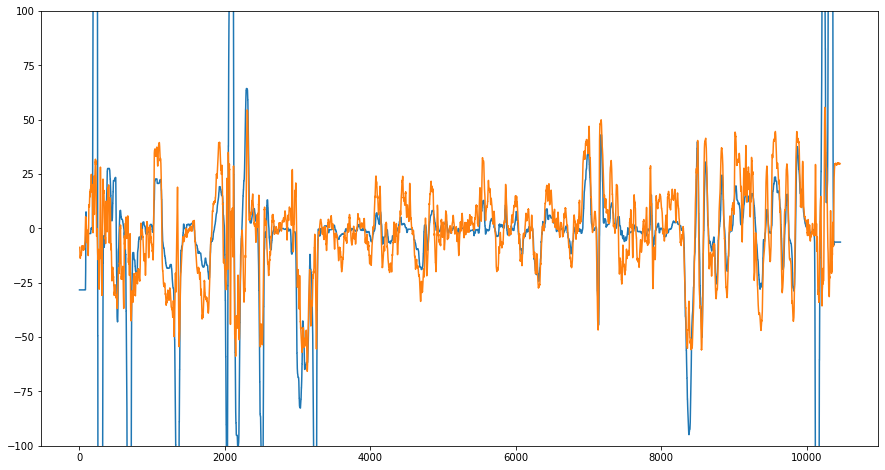

In [19]:
idxs = np.linspace(0, len(ground_truth), len(ground_truth))

plt.figure(figsize=(15,8))
plt.plot(idxs, ground_truth)
#plt.show()
#plt.plot(idxs, predictions_list)

plt.ylim(-100,100)
smooth_idxs = idxs[4:-4]
smooth = running_mean(predictions_list, 9)
plt.plot(smooth_idxs, smooth)

super_smooth_idxs = idxs[20:-20]
super_smooth = running_mean(predictions_list, 41)
#plt.plot(super_smooth_idxs, super_smooth)

get_smoothness_score(super_smooth)




plt.show()

# Test Shift-Verhalten:

In [20]:
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12, 12]
mpl.rcParams['figure.dpi'] = 72

def show_crop(index, shift):
    frame = val_set.get_cropped_frame(index, shift)[0]
    frame_arr = img_to_array(frame)/255
    plt.imshow(frame_arr)
    plt.show()
    
crop_slider = widgets.IntSlider(min=0, max=val_set.get_batch_size()*len(val_set)-1, continuous_update=False)
shift_slider = widgets.IntSlider(min=-100, max=100, continuous_update=False)

interact(show_crop, index=crop_slider, shift = shift_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10463), IntSlider(v…

In [21]:
gui = AutopilotGUI()

predictions_lists = []
render_list = []

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(model_name + '_shift_behaviour.avi',fourcc, 15.0, (848,210))

frames = range(0, val_set.get_batch_size()*len(val_set)-1, 50)

shifts = range(-100,100,4)


for frame_idx in frames:
    predictions_lists.append([])
    for shift in shifts:
        cropped_sample = val_set.get_cropped_frame(frame_idx, shift)
        cropped_frame = cropped_sample[0]
        actual_swa = cropped_sample[1]['steering_wheel_angle']*90
        test_data = np.expand_dims(cropped_frame, axis=0)
        predictions = loaded_model.predict(test_data)
        predicted_swa = predictions[0][0]*90
        predictions_lists[-1].append({'shift':shift, 'actual':actual_swa, 'predicted':predicted_swa})



        gui.set_frame(cropped_frame)
        gui.set_show_overlay(True)
        gui.set_engaged(False)
        gui.set_recording(False)

        gui.set_timestring('')

        velocity = cropped_sample[1]['speed']
        gui.set_velocity(velocity)

        gui.set_actual_swa(actual_swa)
        gui.set_predicted_swa(predicted_swa)

        print("Ground-truth: " +str(actual_swa))
        print("Prediction: " + str(predicted_swa))

        gui.render()
        frame = gui.get_rendered_gui()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        out.write(rgb_frame.astype(np.uint8))
    
out.release()

Ground-truth: -28.3
Prediction: 8.98611567914486
Ground-truth: -28.3
Prediction: 8.066006004810333
Ground-truth: -28.3
Prediction: 5.819668024778366
Ground-truth: -28.3
Prediction: -0.685550244525075
Ground-truth: -28.3
Prediction: 0.6143316440284252
Ground-truth: -28.3
Prediction: 1.8647484853863716
Ground-truth: -28.3
Prediction: 8.810784369707108
Ground-truth: -28.3
Prediction: 2.8021862357854843
Ground-truth: -28.3
Prediction: 16.764376312494278
Ground-truth: -28.3
Prediction: 5.545210316777229
Ground-truth: -28.3
Prediction: 11.758528053760529
Ground-truth: -28.3
Prediction: 14.919316917657852
Ground-truth: -28.3
Prediction: 5.794235989451408
Ground-truth: -28.3
Prediction: 4.625070467591286
Ground-truth: -28.3
Prediction: 8.335158973932266
Ground-truth: -28.3
Prediction: -1.767078023403883
Ground-truth: -28.3
Prediction: -6.123272627592087
Ground-truth: -28.3
Prediction: -9.04267005622387
Ground-truth: -28.3
Prediction: -13.606108725070953
Ground-truth: -28.3
Prediction: -8.05695

Ground-truth: -2.38
Prediction: -17.064007222652435
Ground-truth: -2.38
Prediction: -1.6594461724162102
Ground-truth: -2.38
Prediction: -5.58084849268198
Ground-truth: -2.38
Prediction: -4.838533736765385
Ground-truth: -2.38
Prediction: -6.009308248758316
Ground-truth: -2.38
Prediction: -8.471202626824379
Ground-truth: -2.38
Prediction: 1.6335514560341835
Ground-truth: -2.38
Prediction: -18.86554107069969
Ground-truth: -2.38
Prediction: -9.212823361158371
Ground-truth: -2.38
Prediction: 0.9187901951372623
Ground-truth: -2.38
Prediction: 10.657927840948105
Ground-truth: -2.38
Prediction: 16.090224534273148
Ground-truth: -2.38
Prediction: 16.928684413433075
Ground-truth: -2.38
Prediction: 22.10279032588005
Ground-truth: -2.38
Prediction: 0.8422416262328625
Ground-truth: -2.38
Prediction: -11.957663297653198
Ground-truth: -2.38
Prediction: -8.55840727686882
Ground-truth: -2.38
Prediction: 9.196036085486412
Ground-truth: -2.38
Prediction: 12.999826222658157
Ground-truth: -2.38
Prediction: 

Ground-truth: -386.2300000000001
Prediction: 5.891533121466637
Ground-truth: -386.2300000000001
Prediction: 5.793224796652794
Ground-truth: -386.2300000000001
Prediction: -1.1022423952817917
Ground-truth: -386.2300000000001
Prediction: 1.1058427579700947
Ground-truth: -386.2300000000001
Prediction: -2.9577479884028435
Ground-truth: -386.2300000000001
Prediction: -9.140347391366959
Ground-truth: -386.2300000000001
Prediction: -5.16991663724184
Ground-truth: -386.2300000000001
Prediction: -8.004226014018059
Ground-truth: -386.2300000000001
Prediction: -9.753407835960388
Ground-truth: -386.2300000000001
Prediction: -13.242095410823822
Ground-truth: -386.2300000000001
Prediction: -7.487064599990845
Ground-truth: -386.2300000000001
Prediction: -4.764595292508602
Ground-truth: -386.2300000000001
Prediction: -5.331685021519661
Ground-truth: -386.2300000000001
Prediction: -5.513298735022545
Ground-truth: -386.2300000000001
Prediction: -1.8960676342248917
Ground-truth: -386.2300000000001
Predic

Ground-truth: 3.94
Prediction: -23.022834956645966
Ground-truth: 3.94
Prediction: -22.259258329868317
Ground-truth: 3.94
Prediction: -21.410213112831116
Ground-truth: 3.94
Prediction: -22.991707921028137
Ground-truth: 3.94
Prediction: -23.444354832172394
Ground-truth: 3.94
Prediction: -23.348130583763123
Ground-truth: 3.94
Prediction: -22.68667906522751
Ground-truth: 3.94
Prediction: -21.303915828466415
Ground-truth: 3.94
Prediction: -21.92403718829155
Ground-truth: 3.94
Prediction: -23.862208127975464
Ground-truth: 3.94
Prediction: -25.885870456695557
Ground-truth: 3.94
Prediction: -27.385590076446533
Ground-truth: 3.94
Prediction: -26.464675068855286
Ground-truth: 3.94
Prediction: -23.943634629249573
Ground-truth: 3.94
Prediction: -25.838765501976013
Ground-truth: 3.94
Prediction: -24.474341869354248
Ground-truth: 3.94
Prediction: -24.072922468185425
Ground-truth: 3.94
Prediction: -23.324854373931885
Ground-truth: 3.94
Prediction: -19.98198375105858
Ground-truth: 3.94
Prediction: -21

Ground-truth: 1.8199999999999998
Prediction: -15.823393017053604
Ground-truth: 1.8199999999999998
Prediction: -15.13647124171257
Ground-truth: 1.8199999999999998
Prediction: -14.07824993133545
Ground-truth: 1.8199999999999998
Prediction: -10.482980757951736
Ground-truth: 1.8199999999999998
Prediction: -11.127265468239784
Ground-truth: 1.8199999999999998
Prediction: -9.28287461400032
Ground-truth: 1.8199999999999998
Prediction: -9.742745384573936
Ground-truth: 1.8199999999999998
Prediction: -10.704120844602585
Ground-truth: 1.8199999999999998
Prediction: -10.486215502023697
Ground-truth: 1.8199999999999998
Prediction: -11.675932109355927
Ground-truth: 1.8199999999999998
Prediction: -12.874785661697388
Ground-truth: 1.8199999999999998
Prediction: -11.800422817468643
Ground-truth: 1.8199999999999998
Prediction: -13.84119227528572
Ground-truth: 1.8199999999999998
Prediction: -14.83923152089119
Ground-truth: 1.8199999999999998
Prediction: -13.249175101518631
Ground-truth: 1.8199999999999998

Ground-truth: -13.9
Prediction: -25.505576133728027
Ground-truth: -13.9
Prediction: -22.874431014060974
Ground-truth: -13.9
Prediction: -20.1439006626606
Ground-truth: -13.9
Prediction: -19.76436674594879
Ground-truth: -13.9
Prediction: -22.292985767126083
Ground-truth: -13.9
Prediction: -24.646266102790833
Ground-truth: -13.9
Prediction: -26.412827968597412
Ground-truth: -13.9
Prediction: -27.37297832965851
Ground-truth: -13.9
Prediction: -26.59815788269043
Ground-truth: -13.9
Prediction: -23.74968945980072
Ground-truth: -13.9
Prediction: -22.106265127658844
Ground-truth: -10.89
Prediction: -4.041263200342655
Ground-truth: -10.89
Prediction: -8.309668600559235
Ground-truth: -10.89
Prediction: -10.282838344573975
Ground-truth: -10.89
Prediction: -13.39619368314743
Ground-truth: -10.89
Prediction: -14.812320917844772
Ground-truth: -10.89
Prediction: -16.53349444270134
Ground-truth: -10.89
Prediction: -18.269834518432617
Ground-truth: -10.89
Prediction: -17.918614000082016
Ground-truth: 

Ground-truth: -1.8199999999999998
Prediction: -12.125026434659958
Ground-truth: -1.8199999999999998
Prediction: -12.901783436536789
Ground-truth: -1.8199999999999998
Prediction: -11.779030859470367
Ground-truth: -1.8199999999999998
Prediction: -10.626619085669518
Ground-truth: -1.8199999999999998
Prediction: -9.574587643146515
Ground-truth: -1.8199999999999998
Prediction: -9.658173322677612
Ground-truth: -1.8199999999999998
Prediction: -10.374320447444916
Ground-truth: -1.8199999999999998
Prediction: -9.949153438210487
Ground-truth: -1.8199999999999998
Prediction: -8.740867897868156
Ground-truth: -1.8199999999999998
Prediction: -8.909136280417442
Ground-truth: -1.8199999999999998
Prediction: -9.584239572286606
Ground-truth: -1.8199999999999998
Prediction: -10.328216627240181
Ground-truth: -1.8199999999999998
Prediction: -10.0278340280056
Ground-truth: -1.8199999999999998
Prediction: -9.407669082283974
Ground-truth: -1.8199999999999998
Prediction: -10.20180881023407
Ground-truth: -1.819

Ground-truth: 22.729999999999997
Prediction: 31.96445345878601
Ground-truth: 22.729999999999997
Prediction: 31.40944540500641
Ground-truth: 22.729999999999997
Prediction: 30.57570219039917
Ground-truth: 22.729999999999997
Prediction: 29.570394158363342
Ground-truth: 22.729999999999997
Prediction: 30.431726574897766
Ground-truth: 22.729999999999997
Prediction: 31.584330797195435
Ground-truth: 22.729999999999997
Prediction: 33.026055693626404
Ground-truth: 22.729999999999997
Prediction: 34.063019156455994
Ground-truth: 22.729999999999997
Prediction: 34.50524032115936
Ground-truth: 22.729999999999997
Prediction: 34.10583257675171
Ground-truth: 22.729999999999997
Prediction: 33.133918046951294
Ground-truth: 22.729999999999997
Prediction: 31.878145337104797
Ground-truth: 22.729999999999997
Prediction: 30.099599361419678
Ground-truth: 22.729999999999997
Prediction: 29.42190706729889
Ground-truth: 22.729999999999997
Prediction: 28.958265781402588
Ground-truth: 22.729999999999997
Prediction: 2

Ground-truth: -18.22
Prediction: -37.28429853916168
Ground-truth: -18.22
Prediction: -36.68318331241608
Ground-truth: -18.22
Prediction: -35.914167165756226
Ground-truth: -18.22
Prediction: -35.600541830062866
Ground-truth: -18.22
Prediction: -35.02534210681915
Ground-truth: -18.22
Prediction: -34.87858235836029
Ground-truth: -18.22
Prediction: -35.297173261642456
Ground-truth: -18.22
Prediction: -35.41397273540497
Ground-truth: -18.22
Prediction: -34.78926479816437
Ground-truth: -18.22
Prediction: -33.4665709733963
Ground-truth: -18.22
Prediction: -34.17643368244171
Ground-truth: -16.65
Prediction: -22.053732722997665
Ground-truth: -16.65
Prediction: -22.435051649808884
Ground-truth: -16.65
Prediction: -23.763492107391357
Ground-truth: -16.65
Prediction: -23.988623321056366
Ground-truth: -16.65
Prediction: -23.818257451057434
Ground-truth: -16.65
Prediction: -23.454595506191254
Ground-truth: -16.65
Prediction: -23.570968508720398
Ground-truth: -16.65
Prediction: -24.134355783462524
Gr

Ground-truth: -146.94
Prediction: 37.79501259326935
Ground-truth: -146.94
Prediction: 37.13124632835388
Ground-truth: -10.21
Prediction: -15.567888468503952
Ground-truth: -10.21
Prediction: -17.334368526935577
Ground-truth: -10.21
Prediction: -19.86829698085785
Ground-truth: -10.21
Prediction: -20.364295095205307
Ground-truth: -10.21
Prediction: -19.34564843773842
Ground-truth: -10.21
Prediction: -18.146234303712845
Ground-truth: -10.21
Prediction: -18.26506018638611
Ground-truth: -10.21
Prediction: -20.290490090847015
Ground-truth: -10.21
Prediction: -19.98473033308983
Ground-truth: -10.21
Prediction: -18.474548757076263
Ground-truth: -10.21
Prediction: -19.08138245344162
Ground-truth: -10.21
Prediction: -20.336267352104187
Ground-truth: -10.21
Prediction: -20.50327241420746
Ground-truth: -10.21
Prediction: -21.792293787002563
Ground-truth: -10.21
Prediction: -21.74890100955963
Ground-truth: -10.21
Prediction: -23.276714086532593
Ground-truth: -10.21
Prediction: -24.420188069343567
Gr

Ground-truth: 2.38
Prediction: -0.1708337478339672
Ground-truth: 2.38
Prediction: 0.1619868166744709
Ground-truth: 2.38
Prediction: -2.7381887286901474
Ground-truth: 2.38
Prediction: -4.807189777493477
Ground-truth: 2.38
Prediction: -4.772909469902515
Ground-truth: 2.38
Prediction: -4.371934309601784
Ground-truth: 2.38
Prediction: -2.745370678603649
Ground-truth: 2.38
Prediction: -2.8302686288952827
Ground-truth: 2.38
Prediction: -3.121197447180748
Ground-truth: 2.38
Prediction: -2.6084444113075733
Ground-truth: 2.38
Prediction: -2.9407692700624466
Ground-truth: 2.38
Prediction: -3.8467175513505936
Ground-truth: 2.38
Prediction: -3.3245115727186203
Ground-truth: 2.38
Prediction: -3.619532771408558
Ground-truth: 2.38
Prediction: -3.6191173642873764
Ground-truth: 2.38
Prediction: -4.273170009255409
Ground-truth: 2.38
Prediction: -6.943599432706833
Ground-truth: 2.38
Prediction: -7.921868115663528
Ground-truth: 2.38
Prediction: -5.9456567466259
Ground-truth: 2.38
Prediction: -3.6184843629

Ground-truth: -17.84
Prediction: -33.529404401779175
Ground-truth: -17.84
Prediction: -35.67939877510071
Ground-truth: -17.84
Prediction: -36.07387661933899
Ground-truth: -17.84
Prediction: -35.64759314060211
Ground-truth: -17.84
Prediction: -35.101431012153625
Ground-truth: -17.84
Prediction: -34.585347175598145
Ground-truth: -17.84
Prediction: -34.6802544593811
Ground-truth: -17.84
Prediction: -34.87659752368927
Ground-truth: -17.84
Prediction: -35.788097977638245
Ground-truth: -17.84
Prediction: -36.57865762710571
Ground-truth: -17.84
Prediction: -36.82794213294983
Ground-truth: -17.84
Prediction: -36.68539881706238
Ground-truth: -17.84
Prediction: -36.57722532749176
Ground-truth: -17.84
Prediction: -37.62443482875824
Ground-truth: -17.84
Prediction: -39.07184064388275
Ground-truth: -17.84
Prediction: -40.17356872558594
Ground-truth: -17.84
Prediction: -40.420825481414795
Ground-truth: -17.84
Prediction: -41.55734181404114
Ground-truth: -17.84
Prediction: -41.207077503204346
Ground-

Ground-truth: -0.94
Prediction: 12.259765863418579
Ground-truth: -0.94
Prediction: 12.231876254081726
Ground-truth: -0.94
Prediction: 12.428671270608902
Ground-truth: -0.94
Prediction: 13.19091483950615
Ground-truth: -0.94
Prediction: 11.912226676940918
Ground-truth: -0.94
Prediction: 13.183005005121231
Ground-truth: -0.94
Prediction: 13.779893070459366
Ground-truth: -0.94
Prediction: 11.499389111995697
Ground-truth: -0.94
Prediction: 10.219346433877945
Ground-truth: -0.94
Prediction: 10.966693013906479
Ground-truth: -0.94
Prediction: 11.939782351255417
Ground-truth: -0.94
Prediction: 12.9348523914814
Ground-truth: -0.94
Prediction: 14.977247267961502
Ground-truth: -0.94
Prediction: 15.705497860908508
Ground-truth: -0.94
Prediction: 16.70267477631569
Ground-truth: -0.94
Prediction: 17.97479420900345
Ground-truth: -0.94
Prediction: 16.575720459222794
Ground-truth: -0.94
Prediction: 19.16911080479622
Ground-truth: -0.94
Prediction: 18.805330842733383
Ground-truth: -0.94
Prediction: 21.10

Ground-truth: -12.08
Prediction: -39.06759202480316
Ground-truth: -12.08
Prediction: -36.39444351196289
Ground-truth: -12.08
Prediction: -37.600584626197815
Ground-truth: -12.08
Prediction: -40.56468844413757
Ground-truth: -12.08
Prediction: -42.83716320991516
Ground-truth: -12.08
Prediction: -41.60005867481232
Ground-truth: -12.08
Prediction: -40.69753289222717
Ground-truth: -12.08
Prediction: -40.49965023994446
Ground-truth: -12.08
Prediction: -36.91659450531006
Ground-truth: -12.08
Prediction: -34.77551579475403
Ground-truth: -12.08
Prediction: -35.95999002456665
Ground-truth: -12.08
Prediction: -35.79038321971893
Ground-truth: -12.08
Prediction: -33.502464294433594
Ground-truth: 65.99
Prediction: 20.03872185945511
Ground-truth: 65.99
Prediction: 21.67586848139763
Ground-truth: 65.99
Prediction: 26.27106249332428
Ground-truth: 65.99
Prediction: 24.39867675304413
Ground-truth: 65.99
Prediction: 28.195021748542786
Ground-truth: 65.99
Prediction: 31.48760497570038
Ground-truth: 65.99
P

Ground-truth: -86.96
Prediction: -41.8019700050354
Ground-truth: -86.96
Prediction: -41.59673273563385
Ground-truth: -62.48
Prediction: -33.06841313838959
Ground-truth: -62.48
Prediction: -32.96846866607666
Ground-truth: -62.48
Prediction: -34.00725066661835
Ground-truth: -62.48
Prediction: -35.30026316642761
Ground-truth: -62.48
Prediction: -35.04032492637634
Ground-truth: -62.48
Prediction: -36.440759897232056
Ground-truth: -62.48
Prediction: -32.11246311664581
Ground-truth: -62.48
Prediction: -31.041215658187866
Ground-truth: -62.48
Prediction: -27.40740716457367
Ground-truth: -62.48
Prediction: -27.784788608551025
Ground-truth: -62.48
Prediction: -19.128212481737137
Ground-truth: -62.48
Prediction: -18.96965503692627
Ground-truth: -62.48
Prediction: -16.304779797792435
Ground-truth: -62.48
Prediction: -21.695916652679443
Ground-truth: -62.48
Prediction: -32.17364430427551
Ground-truth: -62.48
Prediction: -38.425288796424866
Ground-truth: -62.48
Prediction: -41.06947481632233
Ground

Ground-truth: 2.5
Prediction: 8.26521098613739
Ground-truth: 2.5
Prediction: 7.835638448596001
Ground-truth: 2.5
Prediction: 7.198137044906616
Ground-truth: 2.5
Prediction: 5.80367736518383
Ground-truth: 2.5
Prediction: 4.301126003265381
Ground-truth: 2.5
Prediction: 5.394836962223053
Ground-truth: 2.5
Prediction: 5.179782807826996
Ground-truth: 2.5
Prediction: 6.53793141245842
Ground-truth: 2.5
Prediction: 5.91644749045372
Ground-truth: 2.5
Prediction: 3.730114884674549
Ground-truth: 2.5
Prediction: 2.2399456053972244
Ground-truth: 2.5
Prediction: 3.25769305229187
Ground-truth: 2.5
Prediction: 6.101272478699684
Ground-truth: 2.5
Prediction: 6.665318235754967
Ground-truth: 2.5
Prediction: 7.146946415305138
Ground-truth: 2.5
Prediction: 6.985403001308441
Ground-truth: 2.5
Prediction: 7.565926238894463
Ground-truth: 2.5
Prediction: 8.021390810608864
Ground-truth: 2.5
Prediction: 9.494023472070694
Ground-truth: 2.5
Prediction: 7.573646977543831
Ground-truth: 2.5
Prediction: 7.129322290420

Ground-truth: -105.18
Prediction: -45.63827455043793
Ground-truth: -105.18
Prediction: -43.97029459476471
Ground-truth: -105.18
Prediction: -44.44748103618622
Ground-truth: -105.18
Prediction: -46.47534906864166
Ground-truth: -105.18
Prediction: -48.27970862388611
Ground-truth: -105.18
Prediction: -47.68546521663666
Ground-truth: -105.18
Prediction: -46.502482295036316
Ground-truth: -105.18
Prediction: -47.96823978424072
Ground-truth: -105.18
Prediction: -48.79194617271423
Ground-truth: -105.18
Prediction: -48.67966890335083
Ground-truth: -105.18
Prediction: -45.876755118370056
Ground-truth: -105.18
Prediction: -47.441609501838684
Ground-truth: -105.18
Prediction: -49.227381348609924
Ground-truth: -105.18
Prediction: -46.583173871040344
Ground-truth: -105.18
Prediction: -41.91714942455292
Ground-truth: -105.18
Prediction: -41.18967533111572
Ground-truth: -105.18
Prediction: -41.339659094810486
Ground-truth: -105.18
Prediction: -44.84299957752228
Ground-truth: -105.18
Prediction: -47.65

Ground-truth: -3.51
Prediction: 4.1521815955638885
Ground-truth: -3.51
Prediction: 7.569124773144722
Ground-truth: -3.51
Prediction: 8.93165409564972
Ground-truth: -3.51
Prediction: 12.019606232643127
Ground-truth: -3.51
Prediction: 14.416566342115402
Ground-truth: -3.51
Prediction: 14.82803463935852
Ground-truth: -3.51
Prediction: 10.528837144374847
Ground-truth: -1.75
Prediction: 25.707932710647583
Ground-truth: -1.75
Prediction: 23.94593060016632
Ground-truth: -1.75
Prediction: 21.77458181977272
Ground-truth: -1.75
Prediction: 22.432093173265457
Ground-truth: -1.75
Prediction: 22.11626037955284
Ground-truth: -1.75
Prediction: 23.358119130134583
Ground-truth: -1.75
Prediction: 23.108335733413696
Ground-truth: -1.75
Prediction: 26.039544939994812
Ground-truth: -1.75
Prediction: 27.25507378578186
Ground-truth: -1.75
Prediction: 26.037281155586243
Ground-truth: -1.75
Prediction: 23.940598368644714
Ground-truth: -1.75
Prediction: 19.507728964090347
Ground-truth: -1.75
Prediction: 22.9410

Ground-truth: 0.13
Prediction: 13.522555232048035
Ground-truth: 0.13
Prediction: 11.75782397389412
Ground-truth: 0.13
Prediction: 11.829322278499603
Ground-truth: 0.13
Prediction: 12.93095514178276
Ground-truth: 0.13
Prediction: 12.401146441698074
Ground-truth: 0.13
Prediction: 11.081604212522507
Ground-truth: 0.13
Prediction: 9.751937985420227
Ground-truth: 0.13
Prediction: 7.86434143781662
Ground-truth: 0.13
Prediction: 6.961918920278549
Ground-truth: 0.13
Prediction: 8.660179674625397
Ground-truth: 0.13
Prediction: 8.957975283265114
Ground-truth: 0.13
Prediction: 9.534762874245644
Ground-truth: 0.13
Prediction: 7.180989012122154
Ground-truth: 0.13
Prediction: 3.808640241622925
Ground-truth: 0.13
Prediction: 1.076188087463379
Ground-truth: 0.13
Prediction: -0.8094025030732155
Ground-truth: 0.13
Prediction: -1.7477396316826344
Ground-truth: 0.13
Prediction: -1.2533104419708252
Ground-truth: 0.13
Prediction: -2.8761327266693115
Ground-truth: 0.13
Prediction: -1.8696983344852924
Ground-

Ground-truth: -66.99
Prediction: -25.508193969726562
Ground-truth: -66.99
Prediction: -30.21736979484558
Ground-truth: -66.99
Prediction: -28.385721445083618
Ground-truth: -66.99
Prediction: -27.533106207847595
Ground-truth: -66.99
Prediction: -24.87903356552124
Ground-truth: -66.99
Prediction: -25.294223427772522
Ground-truth: -66.99
Prediction: -26.137778162956238
Ground-truth: -66.99
Prediction: -26.7162823677063
Ground-truth: -66.99
Prediction: -24.913934469223022
Ground-truth: -66.99
Prediction: -25.598487854003906
Ground-truth: -66.99
Prediction: -28.795595169067383
Ground-truth: -66.99
Prediction: -32.0171320438385
Ground-truth: -66.99
Prediction: -29.793816804885864
Ground-truth: -66.99
Prediction: -28.05237650871277
Ground-truth: -66.99
Prediction: -28.547539114952087
Ground-truth: -66.99
Prediction: -29.300225973129272
Ground-truth: -66.99
Prediction: -24.785306453704834
Ground-truth: -66.99
Prediction: -25.926666855812073
Ground-truth: -66.99
Prediction: -25.59514045715332
G

Ground-truth: -44.58
Prediction: -35.84043860435486
Ground-truth: -44.58
Prediction: -35.21185755729675
Ground-truth: -44.58
Prediction: -35.78902065753937
Ground-truth: -44.58
Prediction: -36.0541033744812
Ground-truth: -44.58
Prediction: -36.27687692642212
Ground-truth: -44.58
Prediction: -36.4656937122345
Ground-truth: -44.58
Prediction: -36.66271269321442
Ground-truth: -44.58
Prediction: -37.42175102233887
Ground-truth: -44.58
Prediction: -36.16120398044586
Ground-truth: -44.58
Prediction: -34.684953689575195
Ground-truth: -44.58
Prediction: -34.096471667289734
Ground-truth: -44.58
Prediction: -35.35830616950989
Ground-truth: -44.58
Prediction: -35.75367987155914
Ground-truth: -44.58
Prediction: -35.94274878501892
Ground-truth: -44.58
Prediction: -34.12001609802246
Ground-truth: -44.58
Prediction: -32.17847764492035
Ground-truth: -44.58
Prediction: -34.674493074417114
Ground-truth: -44.58
Prediction: -35.72379469871521
Ground-truth: -33.43
Prediction: -28.284725546836853
Ground-tru

Ground-truth: -3.3800000000000003
Prediction: -3.221326991915703
Ground-truth: -3.3800000000000003
Prediction: -1.565538179129362
Ground-truth: -3.3800000000000003
Prediction: -1.3482137862592936
Ground-truth: -3.3800000000000003
Prediction: -2.0648897252976894
Ground-truth: -3.3800000000000003
Prediction: -3.4292545169591904
Ground-truth: -3.3800000000000003
Prediction: -3.983309715986252
Ground-truth: -3.3800000000000003
Prediction: -4.331368580460548
Ground-truth: -3.3800000000000003
Prediction: -5.708686262369156
Ground-truth: -3.3800000000000003
Prediction: -6.299285888671875
Ground-truth: -3.3800000000000003
Prediction: -5.463644340634346
Ground-truth: -3.3800000000000003
Prediction: -5.4585545137524605
Ground-truth: -3.3800000000000003
Prediction: -5.8257318288087845
Ground-truth: -3.3800000000000003
Prediction: -6.906764656305313
Ground-truth: -3.3800000000000003
Prediction: -7.3157210648059845
Ground-truth: -3.3800000000000003
Prediction: -8.413776531815529
Ground-truth: -3.38

Ground-truth: -0.63
Prediction: 3.5405511036515236
Ground-truth: -0.63
Prediction: 2.7715446799993515
Ground-truth: -0.63
Prediction: 3.572469726204872
Ground-truth: -0.63
Prediction: 3.4101467952132225
Ground-truth: -0.63
Prediction: 2.518727034330368
Ground-truth: -0.63
Prediction: 2.3748577013611794
Ground-truth: -0.63
Prediction: 2.4579478427767754
Ground-truth: -0.63
Prediction: 1.6159025207161903
Ground-truth: -0.63
Prediction: 1.1991977132856846
Ground-truth: -0.63
Prediction: 1.9911670312285423
Ground-truth: -0.63
Prediction: 2.686629630625248
Ground-truth: -0.63
Prediction: 2.1567974612116814
Ground-truth: 1.38
Prediction: -1.6029674001038074
Ground-truth: 1.38
Prediction: -2.8515472635626793
Ground-truth: 1.38
Prediction: -2.4668371863663197
Ground-truth: 1.38
Prediction: -2.0173013024032116
Ground-truth: 1.38
Prediction: -1.1987664643675089
Ground-truth: 1.38
Prediction: -2.389248088002205
Ground-truth: 1.38
Prediction: -3.1069093197584152
Ground-truth: 1.38
Prediction: -4.4

Ground-truth: -1.5
Prediction: -5.701005756855011
Ground-truth: -1.5
Prediction: -1.9963235780596733
Ground-truth: -1.5
Prediction: 0.237827617675066
Ground-truth: -1.5
Prediction: 1.5929548814892769
Ground-truth: -1.5
Prediction: 1.4204398915171623
Ground-truth: -1.5
Prediction: -0.7265546824783087
Ground-truth: -1.5
Prediction: -1.7608019895851612
Ground-truth: -1.5
Prediction: -2.561332080513239
Ground-truth: -1.5
Prediction: -2.3245401307940483
Ground-truth: -1.5
Prediction: -2.8834430873394012
Ground-truth: -1.5
Prediction: -6.226453185081482
Ground-truth: -1.5
Prediction: -8.504081815481186
Ground-truth: -1.5
Prediction: -7.914469242095947
Ground-truth: -1.5
Prediction: -6.883542090654373
Ground-truth: -1.5
Prediction: -10.103888735175133
Ground-truth: -1.5
Prediction: -10.81920638680458
Ground-truth: -1.5
Prediction: -10.98752573132515
Ground-truth: -1.5
Prediction: -9.057433605194092
Ground-truth: -1.5
Prediction: -7.369178161025047
Ground-truth: -1.5
Prediction: -7.58193232119

Ground-truth: -0.19000000000000003
Prediction: -8.31428937613964
Ground-truth: -1.31
Prediction: -1.9441292993724346
Ground-truth: -1.31
Prediction: -3.4457695484161377
Ground-truth: -1.31
Prediction: -2.9214660823345184
Ground-truth: -1.31
Prediction: -1.2923527602106333
Ground-truth: -1.31
Prediction: -2.339278534054756
Ground-truth: -1.31
Prediction: -4.899914413690567
Ground-truth: -1.31
Prediction: -5.724348351359367
Ground-truth: -1.31
Prediction: -5.734577625989914
Ground-truth: -1.31
Prediction: -6.361764594912529
Ground-truth: -1.31
Prediction: -5.003257915377617
Ground-truth: -1.31
Prediction: -3.9069539308547974
Ground-truth: -1.31
Prediction: -4.7712092846632
Ground-truth: -1.31
Prediction: -6.408410221338272
Ground-truth: -1.31
Prediction: -7.656112834811211
Ground-truth: -1.31
Prediction: -7.84118726849556
Ground-truth: -1.31
Prediction: -5.8169931918382645
Ground-truth: -1.31
Prediction: -4.253843352198601
Ground-truth: -1.31
Prediction: -2.7434663102030754
Ground-truth:

Ground-truth: 0.19000000000000003
Prediction: 4.660303965210915
Ground-truth: 0.19000000000000003
Prediction: 4.775024056434631
Ground-truth: 0.19000000000000003
Prediction: 3.954663723707199
Ground-truth: 0.19000000000000003
Prediction: 1.4556851238012314
Ground-truth: 0.19000000000000003
Prediction: -1.3083701580762863
Ground-truth: 0.19000000000000003
Prediction: -2.073699440807104
Ground-truth: 0.19000000000000003
Prediction: -0.8545293286442757
Ground-truth: 0.19000000000000003
Prediction: -0.6814921461045742
Ground-truth: 0.19000000000000003
Prediction: -2.503611110150814
Ground-truth: 0.19000000000000003
Prediction: -3.2705770432949066
Ground-truth: -1.5
Prediction: -8.188770040869713
Ground-truth: -1.5
Prediction: -7.657127380371094
Ground-truth: -1.5
Prediction: -4.220370724797249
Ground-truth: -1.5
Prediction: -8.247967064380646
Ground-truth: -1.5
Prediction: -14.23323467373848
Ground-truth: -1.5
Prediction: -13.2322758436203
Ground-truth: -1.5
Prediction: -11.038005575537682

Ground-truth: 4.88
Prediction: 7.050394266843796
Ground-truth: 4.88
Prediction: 8.133478984236717
Ground-truth: 4.88
Prediction: 10.099483877420425
Ground-truth: 4.88
Prediction: 11.576678305864334
Ground-truth: 4.88
Prediction: 12.875216156244278
Ground-truth: 4.88
Prediction: 15.644768625497818
Ground-truth: 4.88
Prediction: 16.921446472406387
Ground-truth: 4.88
Prediction: 16.506970077753067
Ground-truth: 4.88
Prediction: 16.446289122104645
Ground-truth: 4.88
Prediction: 16.986481994390488
Ground-truth: 4.88
Prediction: 17.08507463335991
Ground-truth: 4.88
Prediction: 16.637694239616394
Ground-truth: 4.88
Prediction: 16.28655955195427
Ground-truth: 4.88
Prediction: 16.153869330883026
Ground-truth: 4.88
Prediction: 14.943771958351135
Ground-truth: 4.88
Prediction: 13.840683996677399
Ground-truth: 4.88
Prediction: 12.174057215452194
Ground-truth: 4.88
Prediction: 11.837800741195679
Ground-truth: 4.88
Prediction: 11.408438086509705
Ground-truth: 4.88
Prediction: 11.992619186639786
Grou

Ground-truth: -6.39
Prediction: -15.382272899150848
Ground-truth: -6.39
Prediction: -16.545339077711105
Ground-truth: -6.39
Prediction: -17.592696100473404
Ground-truth: -6.39
Prediction: -17.010462284088135
Ground-truth: -6.39
Prediction: -15.956348776817322
Ground-truth: -6.39
Prediction: -16.02110132575035
Ground-truth: -6.39
Prediction: -17.353343814611435
Ground-truth: -6.39
Prediction: -18.907631635665894
Ground-truth: -6.39
Prediction: -18.779635280370712
Ground-truth: -6.39
Prediction: -19.806634336709976
Ground-truth: -6.39
Prediction: -20.77488899230957
Ground-truth: -6.39
Prediction: -19.9917671084404
Ground-truth: -6.39
Prediction: -18.978522419929504
Ground-truth: -6.39
Prediction: -18.35966169834137
Ground-truth: -6.39
Prediction: -18.561323583126068
Ground-truth: -6.39
Prediction: -21.363059878349304
Ground-truth: -6.39
Prediction: -23.893946707248688
Ground-truth: -6.39
Prediction: -22.44860753417015
Ground-truth: -6.39
Prediction: -22.174920290708542
Ground-truth: -6.3

Ground-truth: 3.0699999999999994
Prediction: -2.4652960896492004
Ground-truth: 3.0699999999999994
Prediction: -5.362569987773895
Ground-truth: 3.0699999999999994
Prediction: -7.411811202764511
Ground-truth: 3.0699999999999994
Prediction: -8.381274864077568
Ground-truth: 3.0699999999999994
Prediction: -8.54713261127472
Ground-truth: 3.0699999999999994
Prediction: -9.665197357535362
Ground-truth: 3.0699999999999994
Prediction: -6.753584370017052
Ground-truth: 3.0699999999999994
Prediction: -3.5062406212091446
Ground-truth: 3.0699999999999994
Prediction: -1.2950524874031544
Ground-truth: 3.0699999999999994
Prediction: 1.1291871964931488
Ground-truth: 3.0699999999999994
Prediction: 4.5238760858774185
Ground-truth: 3.0699999999999994
Prediction: 5.412123128771782
Ground-truth: 3.0699999999999994
Prediction: 5.488429963588715
Ground-truth: 3.0699999999999994
Prediction: 4.657849073410034
Ground-truth: 3.0699999999999994
Prediction: -3.6807002127170563
Ground-truth: 3.0699999999999994
Predict

Ground-truth: -0.38000000000000006
Prediction: 6.410749778151512
Ground-truth: -0.38000000000000006
Prediction: 8.867687433958054
Ground-truth: -0.38000000000000006
Prediction: 10.611070990562439
Ground-truth: -0.38000000000000006
Prediction: 11.807760000228882
Ground-truth: -0.38000000000000006
Prediction: 11.92340075969696
Ground-truth: -0.38000000000000006
Prediction: 13.595052659511566
Ground-truth: -0.38000000000000006
Prediction: 13.724846094846725
Ground-truth: -0.38000000000000006
Prediction: 12.642487585544586
Ground-truth: -0.38000000000000006
Prediction: 13.877521455287933
Ground-truth: -0.38000000000000006
Prediction: 12.847551852464676
Ground-truth: -0.38000000000000006
Prediction: 12.736747115850449
Ground-truth: -0.38000000000000006
Prediction: 11.136102676391602
Ground-truth: -0.38000000000000006
Prediction: 8.348561972379684
Ground-truth: -0.38000000000000006
Prediction: 6.017497703433037
Ground-truth: -0.38000000000000006
Prediction: 4.744173958897591
Ground-truth: -0

Ground-truth: -18.91
Prediction: -23.24197143316269
Ground-truth: -18.91
Prediction: -23.676384687423706
Ground-truth: -18.91
Prediction: -21.268735975027084
Ground-truth: -18.91
Prediction: -18.20413649082184
Ground-truth: -18.91
Prediction: -17.99873024225235
Ground-truth: -18.91
Prediction: -18.280300498008728
Ground-truth: -18.91
Prediction: -18.465798050165176
Ground-truth: -18.91
Prediction: -17.71298512816429
Ground-truth: -18.91
Prediction: -17.227121740579605
Ground-truth: -18.91
Prediction: -16.116887032985687
Ground-truth: -18.91
Prediction: -17.385366708040237
Ground-truth: -18.91
Prediction: -17.598399817943573
Ground-truth: -18.91
Prediction: -17.589292377233505
Ground-truth: -18.91
Prediction: -17.5002658367157
Ground-truth: -18.91
Prediction: -17.447867542505264
Ground-truth: -18.91
Prediction: -18.08483585715294
Ground-truth: -18.91
Prediction: -17.314927875995636
Ground-truth: -18.91
Prediction: -15.040092766284943
Ground-truth: -18.91
Prediction: -11.677643358707428


Ground-truth: 8.08
Prediction: 12.899661809206009
Ground-truth: 8.08
Prediction: 8.99195283651352
Ground-truth: 8.08
Prediction: 8.548131734132767
Ground-truth: 8.08
Prediction: 7.0758504420518875
Ground-truth: 1.0
Prediction: -11.827294528484344
Ground-truth: 1.0
Prediction: -12.627664357423782
Ground-truth: 1.0
Prediction: -12.498717159032822
Ground-truth: 1.0
Prediction: -13.144707083702087
Ground-truth: 1.0
Prediction: -14.645357429981232
Ground-truth: 1.0
Prediction: -15.640915632247925
Ground-truth: 1.0
Prediction: -16.275723427534103
Ground-truth: 1.0
Prediction: -17.958593666553497
Ground-truth: 1.0
Prediction: -18.71271014213562
Ground-truth: 1.0
Prediction: -19.395998865365982
Ground-truth: 1.0
Prediction: -19.500198662281036
Ground-truth: 1.0
Prediction: -18.906926214694977
Ground-truth: 1.0
Prediction: -18.75788390636444
Ground-truth: 1.0
Prediction: -19.205358177423477
Ground-truth: 1.0
Prediction: -18.411217778921127
Ground-truth: 1.0
Prediction: -17.188123762607574
Groun

Ground-truth: 2.32
Prediction: 3.874332569539547
Ground-truth: 2.32
Prediction: 4.326806142926216
Ground-truth: 2.32
Prediction: 3.880819156765938
Ground-truth: 2.32
Prediction: 3.1676432490348816
Ground-truth: 2.32
Prediction: 2.8975173085927963
Ground-truth: 2.32
Prediction: 3.119203895330429
Ground-truth: 2.32
Prediction: 3.8585155829787254
Ground-truth: 2.32
Prediction: 3.6096669360995293
Ground-truth: 2.32
Prediction: 3.7365686148405075
Ground-truth: 2.32
Prediction: 5.152853429317474
Ground-truth: 2.32
Prediction: 5.153210163116455
Ground-truth: 2.32
Prediction: 5.166139751672745
Ground-truth: 2.32
Prediction: 4.771164357662201
Ground-truth: 2.32
Prediction: 3.9783070608973503
Ground-truth: 2.32
Prediction: 3.586672693490982
Ground-truth: 2.32
Prediction: 3.9772995561361313
Ground-truth: 2.32
Prediction: 4.5236776024103165
Ground-truth: 2.32
Prediction: 5.441961362957954
Ground-truth: 2.32
Prediction: 5.5391062796115875
Ground-truth: 2.32
Prediction: 5.2797359973192215
Ground-tru

Ground-truth: -1.75
Prediction: -2.4814899265766144
Ground-truth: -1.75
Prediction: -4.43401001393795
Ground-truth: -1.75
Prediction: -2.1216997504234314
Ground-truth: -1.75
Prediction: 1.0250787623226643
Ground-truth: -1.75
Prediction: 4.188489988446236
Ground-truth: -1.75
Prediction: 2.3665837571024895
Ground-truth: -1.75
Prediction: 0.05789849907159805
Ground-truth: -1.75
Prediction: -0.9776217676699162
Ground-truth: -1.75
Prediction: 0.0324455089867115
Ground-truth: -1.75
Prediction: -1.4259214885532856
Ground-truth: -1.75
Prediction: -2.4010638892650604
Ground-truth: -1.75
Prediction: 1.6734637320041656
Ground-truth: -1.75
Prediction: 5.448330268263817
Ground-truth: -1.75
Prediction: 5.548451766371727
Ground-truth: -1.75
Prediction: 4.287814870476723
Ground-truth: -1.75
Prediction: 2.368163578212261
Ground-truth: -1.75
Prediction: 3.8543491065502167
Ground-truth: -1.75
Prediction: 0.7197932526469231
Ground-truth: -1.75
Prediction: -0.6845907680690289
Ground-truth: -1.75
Prediction

Ground-truth: -1.19
Prediction: 3.447965942323208
Ground-truth: -1.19
Prediction: 4.09831278026104
Ground-truth: -1.19
Prediction: 8.371150195598602
Ground-truth: -1.19
Prediction: 9.54473465681076
Ground-truth: -1.19
Prediction: 5.022107809782028
Ground-truth: -1.19
Prediction: 4.925778955221176
Ground-truth: -1.19
Prediction: 3.0737025663256645
Ground-truth: -1.19
Prediction: -0.38905374705791473
Ground-truth: -1.19
Prediction: -0.6097714696079493
Ground-truth: -1.19
Prediction: -0.43151093646883965
Ground-truth: -1.0
Prediction: 7.593036666512489
Ground-truth: -1.0
Prediction: 7.0948029309511185
Ground-truth: -1.0
Prediction: 6.757342144846916
Ground-truth: -1.0
Prediction: 6.797549799084663
Ground-truth: -1.0
Prediction: 7.155044004321098
Ground-truth: -1.0
Prediction: 7.079388275742531
Ground-truth: -1.0
Prediction: 7.022233083844185
Ground-truth: -1.0
Prediction: 6.726427674293518
Ground-truth: -1.0
Prediction: 5.555945858359337
Ground-truth: -1.0
Prediction: 5.085863247513771
Gr

Ground-truth: 12.709999999999999
Prediction: 30.311579704284668
Ground-truth: 12.709999999999999
Prediction: 28.40314507484436
Ground-truth: 12.709999999999999
Prediction: 27.165053486824036
Ground-truth: 12.709999999999999
Prediction: 26.422671675682068
Ground-truth: 12.709999999999999
Prediction: 26.288695335388184
Ground-truth: 12.709999999999999
Prediction: 26.35516583919525
Ground-truth: 12.709999999999999
Prediction: 25.235783457756042
Ground-truth: 12.709999999999999
Prediction: 26.30974531173706
Ground-truth: 12.709999999999999
Prediction: 25.455703139305115
Ground-truth: 12.709999999999999
Prediction: 25.22332727909088
Ground-truth: 12.709999999999999
Prediction: 26.174106001853943
Ground-truth: 12.709999999999999
Prediction: 28.190853595733643
Ground-truth: 12.709999999999999
Prediction: 29.170004725456238
Ground-truth: 12.709999999999999
Prediction: 29.715072512626648
Ground-truth: 12.709999999999999
Prediction: 29.181570410728455
Ground-truth: 12.709999999999999
Prediction:

Ground-truth: 1.19
Prediction: 3.3281372487545013
Ground-truth: 1.19
Prediction: 3.2650506868958473
Ground-truth: 1.19
Prediction: 2.767995446920395
Ground-truth: 1.19
Prediction: 3.9716756343841553
Ground-truth: 1.19
Prediction: 4.02826052159071
Ground-truth: 1.19
Prediction: 3.3660955354571342
Ground-truth: 1.19
Prediction: 3.4486331418156624
Ground-truth: 1.19
Prediction: 3.0850590392947197
Ground-truth: 1.19
Prediction: 2.5614210963249207
Ground-truth: 1.19
Prediction: 3.6906029284000397
Ground-truth: 1.19
Prediction: 3.8939177244901657
Ground-truth: 1.19
Prediction: 3.5010532289743423
Ground-truth: 1.19
Prediction: 4.723158180713654
Ground-truth: 1.19
Prediction: 5.679833069443703
Ground-truth: 1.19
Prediction: 6.2770141661167145
Ground-truth: 1.19
Prediction: 6.753009036183357
Ground-truth: 1.19
Prediction: 6.153171211481094
Ground-truth: 1.19
Prediction: 5.940373465418816
Ground-truth: 1.19
Prediction: 4.726331904530525
Ground-truth: 1.19
Prediction: 4.661977663636208
Ground-tru

Ground-truth: 8.58
Prediction: -5.75915202498436
Ground-truth: 8.58
Prediction: -2.717526163905859
Ground-truth: 8.58
Prediction: -3.6200769245624542
Ground-truth: 8.58
Prediction: -2.130847591906786
Ground-truth: 8.58
Prediction: -0.3283504955470562
Ground-truth: 8.58
Prediction: -0.97293796017766
Ground-truth: 8.58
Prediction: -0.24555020034313202
Ground-truth: 8.58
Prediction: -0.3321322426199913
Ground-truth: 8.58
Prediction: 0.38892852142453194
Ground-truth: 8.58
Prediction: 0.4314492456614971
Ground-truth: 8.58
Prediction: -3.0057793110609055
Ground-truth: 8.58
Prediction: -9.661234393715858
Ground-truth: 8.58
Prediction: -10.499528646469116
Ground-truth: 8.58
Prediction: -10.374805927276611
Ground-truth: 8.58
Prediction: -8.675531297922134
Ground-truth: 8.58
Prediction: -1.9517075456678867
Ground-truth: 8.58
Prediction: 0.3273198567330837
Ground-truth: 8.58
Prediction: 0.62507389113307
Ground-truth: 8.58
Prediction: 1.5836908668279648
Ground-truth: 8.58
Prediction: 3.06741613894

Ground-truth: 5.51
Prediction: 0.9062426537275314
Ground-truth: 5.51
Prediction: 1.7612846195697784
Ground-truth: 5.51
Prediction: 3.1069619581103325
Ground-truth: 5.51
Prediction: 5.195758044719696
Ground-truth: 5.51
Prediction: 7.839916571974754
Ground-truth: 5.51
Prediction: 8.828971087932587
Ground-truth: 5.51
Prediction: 11.468893736600876
Ground-truth: 5.51
Prediction: 14.159298241138458
Ground-truth: 5.51
Prediction: 14.59145575761795
Ground-truth: 5.51
Prediction: 13.209966570138931
Ground-truth: 5.51
Prediction: 10.283185690641403
Ground-truth: 5.51
Prediction: 9.054355099797249
Ground-truth: 5.51
Prediction: 10.199736803770065
Ground-truth: 5.51
Prediction: 12.39632785320282
Ground-truth: 5.51
Prediction: 10.444222837686539
Ground-truth: 5.51
Prediction: 7.827071473002434
Ground-truth: 5.51
Prediction: 9.60543841123581
Ground-truth: 5.51
Prediction: 10.19743949174881
Ground-truth: 5.51
Prediction: 12.538400441408157
Ground-truth: 5.51
Prediction: 14.835909605026245
Ground-tru

Ground-truth: -0.69
Prediction: 3.896283768117428
Ground-truth: -0.69
Prediction: 4.444238618016243
Ground-truth: -0.69
Prediction: 4.431498125195503
Ground-truth: -0.69
Prediction: 4.17309544980526
Ground-truth: -0.69
Prediction: 4.4143614917993546
Ground-truth: -0.69
Prediction: 4.321460500359535
Ground-truth: -0.69
Prediction: 2.642589434981346
Ground-truth: -0.69
Prediction: 2.267911322414875
Ground-truth: -0.69
Prediction: 2.0284323021769524
Ground-truth: -0.69
Prediction: 1.393607072532177
Ground-truth: 0.13
Prediction: -0.21625603549182415
Ground-truth: 0.13
Prediction: -0.4326079599559307
Ground-truth: 0.13
Prediction: -1.8405221030116081
Ground-truth: 0.13
Prediction: -1.9169980846345425
Ground-truth: 0.13
Prediction: -0.4431617818772793
Ground-truth: 0.13
Prediction: 1.1982743628323078
Ground-truth: 0.13
Prediction: 1.008414700627327
Ground-truth: 0.13
Prediction: -0.23700853809714317
Ground-truth: 0.13
Prediction: -2.1480172500014305
Ground-truth: 0.13
Prediction: -5.7019391

Ground-truth: -6.139999999999999
Prediction: -2.7183514460921288
Ground-truth: -6.139999999999999
Prediction: -4.212549403309822
Ground-truth: -6.139999999999999
Prediction: -4.182730279862881
Ground-truth: -6.139999999999999
Prediction: -2.9583819955587387
Ground-truth: -6.139999999999999
Prediction: -1.4784849062561989
Ground-truth: -6.139999999999999
Prediction: -0.8054492622613907
Ground-truth: -6.139999999999999
Prediction: -1.6947938315570354
Ground-truth: -6.139999999999999
Prediction: -3.2048485055565834
Ground-truth: -6.139999999999999
Prediction: -4.493003189563751
Ground-truth: -6.139999999999999
Prediction: -5.117051303386688
Ground-truth: -6.139999999999999
Prediction: -6.5440334379673
Ground-truth: -6.139999999999999
Prediction: -9.984854310750961
Ground-truth: -6.139999999999999
Prediction: -9.472460523247719
Ground-truth: -6.139999999999999
Prediction: -9.37291368842125
Ground-truth: -6.139999999999999
Prediction: -10.424567610025406
Ground-truth: -6.139999999999999
Pre

Ground-truth: 4.88
Prediction: 19.533331990242004
Ground-truth: 4.88
Prediction: 17.684466540813446
Ground-truth: 4.88
Prediction: 15.978635251522064
Ground-truth: 4.88
Prediction: 15.687127411365509
Ground-truth: 4.88
Prediction: 14.262115359306335
Ground-truth: 4.88
Prediction: 13.779804557561874
Ground-truth: 4.88
Prediction: 14.727474600076675
Ground-truth: 4.88
Prediction: 15.230335146188736
Ground-truth: 4.88
Prediction: 15.591491907835007
Ground-truth: 4.88
Prediction: 15.823288410902023
Ground-truth: 4.88
Prediction: 13.681771159172058
Ground-truth: 4.88
Prediction: 13.764038532972336
Ground-truth: 4.88
Prediction: 10.6699039041996
Ground-truth: 4.88
Prediction: 11.431817561388016
Ground-truth: 4.88
Prediction: 10.747402310371399
Ground-truth: 4.88
Prediction: 10.936032682657242
Ground-truth: 4.88
Prediction: 9.323951974511147
Ground-truth: 4.88
Prediction: 7.980601117014885
Ground-truth: 4.88
Prediction: 9.507070407271385
Ground-truth: 4.88
Prediction: 8.855707347393036
Ground

Ground-truth: -2.07
Prediction: -2.8032264299690723
Ground-truth: -2.07
Prediction: -3.4161338210105896
Ground-truth: -2.07
Prediction: -2.2671006247401237
Ground-truth: -2.07
Prediction: -3.5072068870067596
Ground-truth: -2.07
Prediction: -4.366444833576679
Ground-truth: -2.07
Prediction: -3.4175238758325577
Ground-truth: -2.07
Prediction: -4.1024671867489815
Ground-truth: -2.07
Prediction: -0.9373250138014555
Ground-truth: -2.07
Prediction: -1.0863013565540314
Ground-truth: -2.07
Prediction: -1.648982372134924
Ground-truth: -2.07
Prediction: -2.4075241573154926
Ground-truth: -2.07
Prediction: -3.083032965660095
Ground-truth: -2.07
Prediction: -4.9059876054525375
Ground-truth: -2.07
Prediction: -6.303195208311081
Ground-truth: -2.07
Prediction: -3.77511128783226
Ground-truth: -2.07
Prediction: -2.0997540839016438
Ground-truth: -2.07
Prediction: -3.1157907843589783
Ground-truth: -2.07
Prediction: -5.924077704548836
Ground-truth: -2.07
Prediction: -5.726745575666428
Ground-truth: -2.07


Ground-truth: -1.44
Prediction: 6.829779222607613
Ground-truth: -1.44
Prediction: 7.351161763072014
Ground-truth: -1.44
Prediction: 8.480954468250275
Ground-truth: -1.44
Prediction: 8.567314893007278
Ground-truth: -1.44
Prediction: 8.631132692098618
Ground-truth: -1.44
Prediction: 8.37009608745575
Ground-truth: -1.44
Prediction: 7.627924159169197
Ground-truth: -1.44
Prediction: 8.80883440375328
Ground-truth: -1.44
Prediction: 9.78813037276268
Ground-truth: -1.44
Prediction: 10.96180334687233
Ground-truth: -1.44
Prediction: 11.69589713215828
Ground-truth: -1.44
Prediction: 9.85935240983963
Ground-truth: -1.44
Prediction: 8.557117134332657
Ground-truth: -1.44
Prediction: 7.5519660115242
Ground-truth: -0.88
Prediction: 9.503014907240868
Ground-truth: -0.88
Prediction: 7.069661244750023
Ground-truth: -0.88
Prediction: 6.005838140845299
Ground-truth: -0.88
Prediction: 5.359184369444847
Ground-truth: -0.88
Prediction: 4.658585339784622
Ground-truth: -0.88
Prediction: 3.758821226656437
Ground

Ground-truth: 34.94
Prediction: 40.917715430259705
Ground-truth: 34.94
Prediction: 39.090750217437744
Ground-truth: 34.94
Prediction: 37.396806478500366
Ground-truth: 34.94
Prediction: 37.40851163864136
Ground-truth: 34.94
Prediction: 36.14633917808533
Ground-truth: 34.94
Prediction: 36.54378354549408
Ground-truth: 34.94
Prediction: 37.685734033584595
Ground-truth: 34.94
Prediction: 39.193376898765564
Ground-truth: 34.94
Prediction: 40.275283455848694
Ground-truth: 34.94
Prediction: 40.84224879741669
Ground-truth: 34.94
Prediction: 41.05173468589783
Ground-truth: 34.94
Prediction: 42.23897159099579
Ground-truth: 34.94
Prediction: 42.36154854297638
Ground-truth: 34.94
Prediction: 41.491713523864746
Ground-truth: 34.94
Prediction: 40.51913917064667
Ground-truth: 34.94
Prediction: 40.56604564189911
Ground-truth: 34.94
Prediction: 40.61173975467682
Ground-truth: 34.94
Prediction: 41.66719436645508
Ground-truth: 34.94
Prediction: 40.13431191444397
Ground-truth: 34.94
Prediction: 40.78248381

Ground-truth: -3.8799999999999994
Prediction: 32.74267494678497
Ground-truth: -3.8799999999999994
Prediction: 31.346434950828552
Ground-truth: -3.8799999999999994
Prediction: 30.292981266975403
Ground-truth: -3.8799999999999994
Prediction: 30.341105461120605
Ground-truth: -3.8799999999999994
Prediction: 31.766313314437866
Ground-truth: -3.8799999999999994
Prediction: 33.13105344772339
Ground-truth: -3.8799999999999994
Prediction: 33.36464166641235
Ground-truth: -3.8799999999999994
Prediction: 33.02209675312042
Ground-truth: -3.8799999999999994
Prediction: 34.43911850452423
Ground-truth: -3.8799999999999994
Prediction: 36.47456109523773
Ground-truth: -3.8799999999999994
Prediction: 38.2361501455307
Ground-truth: -3.8799999999999994
Prediction: 38.744654059410095
Ground-truth: -3.8799999999999994
Prediction: 40.02401411533356
Ground-truth: -3.8799999999999994
Prediction: 41.782652735710144
Ground-truth: -3.8799999999999994
Prediction: 41.2397575378418
Ground-truth: -3.8799999999999994
Pr

Ground-truth: 9.14
Prediction: 28.713122606277466
Ground-truth: 9.14
Prediction: 28.927602767944336
Ground-truth: 9.14
Prediction: 29.220736026763916
Ground-truth: 9.14
Prediction: 29.806106686592102
Ground-truth: 9.14
Prediction: 29.922133684158325
Ground-truth: 9.14
Prediction: 29.862030744552612
Ground-truth: 9.14
Prediction: 29.95822012424469
Ground-truth: 9.14
Prediction: 29.051719307899475
Ground-truth: 9.14
Prediction: 28.844942450523376
Ground-truth: 9.14
Prediction: 29.681475162506104
Ground-truth: 9.14
Prediction: 30.01740038394928
Ground-truth: 9.14
Prediction: 30.123916268348694
Ground-truth: 9.14
Prediction: 30.4473477602005
Ground-truth: 9.14
Prediction: 30.460715889930725
Ground-truth: 9.14
Prediction: 30.920451879501343
Ground-truth: 9.14
Prediction: 31.237725019454956
Ground-truth: 9.14
Prediction: 31.054567694664
Ground-truth: 9.14
Prediction: 30.971762537956238
Ground-truth: 9.14
Prediction: 31.811047196388245
Ground-truth: 9.14
Prediction: 31.837236285209656
Ground-

Ground-truth: -2.57
Prediction: -27.929391860961914
Ground-truth: -2.57
Prediction: -27.031195163726807
Ground-truth: -2.57
Prediction: -26.02058172225952
Ground-truth: -2.57
Prediction: -26.327635645866394
Ground-truth: -2.57
Prediction: -26.57415747642517
Ground-truth: -2.57
Prediction: -25.44661045074463
Ground-truth: -2.57
Prediction: -25.115443468093872
Ground-truth: -2.57
Prediction: -24.2573082447052
Ground-truth: -2.57
Prediction: -24.749316573143005
Ground-truth: -2.57
Prediction: -25.357877612113953
Ground-truth: -2.57
Prediction: -26.151092648506165
Ground-truth: -5.32
Prediction: -17.157707512378693
Ground-truth: -5.32
Prediction: -16.78415358066559
Ground-truth: -5.32
Prediction: -16.870968639850616
Ground-truth: -5.32
Prediction: -16.21684893965721
Ground-truth: -5.32
Prediction: -14.572610557079315
Ground-truth: -5.32
Prediction: -14.17365476489067
Ground-truth: -5.32
Prediction: -13.916721940040588
Ground-truth: -5.32
Prediction: -14.958084225654602
Ground-truth: -5.32


Ground-truth: 0.5
Prediction: -1.0780203714966774
Ground-truth: 0.5
Prediction: -0.10061468929052353
Ground-truth: 0.5
Prediction: 0.43694106861948967
Ground-truth: 0.5
Prediction: 1.2189674377441406
Ground-truth: 0.5
Prediction: 2.054104059934616
Ground-truth: 0.5
Prediction: 2.2296110540628433
Ground-truth: 0.5
Prediction: 2.567981779575348
Ground-truth: 0.5
Prediction: 2.060028724372387
Ground-truth: 0.5
Prediction: 1.6425274685025215
Ground-truth: 0.5
Prediction: 1.130442302674055
Ground-truth: 0.5
Prediction: 0.21915340796113014
Ground-truth: 0.5
Prediction: -1.4260160364210606
Ground-truth: 0.5
Prediction: -3.0415016412734985
Ground-truth: 0.5
Prediction: -3.85152205824852
Ground-truth: 0.5
Prediction: -4.354342371225357
Ground-truth: 0.5
Prediction: -4.66022651642561
Ground-truth: 0.5
Prediction: -3.2529542595148087
Ground-truth: 0.5
Prediction: -2.6003027334809303
Ground-truth: 0.5
Prediction: -2.0859824493527412
Ground-truth: 0.5
Prediction: -1.5706930495798588
Ground-truth: 0

Ground-truth: -2.75
Prediction: 9.31433692574501
Ground-truth: -2.75
Prediction: 10.911521315574646
Ground-truth: -2.75
Prediction: 12.475124448537827
Ground-truth: -2.75
Prediction: 13.980598747730255
Ground-truth: -2.75
Prediction: 14.908703416585922
Ground-truth: -2.75
Prediction: 15.965843796730042
Ground-truth: -2.75
Prediction: 15.339871197938919
Ground-truth: -2.75
Prediction: 14.625718295574188
Ground-truth: -2.75
Prediction: 13.950081914663315
Ground-truth: -2.75
Prediction: 12.842851281166077
Ground-truth: -2.75
Prediction: 12.237775772809982
Ground-truth: -2.75
Prediction: 14.112566113471985
Ground-truth: -2.75
Prediction: 12.470964342355728
Ground-truth: -2.75
Prediction: 10.683198273181915
Ground-truth: -2.75
Prediction: 8.58602799475193
Ground-truth: -2.75
Prediction: 9.522344246506691
Ground-truth: -2.75
Prediction: 8.05636614561081
Ground-truth: -2.75
Prediction: 7.953334450721741
Ground-truth: -2.75
Prediction: 10.294471085071564
Ground-truth: -2.75
Prediction: 11.3310

Ground-truth: 1.19
Prediction: 11.52055710554123
Ground-truth: 1.19
Prediction: 11.654442250728607
Ground-truth: 1.19
Prediction: 11.346610486507416
Ground-truth: 1.19
Prediction: 10.477896630764008
Ground-truth: 1.19
Prediction: 10.15728548169136
Ground-truth: 1.19
Prediction: 10.670688450336456
Ground-truth: 1.19
Prediction: 11.106045842170715
Ground-truth: 1.19
Prediction: 10.635681599378586
Ground-truth: 1.19
Prediction: 10.759607702493668
Ground-truth: 1.19
Prediction: 11.420479863882065
Ground-truth: 1.19
Prediction: 11.200994700193405
Ground-truth: 1.19
Prediction: 10.828181058168411
Ground-truth: 1.19
Prediction: 10.021064132452011
Ground-truth: 1.19
Prediction: 11.488566398620605
Ground-truth: 1.19
Prediction: 13.023921847343445
Ground-truth: 1.19
Prediction: 12.229945063591003
Ground-truth: 1.19
Prediction: 11.25942125916481
Ground-truth: 1.19
Prediction: 11.13002747297287
Ground-truth: 1.19
Prediction: 10.268615931272507
Ground-truth: 1.19
Prediction: 10.561340153217316
Grou

Ground-truth: -1.44
Prediction: 7.985851541161537
Ground-truth: -1.44
Prediction: 8.904262036085129
Ground-truth: -1.44
Prediction: 11.5981225669384
Ground-truth: -1.44
Prediction: 17.08713725209236
Ground-truth: 1.5
Prediction: 14.761653989553452
Ground-truth: 1.5
Prediction: 13.974101096391678
Ground-truth: 1.5
Prediction: 15.328053385019302
Ground-truth: 1.5
Prediction: 15.514448136091232
Ground-truth: 1.5
Prediction: 15.585269182920456
Ground-truth: 1.5
Prediction: 14.594274759292603
Ground-truth: 1.5
Prediction: 15.362227410078049
Ground-truth: 1.5
Prediction: 14.704484045505524
Ground-truth: 1.5
Prediction: 12.94078677892685
Ground-truth: 1.5
Prediction: 12.384455054998398
Ground-truth: 1.5
Prediction: 11.598559767007828
Ground-truth: 1.5
Prediction: 12.714476734399796
Ground-truth: 1.5
Prediction: 14.312098324298859
Ground-truth: 1.5
Prediction: 13.895540535449982
Ground-truth: 1.5
Prediction: 13.027872741222382
Ground-truth: 1.5
Prediction: 11.510632932186127
Ground-truth: 1.5


Ground-truth: 1.6900000000000002
Prediction: -0.3219927381724119
Ground-truth: -0.31
Prediction: 8.978665843605995
Ground-truth: -0.31
Prediction: 5.132220536470413
Ground-truth: -0.31
Prediction: 1.9569313153624535
Ground-truth: -0.31
Prediction: 0.4245564714074135
Ground-truth: -0.31
Prediction: -2.0827534049749374
Ground-truth: -0.31
Prediction: -1.1597793828696012
Ground-truth: -0.31
Prediction: -1.3152696378529072
Ground-truth: -0.31
Prediction: 1.0584090650081635
Ground-truth: -0.31
Prediction: 1.1065996438264847
Ground-truth: -0.31
Prediction: 0.8790462277829647
Ground-truth: -0.31
Prediction: -0.8225166611373425
Ground-truth: -0.31
Prediction: -0.4525886569172144
Ground-truth: -0.31
Prediction: 1.1979514919221401
Ground-truth: -0.31
Prediction: 3.3212577179074287
Ground-truth: -0.31
Prediction: 4.45704884827137
Ground-truth: -0.31
Prediction: 4.818265289068222
Ground-truth: -0.31
Prediction: 4.704799801111221
Ground-truth: -0.31
Prediction: 5.583991035819054
Ground-truth: -0.31

Ground-truth: -21.1
Prediction: -23.69278907775879
Ground-truth: -21.1
Prediction: -23.141648769378662
Ground-truth: -21.1
Prediction: -24.199839234352112
Ground-truth: -21.1
Prediction: -23.58686864376068
Ground-truth: -21.1
Prediction: -23.8223397731781
Ground-truth: -21.1
Prediction: -24.322898983955383
Ground-truth: -21.1
Prediction: -24.767743349075317
Ground-truth: -21.1
Prediction: -22.36179918050766
Ground-truth: -21.1
Prediction: -21.676522940397263
Ground-truth: -21.1
Prediction: -20.835478752851486
Ground-truth: -21.1
Prediction: -20.831725001335144
Ground-truth: -21.1
Prediction: -21.898427456617355
Ground-truth: -21.1
Prediction: -27.010971307754517
Ground-truth: -21.1
Prediction: -27.596272230148315
Ground-truth: -21.1
Prediction: -27.504690885543823
Ground-truth: -21.1
Prediction: -25.483217239379883
Ground-truth: -21.1
Prediction: -25.48257887363434
Ground-truth: -21.1
Prediction: -19.808658063411713
Ground-truth: -21.1
Prediction: -17.545062750577927
Ground-truth: -21.

Ground-truth: 23.6
Prediction: 38.75747501850128
Ground-truth: 23.6
Prediction: 39.8635858297348
Ground-truth: 23.6
Prediction: 40.08757710456848
Ground-truth: 23.6
Prediction: 40.29843628406525
Ground-truth: 23.6
Prediction: 40.83590269088745
Ground-truth: 23.6
Prediction: 40.88968098163605
Ground-truth: 23.6
Prediction: 39.94797348976135
Ground-truth: 23.6
Prediction: 40.35746097564697
Ground-truth: 23.6
Prediction: 41.10588848590851
Ground-truth: 23.6
Prediction: 40.62571406364441
Ground-truth: 23.6
Prediction: 41.37145400047302
Ground-truth: 23.6
Prediction: 41.3670551776886
Ground-truth: 23.6
Prediction: 40.94895780086517
Ground-truth: 23.6
Prediction: 40.979856848716736
Ground-truth: 23.6
Prediction: 38.668280839920044
Ground-truth: 23.6
Prediction: 37.0918071269989
Ground-truth: 23.6
Prediction: 36.3713014125824
Ground-truth: 23.6
Prediction: 35.68052530288696
Ground-truth: 23.6
Prediction: 35.47735333442688
Ground-truth: 23.6
Prediction: 35.18343687057495
Ground-truth: 23.6
Pre

Ground-truth: -23.73
Prediction: -21.902743130922318
Ground-truth: -23.73
Prediction: -21.258688420057297
Ground-truth: -23.73
Prediction: -23.564815521240234
Ground-truth: -23.73
Prediction: -24.80764389038086
Ground-truth: -23.73
Prediction: -26.85979127883911
Ground-truth: -23.73
Prediction: -28.25761377811432
Ground-truth: -23.73
Prediction: -24.670636653900146
Ground-truth: -23.73
Prediction: -22.591549158096313
Ground-truth: -23.73
Prediction: -18.272870779037476
Ground-truth: -23.73
Prediction: -16.551783084869385
Ground-truth: -23.73
Prediction: -14.951113164424896
Ground-truth: -23.73
Prediction: -17.007027715444565
Ground-truth: -23.73
Prediction: -16.299297362565994
Ground-truth: -23.73
Prediction: -16.195904910564423
Ground-truth: -23.73
Prediction: -18.263913542032242
Ground-truth: 0.63
Prediction: 9.841785281896591
Ground-truth: 0.63
Prediction: 9.496118947863579
Ground-truth: 0.63
Prediction: 9.442550539970398
Ground-truth: 0.63
Prediction: 8.695947602391243
Ground-truth

Ground-truth: -18.41
Prediction: -22.784957885742188
Ground-truth: -18.41
Prediction: -21.545090675354004
Ground-truth: 0.13
Prediction: -1.765312124043703
Ground-truth: 0.13
Prediction: -1.220657229423523
Ground-truth: 0.13
Prediction: -0.6998522859066725
Ground-truth: 0.13
Prediction: -0.8906943909823895
Ground-truth: 0.13
Prediction: -0.25951134972274303
Ground-truth: 0.13
Prediction: -2.378658391535282
Ground-truth: 0.13
Prediction: -4.77294098585844
Ground-truth: 0.13
Prediction: -3.5536811873316765
Ground-truth: 0.13
Prediction: -3.675033040344715
Ground-truth: 0.13
Prediction: -4.66383408755064
Ground-truth: 0.13
Prediction: -3.423958495259285
Ground-truth: 0.13
Prediction: -1.8899081088602543
Ground-truth: 0.13
Prediction: 0.10976705700159073
Ground-truth: 0.13
Prediction: 0.008783899247646332
Ground-truth: 0.13
Prediction: 1.9571881368756294
Ground-truth: 0.13
Prediction: 3.149765655398369
Ground-truth: 0.13
Prediction: 1.6655190289020538
Ground-truth: 0.13
Prediction: 1.84090

Ground-truth: 1.63
Prediction: 24.53994870185852
Ground-truth: 1.63
Prediction: 19.424454420804977
Ground-truth: 1.63
Prediction: 16.65841296315193
Ground-truth: 1.63
Prediction: 17.746746093034744
Ground-truth: 1.63
Prediction: 17.67160400748253
Ground-truth: 1.63
Prediction: 18.99885892868042
Ground-truth: 1.63
Prediction: 18.208806216716766
Ground-truth: 1.63
Prediction: 17.412581741809845
Ground-truth: 1.63
Prediction: 18.356343805789948
Ground-truth: 1.63
Prediction: 22.24404886364937
Ground-truth: 1.63
Prediction: 22.854475378990173
Ground-truth: 1.63
Prediction: 24.094868302345276
Ground-truth: 1.63
Prediction: 24.275418519973755
Ground-truth: 1.63
Prediction: 22.86155641078949
Ground-truth: 1.63
Prediction: 20.217709690332413
Ground-truth: 1.63
Prediction: 18.665975332260132
Ground-truth: 1.63
Prediction: 16.614839136600494
Ground-truth: 1.63
Prediction: 14.77955237030983
Ground-truth: 1.63
Prediction: 13.67910236120224
Ground-truth: 1.63
Prediction: 15.492684692144394
Ground-t

Ground-truth: 15.97
Prediction: 24.507944583892822
Ground-truth: 15.97
Prediction: 28.25534999370575
Ground-truth: 15.97
Prediction: 31.55571699142456
Ground-truth: 15.97
Prediction: 30.4788476228714
Ground-truth: 15.97
Prediction: 29.363579750061035
Ground-truth: 15.97
Prediction: 29.720066785812378
Ground-truth: 15.97
Prediction: 30.72125494480133
Ground-truth: 15.97
Prediction: 29.77772355079651
Ground-truth: 15.97
Prediction: 30.38491129875183
Ground-truth: 15.97
Prediction: 30.28382420539856
Ground-truth: 15.97
Prediction: 29.559563398361206
Ground-truth: 15.97
Prediction: 31.11875295639038
Ground-truth: 15.97
Prediction: 28.479153513908386
Ground-truth: 15.97
Prediction: 29.903427958488464
Ground-truth: 15.97
Prediction: 31.37944757938385
Ground-truth: 15.97
Prediction: 30.06405472755432
Ground-truth: 15.97
Prediction: 26.7551851272583
Ground-truth: 15.97
Prediction: 23.59061300754547
Ground-truth: 15.97
Prediction: 23.35545301437378
Ground-truth: 15.97
Prediction: 22.09637448191

Ground-truth: -11.08
Prediction: -18.920408338308334
Ground-truth: -11.08
Prediction: -18.085096031427383
Ground-truth: -11.08
Prediction: -18.3131106197834
Ground-truth: -11.08
Prediction: -18.494865149259567
Ground-truth: -11.08
Prediction: -18.628976941108704
Ground-truth: -11.08
Prediction: -18.863754719495773
Ground-truth: -11.08
Prediction: -19.2178975045681
Ground-truth: -11.08
Prediction: -20.212136059999466
Ground-truth: -11.08
Prediction: -20.304623991250992
Ground-truth: -11.08
Prediction: -19.69311386346817
Ground-truth: -11.08
Prediction: -20.065826922655106
Ground-truth: -11.08
Prediction: -21.281418800354004
Ground-truth: -11.08
Prediction: -20.85317462682724
Ground-truth: -11.08
Prediction: -20.048789530992508
Ground-truth: -11.08
Prediction: -20.3582963347435
Ground-truth: -11.08
Prediction: -20.55136039853096
Ground-truth: -11.08
Prediction: -19.482398182153702
Ground-truth: -11.08
Prediction: -18.64538937807083
Ground-truth: -11.08
Prediction: -17.829789966344833
Gro

Ground-truth: 20.6
Prediction: 36.10762417316437
Ground-truth: 20.6
Prediction: 36.74729883670807
Ground-truth: 20.6
Prediction: 37.91864097118378
Ground-truth: 20.6
Prediction: 38.38752329349518
Ground-truth: 20.6
Prediction: 38.640037178993225
Ground-truth: 20.6
Prediction: 38.88042747974396
Ground-truth: 20.6
Prediction: 39.092241525650024
Ground-truth: 20.6
Prediction: 40.058759450912476
Ground-truth: 20.6
Prediction: 40.76523721218109
Ground-truth: 16.47
Prediction: 29.77940797805786
Ground-truth: 16.47
Prediction: 29.515328407287598
Ground-truth: 16.47
Prediction: 29.657211899757385
Ground-truth: 16.47
Prediction: 30.303350687026978
Ground-truth: 16.47
Prediction: 30.892245769500732
Ground-truth: 16.47
Prediction: 32.555097341537476
Ground-truth: 16.47
Prediction: 33.58743667602539
Ground-truth: 16.47
Prediction: 34.294976592063904
Ground-truth: 16.47
Prediction: 34.89315748214722
Ground-truth: 16.47
Prediction: 34.496442675590515
Ground-truth: 16.47
Prediction: 33.36138010025024

Ground-truth: 3.3800000000000003
Prediction: 1.3972149789333344
Ground-truth: 3.3800000000000003
Prediction: 2.876482754945755
Ground-truth: 3.3800000000000003
Prediction: 2.0844076573848724
Ground-truth: 3.3800000000000003
Prediction: -0.74440679512918
Ground-truth: 3.3800000000000003
Prediction: -2.6907438039779663
Ground-truth: 3.3800000000000003
Prediction: -1.2507646065205336
Ground-truth: 3.3800000000000003
Prediction: -1.475400198251009
Ground-truth: 3.3800000000000003
Prediction: -1.306889159604907
Ground-truth: 3.3800000000000003
Prediction: -0.8508303947746754
Ground-truth: 3.3800000000000003
Prediction: -0.8484894968569279
Ground-truth: 3.3800000000000003
Prediction: -0.2287112921476364
Ground-truth: 3.3800000000000003
Prediction: 1.4946690201759338
Ground-truth: 3.3800000000000003
Prediction: 0.9196538664400578
Ground-truth: 3.3800000000000003
Prediction: 0.31177494674921036
Ground-truth: 3.3800000000000003
Prediction: 1.1085943691432476
Ground-truth: 3.3800000000000003
Pre

Ground-truth: 10.33
Prediction: 36.26782715320587
Ground-truth: 10.33
Prediction: 35.23332595825195
Ground-truth: 10.33
Prediction: 34.910425543785095
Ground-truth: 10.33
Prediction: 35.48354923725128
Ground-truth: 10.33
Prediction: 35.81238269805908
Ground-truth: 10.33
Prediction: 37.237027287483215
Ground-truth: 10.33
Prediction: 37.97429144382477
Ground-truth: 23.42
Prediction: 24.507687091827393
Ground-truth: 23.42
Prediction: 22.86428689956665
Ground-truth: 23.42
Prediction: 24.131271243095398
Ground-truth: 23.42
Prediction: 25.437646508216858
Ground-truth: 23.42
Prediction: 27.622187733650208
Ground-truth: 23.42
Prediction: 29.134433269500732
Ground-truth: 23.42
Prediction: 29.325363636016846
Ground-truth: 23.42
Prediction: 29.587876796722412
Ground-truth: 23.42
Prediction: 29.916919469833374
Ground-truth: 23.42
Prediction: 29.354792833328247
Ground-truth: 23.42
Prediction: 28.869768977165222
Ground-truth: 23.42
Prediction: 29.094344973564148
Ground-truth: 23.42
Prediction: 28.30

Ground-truth: -2.25
Prediction: -2.5723041594028473
Ground-truth: -2.25
Prediction: -3.9002182334661484
Ground-truth: -2.25
Prediction: -5.149826891720295
Ground-truth: -2.25
Prediction: -6.69598326086998
Ground-truth: -2.25
Prediction: -8.541327640414238
Ground-truth: -2.25
Prediction: -9.548807591199875
Ground-truth: -2.25
Prediction: -8.435835018754005
Ground-truth: -2.25
Prediction: -9.159896671772003
Ground-truth: -2.25
Prediction: -8.525663539767265
Ground-truth: -2.25
Prediction: -7.998510897159576
Ground-truth: -2.25
Prediction: -6.5030694007873535
Ground-truth: -2.25
Prediction: -6.688161268830299
Ground-truth: -2.25
Prediction: -7.2292158007621765
Ground-truth: -2.25
Prediction: -7.175334244966507
Ground-truth: -2.25
Prediction: -5.236813612282276
Ground-truth: -2.25
Prediction: -2.162446528673172
Ground-truth: -2.25
Prediction: -0.843921946361661
Ground-truth: -2.25
Prediction: -2.316741105169058
Ground-truth: -2.25
Prediction: -2.6405598409473896
Ground-truth: -2.25
Predict

Ground-truth: 34.56
Prediction: -14.254391938447952
Ground-truth: 34.56
Prediction: -13.613555878400803
Ground-truth: 34.56
Prediction: -12.723510414361954
Ground-truth: 34.56
Prediction: -12.831624895334244
Ground-truth: 34.56
Prediction: -12.054158449172974
Ground-truth: 34.56
Prediction: -11.373657882213593
Ground-truth: 34.56
Prediction: -11.995495855808258
Ground-truth: 34.56
Prediction: -11.319317668676376
Ground-truth: 34.56
Prediction: -9.979337006807327
Ground-truth: 34.56
Prediction: -11.664175987243652
Ground-truth: 34.56
Prediction: -12.514159977436066
Ground-truth: 34.56
Prediction: -12.46561735868454
Ground-truth: 34.56
Prediction: -12.577629089355469
Ground-truth: 34.56
Prediction: -14.700094610452652
Ground-truth: 34.56
Prediction: -13.257028609514236
Ground-truth: 34.56
Prediction: -9.657458513975143
Ground-truth: 34.56
Prediction: -7.334781512618065
Ground-truth: 34.56
Prediction: -9.59941752254963
Ground-truth: 34.56
Prediction: -12.606398463249207
Ground-truth: 34.5

Ground-truth: 333.58
Prediction: 10.594910681247711
Ground-truth: 333.58
Prediction: 0.7377023622393608
Ground-truth: 333.58
Prediction: -21.211237460374832
Ground-truth: 333.58
Prediction: -19.702449291944504
Ground-truth: 333.58
Prediction: -28.049195408821106
Ground-truth: 333.58
Prediction: -29.79444980621338
Ground-truth: 333.58
Prediction: -27.09604561328888
Ground-truth: 333.58
Prediction: -22.750928699970245
Ground-truth: 333.58
Prediction: -20.502155274152756
Ground-truth: 333.58
Prediction: -20.655196756124496
Ground-truth: 333.58
Prediction: -25.6780207157135
Ground-truth: 333.58
Prediction: -25.07406771183014
Ground-truth: 333.58
Prediction: -24.93769347667694
Ground-truth: 333.58
Prediction: -21.080491840839386
Ground-truth: 333.58
Prediction: -15.859506279230118
Ground-truth: 333.58
Prediction: -16.554734855890274
Ground-truth: 333.58
Prediction: -22.774666249752045
Ground-truth: 333.58
Prediction: -24.7554749250412
Ground-truth: -6.32
Prediction: -21.473701000213623
Grou

In [22]:
print(predictions_lists)

[[{'shift': -100, 'actual': -28.3, 'predicted': 8.98611567914486}, {'shift': -96, 'actual': -28.3, 'predicted': 8.066006004810333}, {'shift': -92, 'actual': -28.3, 'predicted': 5.819668024778366}, {'shift': -88, 'actual': -28.3, 'predicted': -0.685550244525075}, {'shift': -84, 'actual': -28.3, 'predicted': 0.6143316440284252}, {'shift': -80, 'actual': -28.3, 'predicted': 1.8647484853863716}, {'shift': -76, 'actual': -28.3, 'predicted': 8.810784369707108}, {'shift': -72, 'actual': -28.3, 'predicted': 2.8021862357854843}, {'shift': -68, 'actual': -28.3, 'predicted': 16.764376312494278}, {'shift': -64, 'actual': -28.3, 'predicted': 5.545210316777229}, {'shift': -60, 'actual': -28.3, 'predicted': 11.758528053760529}, {'shift': -56, 'actual': -28.3, 'predicted': 14.919316917657852}, {'shift': -52, 'actual': -28.3, 'predicted': 5.794235989451408}, {'shift': -48, 'actual': -28.3, 'predicted': 4.625070467591286}, {'shift': -44, 'actual': -28.3, 'predicted': 8.335158973932266}, {'shift': -40, '

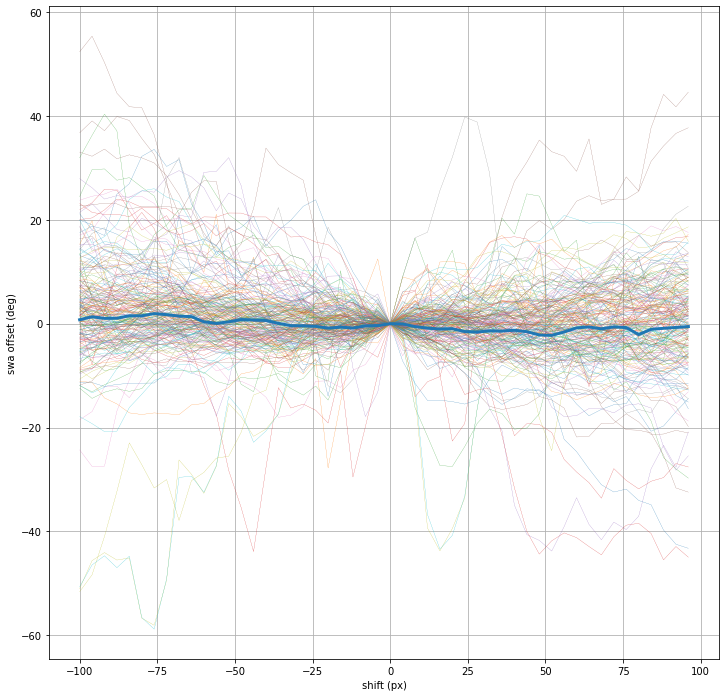

In [23]:
good_predictions = []
for prediction_list in predictions_lists:
    predictions = [element['predicted'] for element in prediction_list]
    ground_truths = [element['actual'] for element in prediction_list]
    base_pred = predictions[len(predictions)//2]
    base_gt = ground_truths[len(ground_truths)//2]
    error = abs(base_gt - base_pred)
    
    linewidth = 0.2
    if error < 10:
        linewidth = 0.2
        good_predictions.append(predictions)
    #plt.plot(shifts, np.asarray(prediction_list), linewidth = 0.5)
    plt.plot(shifts, np.asarray(predictions)-base_pred, linewidth = linewidth)

median_predictions = np.median(good_predictions, axis=0)
plt.plot(shifts, np.asarray(median_predictions)-median_predictions[len(median_predictions)//2], linewidth = 3)

plt.xlabel("shift (px)")
plt.ylabel("swa offset (deg)")
plt.grid()
plt.show()



# Lenkrad Winkelgeschwindigkeit

10464
10463


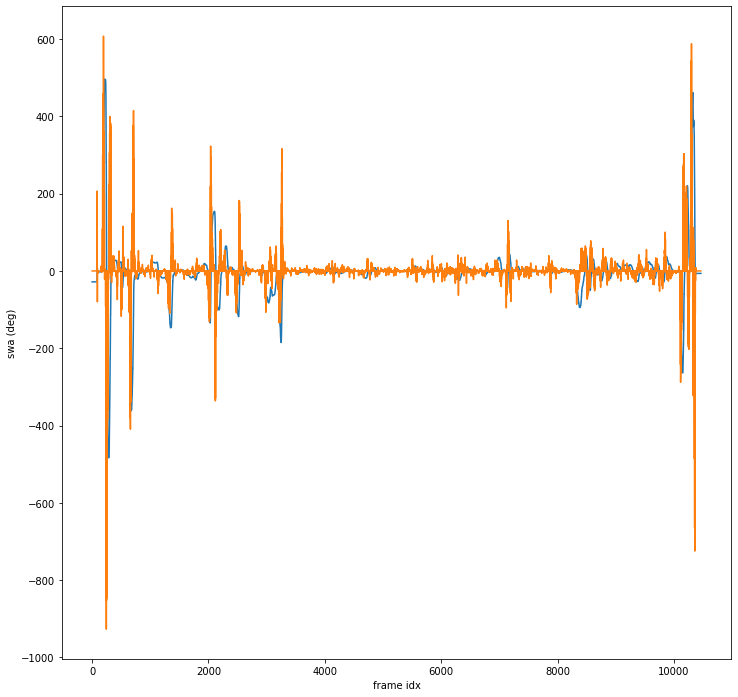

In [24]:
speeds = velocity_list[:]
angles = ground_truth[:] # deg
fps = 15
angular_speed = np.diff(angles)*fps # deg/s


idxs = range(1, len(angles)+1)
print(len(angles))
#print(angles)
print(len(angular_speed))
#print(angular_speed)

plt.plot(idxs, angles)
plt.plot(idxs[:len(angular_speed)], angular_speed)
plt.xlabel("frame idx")
plt.ylabel("swa (deg)")
plt.show()


In [25]:
speeds = np.asarray(speeds)
abs_angles = abs(np.asarray(angles))
abs_angular_speed = abs(angular_speed)

In [26]:
# get indices where abs(swa) > 45
invalid_angle_indxs = np.argwhere(abs_angles>45)

# get indices where speed < 25
invalid_speed_indxs = np.argwhere(speeds[:-1]<25)

In [27]:
# remove samples from angular speed array
abs_angular_speed[invalid_angle_indxs] = 0
abs_angular_speed[invalid_speed_indxs] = 0

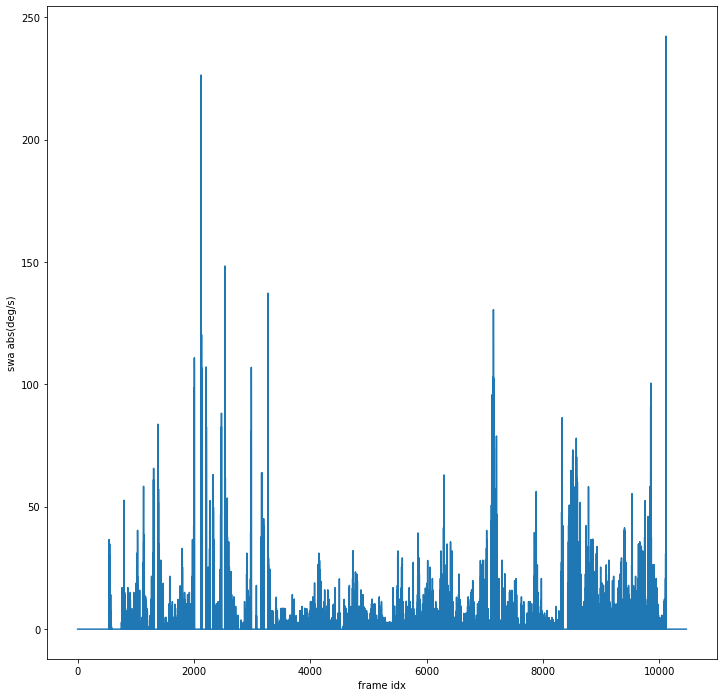

In [28]:
plt.plot(idxs[:len(abs_angular_speed)], abs_angular_speed)
plt.xlabel("frame idx")
plt.ylabel("swa abs(deg/s)")
plt.show()

In [29]:
qs = list(range(60,90,5))
qs.extend(list(range(90,101,1)))

for q in qs:
    print("{}th: {} deg/s".format(q, round(np.percentile(abs_angular_speed, q=q),1)))

60th: 0.0 deg/s
65th: 0.9 deg/s
70th: 1.9 deg/s
75th: 2.9 deg/s
80th: 4.6 deg/s
85th: 7.5 deg/s
90th: 11.2 deg/s
91th: 12.3 deg/s
92th: 14.1 deg/s
93th: 16.1 deg/s
94th: 17.9 deg/s
95th: 21.6 deg/s
96th: 25.3 deg/s
97th: 30.0 deg/s
98th: 37.6 deg/s
99th: 57.2 deg/s
100th: 242.2 deg/s
